Exploration of:
- [CT_2023-01-23_seed_1_94-9_shared by christopherthomas.ipynb](https://colab.research.google.com/drive/1HpJ3kaA4B23YwrmXPe4x3dG9Q0moI-iN?usp=sharing)
- https://forums.fast.ai/t/a-challenge-for-you-all/102656/38?u=fmussari

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [ ]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
 fc.defaults.cpus

8

In [ ]:
class Dropout(nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training: return x
        dist = distributions.binomial.Binomial(tensor(1.0).to(x.device), probs=1-self.p)
        return x * dist.sample(x.size()) * 1/(1-self.p)

In [ ]:
#Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
#https://arxiv.org/abs/1908.08681v1
#implemented for PyTorch / FastAI by lessw2020 
#github: https://github.com/lessw2020/mish

class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [ ]:
from typing import Iterator
from torch.utils.data import DataLoader, WeightedRandomSampler, RandomSampler, Sampler

class TopLossesCallback(Callback):
    epoch_preds = []
    epoch_targets = []
  
    @torch.no_grad()
    def _calculate_top_losses(self):
        preds = torch.cat(self.epoch_preds, dim=0)
        targets = torch.cat(self.epoch_targets, dim=0)
        losses = F.cross_entropy(preds, targets, reduce=False)
        return torch.topk(losses, preds.shape[0]).indices

    def after_batch(self, learn):
        if not learn.model.training: return
        self.epoch_preds.append(learn.preds)
        self.epoch_targets.append(learn.batch[1])

    def before_epoch(self, learn):
        self.epoch_preds = []
        self.epoch_targets = []

    def after_epoch(self, learn):
        if not learn.model.training: return
        learn.dls.train.sampler.top_losses = self._calculate_top_losses()

# tweaked from tommyc's version
# Before certain epoch drop a % of the training dataset with the lowest losses.
# Replace them with the the same % of the training dataset with the highest losses.
# This gives the model two opportunities to train on the most challenging images.

class CustomTrainingSampler(WeightedRandomSampler):
    def __init__(self, *args, **kwargs):
        WeightedRandomSampler.__init__(self, *args, **kwargs)
        self.data_indexes_for_epoch = []
        self.top_losses = []
        self.epoch = -1
        self.n = { 0: 0, 1: 0.21, 2: 0.42, 3: 0.21, 4: 0 }

    def __iter__(self) -> Iterator[int]:
        self.epoch += 1
        rand_tensor = torch.randperm(self.num_samples, generator=self.generator).tolist()
        n = int(self.n[self.epoch] * self.num_samples)
        
        if n != 0:
            _idxs_for_epoch = torch.tensor(self.data_indexes_for_epoch)
            # TODO: Cleanup the code below
            inverted_losses_for_epochs = torch.flip(torch.tensor(self.top_losses.clone().detach()[:n]), dims=(0,)).cpu()
            self.data_indexes_for_epoch = torch.tensor(self.data_indexes_for_epoch).cpu()
            self.data_indexes_for_epoch[self.top_losses[-n:].cpu()] = self.data_indexes_for_epoch[inverted_losses_for_epochs]
            self.data_indexes_for_epoch = self.data_indexes_for_epoch[rand_tensor]
            self.data_indexes_for_epoch = self.data_indexes_for_epoch.tolist()
            ## FM TEST
            
            _idxs_for_epoch[self.top_losses[-n:]] = _idxs_for_epoch[self.top_losses[:n]]
            _idxs_for_epoch = _idxs_for_epoch[rand_tensor].tolist()
            
            #print(f"{_idxs_for_epoch[:4]=}")
            #print(f"{self.data_indexes_for_epoch[:4]=}")
            
            assert (sorted(self.data_indexes_for_epoch)==sorted(_idxs_for_epoch))
        else:
            self.data_indexes_for_epoch = rand_tensor
            
        yield from self.data_indexes_for_epoch

class CustomDataLoader:
    def __init__(self, *dls): 
        self.train,self.valid = dls[:2]
    
    def get_sampler(num_samples, mode="train"):
        if mode != "train":
            return None
        return CustomTrainingSampler(weights=[1 for _ in range(num_samples)], num_samples=num_samples)

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        return cls(*[DataLoader(
            ds, batch_size, sampler=cls.get_sampler(len(ds), mode), 
            collate_fn=collate_dict(ds), **kwargs) for mode, ds in dd.items()])

In [ ]:
a = b = 0
a, b

(0, 0)

In [ ]:
## FM Rewritten

class CustomTrainingSampler(Sampler):
    def __init__(self, num_samples, generator=None):
        self.num_samples = num_samples
        self.generator = generator
        self.idxs_for_epoch = []
        self.top_losses = []
        self.epoch = -1
        self.n = { 0: 0, 1: 0.21, 2: 0.42, 3: 0.21, 4: 0 }

    #def setup_epoch(self, epoch=None):
        
    def __iter__(self) -> Iterator[int]:
        self.epoch += 1
        rand_tensor = torch.randperm(self.num_samples, generator=self.generator).tolist()
        n = int(self.n[self.epoch] * self.num_samples)
        if n != 0:
            idxs_for_epoch = torch.tensor(self.idxs_for_epoch)
            idxs_for_epoch[self.top_losses[-n:]] = idxs_for_epoch[self.top_losses[:n]]
            self.idxs_for_epoch = idxs_for_epoch[rand_tensor].tolist()
        else: self.idxs_for_epoch = rand_tensor
        
        yield from self.idxs_for_epoch
    
    def __len__(self) -> int: return self.num_samples
        
class CustomDataLoader:
    def __init__(self, *dls): self.train,self.valid = dls[:2]
    
    def get_sampler(num_samples, mode="train"):
        if mode != "train": return None
        return CustomTrainingSampler(num_samples=num_samples)

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        return cls(*[DataLoader(
            ds, batch_size, sampler=cls.get_sampler(len(ds), mode), 
            collate_fn=collate_dict(ds), **kwargs) for mode, ds in dd.items()])

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"

bs = 256

xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
## https://github.com/PiotrCzapla/course22p2/blob/main/nbs/12_utils.ipynb

def _with_features(ds):
    setattr((l:=fc.L(ds)), 'features', ds.features)
    return l 
def cache_dataset_as_dict(dd): return {dsn: _with_features(ds) for dsn,ds in dd.items()}

tds.cached = cache_dataset_as_dict(tds)

In [ ]:
import time

def _format_stats(stats):
    return f"{stats.mean():.2f} ± {stats.std():.2f}"

## Simplified from Piotr
class TimeItCB(Callback):
    def __init__(self): self.reset()
    def tick(self): return time.time()
         
    def reset(self):
        self.start = self.tick()
        self.batches = {True:[], False:[]} 
        self.epochs = {True:[], False:[]}
        
    def before_fit(self, learn): self.reset()
        
    def before_batch(self, learn): self.batches[learn.training].append(self.tick())
    
    def after_batch(self, learn):
        self.batches[learn.training][-1] = self.tick() - self.batches[learn.training][-1]
    
    def before_epoch(self, learn):
        self.epochs[learn.training].append(self.tick())
    
    def after_epoch(self, learn):
        self.epochs[learn.training][-1] = self.tick() - self.epochs[learn.training][-1]
        print(f"AfterEpochTime: {self.epochs[learn.training][-1]}")
    
    def after_fit(self, learn):
        self.total = self.tick() - self.start
        self.batches = {k:np.array(v) for k,v in self.batches.items()}
        self.epochs = {k:np.array(v) for k,v in self.epochs.items()}
        self.print_stats()
    
    def print_stats(self): 
        print(f"Fit {len(self.epochs[True])} in: {self.total:.2f}s, {_format_stats(self.epochs[True])}s per epoch, {_format_stats(self.batches[True])}s per batch")

In [ ]:
dls = CustomDataLoader.from_dd(
    tds.cached, 
    #tds,
    bs, 
    num_workers=0
)

In [ ]:
def get_model9(act=nn.ReLU, nfs=(32,288,288,288,288,288), norm=nn.BatchNorm2d):#,256
    layers = [ResBlock(1, 32, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
from torchvision import transforms

In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop): 
    return tfm_x(b[0]), tfm_y(b[1])

In [ ]:
tfms = nn.Sequential(
    transforms.RandomCrop(28, padding=1),
    transforms.RandomHorizontalFlip(0.65)
)
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [ ]:
# tweaked from rohitgeo's version
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(Mish))
cbs = [DeviceCB(), metrics, TopLossesCallback(), 
       #ProgressCB(plot=True),
      ]
act_gr = Mish
iw = partial(init_weights, leaky=0.0003)
#0.0003 from https://github.com/digantamisra98/Mish/issues/37

In [ ]:
set_seed(1)
epochs = 1
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb,]
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

{'accuracy': '0.840', 'loss': '0.540', 'epoch': 0, 'train': 'train'}
AfterEpochTime: 67.37740111351013
{'accuracy': '0.891', 'loss': '0.340', 'epoch': 0, 'train': 'eval'}
AfterEpochTime: 4.174049377441406
Fit 1 in: 71.58s, 67.38 ± 0.00s per epoch, 0.26 ± 0.02s per batch


In [ ]:
ap1, at = learn.capture_preds()

{'accuracy': '0.891', 'loss': '0.340', 'epoch': 0, 'train': 'eval'}


In [ ]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])

{'accuracy': '0.892', 'loss': '0.323', 'epoch': 0, 'train': 'eval'}


In [ ]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
round((ap==at).float().mean().item(), 4)

0.8931

In [ ]:
learn.fit??

## Trying a Curricular MixIn Batch by Batch

In [ ]:
from torch.utils.data import RandomSampler, BatchSampler

In [ ]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()

In [ ]:
class LossesByLabelCallback(Callback):
    def __init__(self, size=8):
        self.size=size
    
    def before_fit(self, learn):
        self.prev_batch = []
        
    def before_batch(self, learn):
        if not learn.model.training: return
        if self.prev_batch:
            xb = torch.concat((learn.batch[0], learn.comp_xb))
            yb = torch.concat((learn.batch[1], learn.comp_yb))
            learn.batch = (xb, yb)
        else: self.bs = len(learn.batch[1])

    @torch.no_grad()
    def after_batch(self, learn):
        if not learn.model.training: return
        bs = self.bs
        _preds = learn.preds[:bs]
        _targs = learn.batch[1][:bs]
        _losses = F.cross_entropy(_preds, _targs, reduction='none').detach().cpu()[:bs]
        
        targ_idxs, loss_by_targ, top_loss_by_targ = {},{},{}
        
        for k in _targs.unique(dim=0):
            idxs = (k==_targs).nonzero().flatten().detach().cpu()
            k = k.item()
            targ_idxs[k] = idxs
            #loss_by_targ[k] = _losses[idxs]
            top_loss_by_targ[k] = torch.topk(
                _losses[idxs], _losses[idxs].shape[0]
            ).indices
                    
        base_idxs, selected_idxs  = {},{}
        hs = int(self.size/2)
        for k,idxs in targ_idxs.items():
            base_idxs[k] = targ_idxs[k][top_loss_by_targ[k]]
            # Indices of top s losses and s samples with the samllest ones
            #selected_idxs[k] = torch.cat((base_idxs[k][:hs], base_idxs[k][-hs:]))
            selected_idxs[k] = base_idxs[k][:self.size]
        
        _xb = learn.batch[0].detach().cpu()
        comp_xb, comp_yb = [],[]
        
        #print('Selected Indices')
        #print([(k,len(v)) for k,v in targ_idxs.items()])
        for k,idxs in selected_idxs.items():
            #print(f'{k=}, {idxs=}')
            comp_xb.append(_xb[idxs][:hs]*.5 + _xb[idxs][-hs:]*.5)
            comp_yb.append(_targs[idxs][:hs])
        
        learn.comp_xb = torch.cat(comp_xb, dim=0).clone()
        learn.comp_yb = torch.cat(comp_yb, dim=0).clone().cpu()
        self.prev_batch=True

In [ ]:
class TrainLearnerPrevBatchSample(Learner):
    def predict(self): 
        #print(f'predict: {self.batch[0].shape=}')
        #print(f'predict: {self.batch[1].shape=}')
        self.preds = self.model(self.batch[0])
        
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [ ]:
class DualBatchCB(Callback):
    order = 1
    def after_batch(self, learn): 
        if learn.iter==1: raise CancelFitException()

In [ ]:
len_train = len(dsd['train'])

In [ ]:
def get_dls_sampler(train_ds, valid_ds, bs, batch_sampler=None, **kwargs):
    return (DataLoader(train_ds, batch_sampler=batch_sampler, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

class DataLoadersSampler:
    def __init__(self, *dls): self.train, self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, batch_sampler=None, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls_sampler(*dd.values(), bs=batch_size, collate_fn=f, batch_sampler=batch_sampler))

In [ ]:
bs = 256

g_cpu = torch.Generator().manual_seed(2525555555)
set_seed(1)
b_sampler = list(BatchSampler(RandomSampler(range(len_train), generator=g_cpu), batch_size=bs, drop_last=False))

#dls_t = DataLoader(tds['train'], batch_sampler=b_sampler, collate_fn=collate_dict_fm(tds['train']))
dls = DataLoadersSampler.from_dd(
    tds.cached, 
    #tds, 
    batch_size=bs, num_workers=0, batch_sampler=b_sampler)

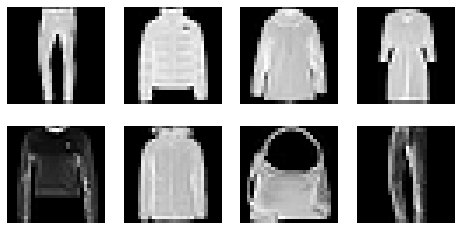

In [ ]:
xb0, yb0 = next(iter(dls.train))
show_images(xb0[:8], imsize=2.0)

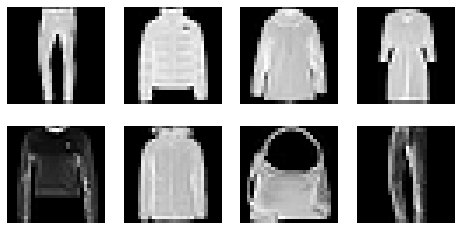

In [ ]:
show_images(tds['train'][b_sampler[0]]['image'][:8], imsize=2.0)

In [ ]:
set_seed(1)
dls = DataLoadersSampler.from_dd(
    tds.cached, 
    #tds, 
    batch_size=bs, num_workers=0, 
    batch_sampler=b_sampler
)

epochs=1
lr = 1e-2

model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)

In [ ]:
lblcb = LossesByLabelCallback(size=4)
lblcb.order=-10

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

cbs = [DeviceCB(), metrics, lblcb, 
       #ProgressCB(plot=True)
      ]
xtra = [BatchSchedCB(sched), augcb, 
        DualBatchCB()
       ]

learn = TrainLearnerPrevBatchSample(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

{'accuracy': '0.811', 'loss': '0.610', 'epoch': 0, 'train': 'train'}
AfterEpochTime: 71.14726734161377
{'accuracy': '0.887', 'loss': '0.340', 'epoch': 0, 'train': 'eval'}
AfterEpochTime: 3.116023063659668
Fit 1 in: 74.27s, 71.15 ± 0.00s per epoch, 0.30 ± 0.02s per batch


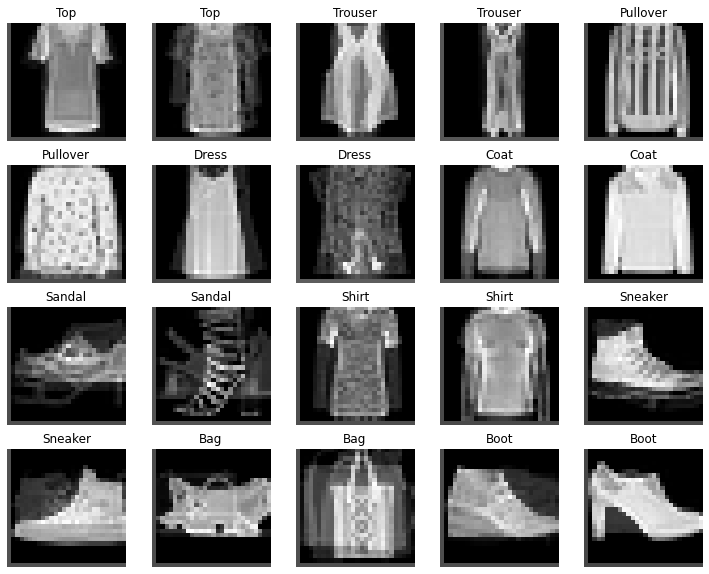

In [ ]:
#, titles=itemgetter(*ybt)(names)
q=24
show_images(learn.comp_xb[:q], imsize=2.5, titles=itemgetter(*learn.comp_yb[:q])(names))

accuracy,loss,epoch,train
0.850,0.582,0,train
0.851,0.447,0,eval
0.901,0.300,1,train
0.902,0.280,1,eval
0.923,0.223,2,train
0.917,0.231,2,eval
0.939,0.176,3,train
0.940,0.176,3,eval
0.953,0.137,4,train
0.948,0.159,4,eval


predict: self.batch[0].shape=torch.Size([192, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([192])
Selected Indices
[(0, 20), (1, 20), (2, 15), (3, 23), (4, 22), (5, 18), (6, 15), (7, 15), (8, 19), (9, 25)]
k=0, idxs=tensor([158,   8,  80,  42, 124,  31,  17,  20,  70, 144, 166, 132])
k=1, idxs=tensor([162, 103,   7, 184, 140,  45, 145,   0,  25, 101,  88,  99])
k=2, idxs=tensor([ 10, 173,  55,  58,  77, 180,  96, 172,  29,  47, 106, 148])
k=3, idxs=tensor([ 49, 189,  72,  16,  79,  73, 134,  48,  13, 125, 122, 154])
k=4, idxs=tensor([  2, 143, 171, 153,   1,   5,  12,   9,  52, 139,  34, 126])
k=5, idxs=tensor([ 11,  82, 109,  95, 149,  15,  63,  27, 159,  66,  14,  62])
k=6, idxs=tensor([100,  64, 112, 120, 150,  60, 136, 127, 117, 142, 165, 163])
k=7, idxs=tensor([ 43, 186,  85, 170,  21, 113, 151, 178, 161,  35, 175,  94])
k=8, idxs=tensor([ 22, 188, 110, 147,  32,  54, 121,   6,  30, 138,  98,  86])
k=9, idxs=tensor([102,  90,  53,  74, 128,  87,  76,  97,  75,  84, 108, 133

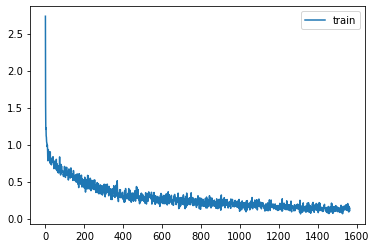

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 31), (1, 31), (2, 28), (3, 28), (4, 23), (5, 27), (6, 25), (7, 21), (8, 17), (9, 21)]
k=0, idxs=tensor([179, 141, 169, 183, 167,  76, 196,  86,  10, 194,  81, 197])
k=1, idxs=tensor([198,  63, 202, 104, 106, 154, 110,   1,  25,  72,  55,  23])
k=2, idxs=tensor([ 16, 164, 136, 131, 165,   5, 204, 137, 206, 209, 208, 207])
k=3, idxs=tensor([ 38, 172,  66,  89,  71,   4, 213,  51,  85, 215, 112,  27])
k=4, idxs=tensor([162,  17,  36, 216,   9,  47, 109,  90, 221, 191,  97, 134])
k=5, idxs=tensor([124,  40,  88, 166,  13, 223,  75, 128,  94, 180, 139,  65])
k=6, idxs=tensor([ 77, 130,   3, 158, 182, 175,  32,  79, 233, 230,  30, 232])
k=7, idxs=tensor([102,  68, 149,  87,  80, 234, 236,  37, 189, 238,   8, 168])
k=8, idxs=tensor([116, 155, 153, 181, 242, 241, 244, 243, 113, 240, 114, 245])
k=9, idxs=tensor([249, 123,  42, 250, 248, 186,  45, 174, 145, 247,   7,  39

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 21), (1, 23), (2, 26), (3, 31), (4, 28), (5, 22), (6, 29), (7, 22), (8, 23), (9, 27)]
k=0, idxs=tensor([128,  33, 165, 160,  23,  21, 197,  43,  62, 196,  86, 118])
k=1, idxs=tensor([176, 112, 198, 135, 127, 202,  79, 169, 190, 102, 104, 109])
k=2, idxs=tensor([ 76, 156,  59, 141, 208, 206, 187, 171, 173,  44, 155, 107])
k=3, idxs=tensor([ 39, 134,  26,  20,  49, 210, 101, 162, 142,  41,  19,  11])
k=4, idxs=tensor([117,   4, 191,   8, 146,  73, 219, 217, 221, 180, 220,  57])
k=5, idxs=tensor([ 71, 105,   0, 130, 222, 108,  27, 186, 170,  47, 113,   6])
k=6, idxs=tensor([ 25, 151, 150,  22, 166,  46, 168, 183, 233,  90, 121, 231])
k=7, idxs=tensor([234,  53, 163,   5,  12, 236,  13,  31, 137, 237,  68, 239])
k=8, idxs=tensor([120, 144, 159,  35, 136,  92, 245,  37, 243,  80, 244, 154])
k=9, idxs=tensor([ 97,   3, 122,  91,  72,  69, 248, 158, 143, 157,  38,  94

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 23), (1, 23), (2, 33), (3, 22), (4, 22), (5, 26), (6, 21), (7, 26), (8, 30), (9, 26)]
k=0, idxs=tensor([ 30,  37, 108, 125, 186,  36, 197,  72,  24, 190,  59, 151])
k=1, idxs=tensor([ 89,  60,  79, 198,  75,  51,  88, 103, 142, 101,  66,  28])
k=2, idxs=tensor([128,  41,   1,  48,  74, 100,  87,  98,  95,  20, 107, 119])
k=3, idxs=tensor([ 52,  84, 184,  53, 110, 213, 146,  25,  46, 179, 131, 117])
k=4, idxs=tensor([ 83,  55,  76, 216,  61, 153, 220, 168, 221,  91,  80,   5])
k=5, idxs=tensor([157, 222, 223,  10, 224, 226,  56, 133,  29,  93, 137, 104])
k=6, idxs=tensor([ 38,  43, 167,  34, 130,  90, 231, 233, 138, 156, 121,  18])
k=7, idxs=tensor([ 17, 129, 182, 141, 234,  44, 148,  73,  33, 166,  21, 140])
k=8, idxs=tensor([155,  31, 161, 181, 240, 144, 244, 136,  94, 158,  71, 143])
k=9, idxs=tensor([178, 106, 246, 123, 247,  47,   3, 185,   9, 114,  23, 127

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 30), (1, 25), (2, 31), (3, 26), (4, 18), (5, 24), (6, 27), (7, 32), (8, 19), (9, 20)]
k=0, idxs=tensor([150, 146,  91, 135,  76, 192,  41, 115, 108,  58,  51,  34])
k=1, idxs=tensor([ 27, 122, 198,  45, 185, 201, 114,  81, 163,  77, 107, 170])
k=2, idxs=tensor([ 23,  87, 207, 204,  10, 206, 109,  53, 128, 189,  84,  50])
k=3, idxs=tensor([151,  69,  54,  14, 175, 100,  90, 214,   7, 166, 215, 213])
k=4, idxs=tensor([  5,  88, 158, 216, 181,  66, 219, 113, 221,  89, 220, 123])
k=5, idxs=tensor([164, 223, 126, 224,  18, 227, 141, 156,  97, 118, 178, 186])
k=6, idxs=tensor([124,  43, 173,  48, 167, 228, 169, 106,  73,  24, 183, 144])
k=7, idxs=tensor([ 74,   8, 157, 133, 187, 134, 148,  67,   1,  25, 172, 171])
k=8, idxs=tensor([110, 103,  37, 241, 242,  92, 131, 104, 243,  59,   3,  22])
k=9, idxs=tensor([250, 191, 246, 111, 248,  65,  46,  35, 251, 130, 117,  79

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 21), (1, 25), (2, 21), (3, 19), (4, 33), (5, 31), (6, 26), (7, 21), (8, 33), (9, 22)]
k=0, idxs=tensor([ 12,   3, 140, 124, 195,  47, 186,  82, 127,  23, 196, 177])
k=1, idxs=tensor([118,  18, 198, 116,  74, 138,   6,  90, 191, 201, 199,  96])
k=2, idxs=tensor([ 24,  85, 143, 153, 171, 204, 103, 165, 106, 131,  25, 183])
k=3, idxs=tensor([ 77, 113,  15, 152, 211,  31, 213, 214, 109, 180, 212, 121])
k=4, idxs=tensor([ 69, 151,   0, 134,  56, 190, 220, 221,  92, 162,  14, 114])
k=5, idxs=tensor([ 84,  22, 170, 222, 225, 224,  20, 169,  42,  73,  32, 161])
k=6, idxs=tensor([ 70,  95, 174,  72, 187, 229, 233, 232, 126, 188, 168, 100])
k=7, idxs=tensor([ 30, 163, 234,  51,  46, 141,  11, 128,  80, 176,  49,  28])
k=8, idxs=tensor([101,  16, 184, 241, 182,  55,  29, 119, 181,  99, 135,  33])
k=9, idxs=tensor([ 39,  89, 248, 130, 132,  34, 249, 108,  67, 167, 142, 178

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 24), (1, 24), (2, 24), (3, 25), (4, 22), (5, 26), (6, 21), (7, 25), (8, 33), (9, 28)]
k=0, idxs=tensor([113, 193, 192,  52,  76, 166, 155, 197,   9, 103, 101,   4])
k=1, idxs=tensor([124, 198,  67,  31,  89,   6,  77, 202,  66, 149,  11, 201])
k=2, idxs=tensor([168,  37,  98,  17,   8,   7, 207, 146,  33,  75, 117, 119])
k=3, idxs=tensor([ 88,  61,  15, 175,  58,  45, 123, 169, 212,  56,  54,  49])
k=4, idxs=tensor([ 83, 145, 110, 177, 129, 114, 170, 219,   0, 163,  86, 105])
k=5, idxs=tensor([136,  44, 140, 104,  13, 164,  28, 225, 186, 189, 142,  82])
k=6, idxs=tensor([138, 153, 112, 229,  14, 141, 150, 232, 233,  93,  80, 174])
k=7, idxs=tensor([152,  18,  22, 167,  24, 162, 160, 237, 239, 118,  12, 235])
k=8, idxs=tensor([185, 107,  59,  95, 242, 125, 190, 135,  47, 179, 156, 191])
k=9, idxs=tensor([ 96,  97, 137,  84, 183,  64, 154,  10, 158, 131,  43, 109

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 35), (1, 25), (2, 21), (3, 22), (4, 29), (5, 21), (6, 32), (7, 22), (8, 17), (9, 28)]
k=0, idxs=tensor([113,  20,  17,  21,  69, 192,  72,  88,  81,  52,  46, 101])
k=1, idxs=tensor([ 87, 147,  91, 185, 203,  73, 157,   5, 198, 201, 202, 199])
k=2, idxs=tensor([159,  48, 205, 207, 115, 206, 155,  65, 208,  99, 130,  34])
k=3, idxs=tensor([ 13, 123, 162, 173,   8, 210, 188, 213,  59, 215,  43, 214])
k=4, idxs=tensor([ 42,  25, 111, 191,  56, 216, 221, 103,  83, 151, 220,  82])
k=5, idxs=tensor([223, 222,  80, 183, 225, 180, 112, 227, 164, 144,  68,  96])
k=6, idxs=tensor([117, 172, 232,  95, 108, 230,  35, 142, 228,  33, 177, 110])
k=7, idxs=tensor([ 38,  60, 175,   9, 167, 140, 238,  30,  51, 239,  36, 237])
k=8, idxs=tensor([ 41, 240, 241,  93, 114, 116, 243,  19, 244, 153, 245,  84])
k=9, idxs=tensor([145, 138, 166,  47,  66, 248, 250, 105, 119,  14,  78, 246

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 27), (1, 23), (2, 23), (3, 25), (4, 25), (5, 21), (6, 31), (7, 22), (8, 29), (9, 26)]
k=0, idxs=tensor([ 98, 107,  42,   4,  47,  10, 197,  48, 196,  38,  70,  69])
k=1, idxs=tensor([198,  26,  91, 202,  29, 143, 201, 151, 184,  93,  86, 203])
k=2, idxs=tensor([ 94, 204,  51,  24,  73, 205,  52, 208, 209, 127, 191,  75])
k=3, idxs=tensor([ 20,  22,  56,  59, 136, 157,  62, 100, 114,  19, 189, 105])
k=4, idxs=tensor([183, 186, 174, 170,  36, 141, 216, 116,  34, 219,   9,  72])
k=5, idxs=tensor([222, 223, 166,   5, 161,  12,   6,  64, 123, 225,  11, 167])
k=6, idxs=tensor([ 43,  28, 172,  96, 163,  66,  21, 144, 129, 113, 182, 179])
k=7, idxs=tensor([102,  83,  95, 236,  82, 152, 237, 238, 239,  54,   0,  97])
k=8, idxs=tensor([142,  89, 131,  18,  58, 160,  39, 240, 177,  37, 124, 111])
k=9, idxs=tensor([ 40, 135,  15, 155, 180,  99, 251,  31,  25,  49, 248, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 20), (1, 22), (2, 28), (3, 31), (4, 29), (5, 17), (6, 26), (7, 40), (8, 27), (9, 12)]
k=0, idxs=tensor([192,  87, 166,   7, 193, 195, 194, 110, 142, 197,  94,  38])
k=1, idxs=tensor([105, 109,  78, 199, 198, 200,  71, 128, 150, 169,  56, 115])
k=2, idxs=tensor([204, 205, 103,  62, 100,  80, 189,  77,  67, 140,  68, 118])
k=3, idxs=tensor([185,  55,  39,  43, 210, 161,  18, 146,  42,  13,  30, 187])
k=4, idxs=tensor([ 21,  48, 156, 216,  57, 218, 179, 167, 149, 129,  27,  91])
k=5, idxs=tensor([222, 225, 224,  79,  35, 126, 141, 177, 174, 191, 151, 114])
k=6, idxs=tensor([ 82, 143,  31, 229, 230, 124,  44, 134,  33,  37, 145, 176])
k=7, idxs=tensor([ 32, 111,  17, 235, 157, 234, 104, 138,  81,  98,  52, 102])
k=8, idxs=tensor([108,  26,  53,   9, 240, 147, 130, 190,  41,  96,  64, 139])
k=9, idxs=tensor([250,  16, 120, 247, 251,  58, 248,  61, 249, 135, 246, 122

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 23), (1, 29), (2, 22), (3, 24), (4, 24), (5, 27), (6, 26), (7, 31), (8, 19), (9, 27)]
k=0, idxs=tensor([ 37, 164, 116,  83,  51,  67,  32, 195,  18, 111, 196, 197])
k=1, idxs=tensor([200, 198,  79,  93,  14, 199, 189,  33, 112, 145, 110, 183])
k=2, idxs=tensor([204, 166, 104, 117, 206, 158, 178,  13,   9, 126, 144, 172])
k=3, idxs=tensor([ 80,  15,  34, 169,  27,  88,  43, 214,  22,   4, 113, 136])
k=4, idxs=tensor([ 61,  28, 153,  59, 157,  25,  75,  48,  50, 170,  99, 165])
k=5, idxs=tensor([223, 225, 222, 226, 149, 224,  45,  57,   5,  58,  20,   8])
k=6, idxs=tensor([ 62, 160, 173, 185,  60, 125, 232, 187, 231, 190,  76, 168])
k=7, idxs=tensor([ 85, 177, 134,  55,  94, 131, 102, 118, 105, 179, 138,  65])
k=8, idxs=tensor([ 69, 142,  89, 240,   1, 241, 244,  41, 137, 176,  90, 242])
k=9, idxs=tensor([ 21, 246,  81,  30,  74, 162, 107, 248,  47,  42, 250, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 19), (1, 20), (2, 31), (3, 20), (4, 34), (5, 29), (6, 23), (7, 21), (8, 26), (9, 29)]
k=0, idxs=tensor([192, 193, 112, 146, 164, 108,  10, 195, 194,  46, 197, 160])
k=1, idxs=tensor([ 63,   7,  43, 169,  25,  19,  50, 201, 113, 199, 198, 203])
k=2, idxs=tensor([142, 204, 143,  30,  72, 157, 205, 191, 144, 179,  81, 133])
k=3, idxs=tensor([ 38,  15, 104, 121, 210, 168, 212, 211, 215, 214, 145, 132])
k=4, idxs=tensor([117,  85,  24, 176,  34, 120, 167, 221, 177,  49,  88,  35])
k=5, idxs=tensor([107,  11, 170,  65, 155,  31,  57,  16, 171,   2, 223, 227])
k=6, idxs=tensor([ 80,  42, 229, 228,  36, 190, 123, 131, 232, 149,  13, 189])
k=7, idxs=tensor([ 75,   6,  29, 106, 150,  53,  59, 238, 237, 236,  33, 239])
k=8, idxs=tensor([ 64,  28, 109,  23, 105,  47, 115, 244, 183, 137, 127, 242])
k=9, idxs=tensor([249, 166, 248, 116,  91, 114,  32,  95, 251, 250, 174, 152

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 33), (1, 25), (2, 20), (3, 26), (4, 22), (5, 30), (6, 24), (7, 25), (8, 29), (9, 18)]
k=0, idxs=tensor([183,  12, 192, 155, 160,  52,  97, 173,  54,  94, 143, 167])
k=1, idxs=tensor([ 21,  31, 107, 198, 201, 200, 164, 158, 109,  40,   0, 199])
k=2, idxs=tensor([ 89,  95,  64,  84,  74, 147, 204, 206,   6,  28, 208, 209])
k=3, idxs=tensor([129,   4,  56, 162, 210, 187, 123, 213, 138,  37, 108, 215])
k=4, idxs=tensor([ 80, 116, 188, 179, 151,   2, 101,  27,  35, 221,  26,  47])
k=5, idxs=tensor([152, 224, 135, 180, 223,  86,  13,  38,  72, 190,  33,   8])
k=6, idxs=tensor([  1,  61, 185, 231, 157,  96,  49, 233,  46, 103,  29, 232])
k=7, idxs=tensor([119,  25, 148, 236, 234,  51, 114,  32, 134, 144, 239, 159])
k=8, idxs=tensor([125,  48, 149,  85, 240, 154,  53, 127, 245,  39, 244, 243])
k=9, idxs=tensor([163,  44, 246,  60, 132,  59,  67, 140, 131, 247, 251, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 27), (1, 22), (2, 25), (3, 30), (4, 20), (5, 28), (6, 21), (7, 27), (8, 25), (9, 27)]
k=0, idxs=tensor([ 11, 192, 193,  83, 195, 173, 194,  63,  87, 158, 110,  54])
k=1, idxs=tensor([ 72, 199, 203, 202, 167, 181,  44, 201,  15, 126,  71, 165])
k=2, idxs=tensor([188, 154, 151, 171, 205, 157,  69, 168, 130,  27,   3,  62])
k=3, idxs=tensor([179,  50, 104,   4, 211, 127, 184,  35, 149, 116,  88,  51])
k=4, idxs=tensor([ 37, 217,  21, 159, 219, 216, 134, 155, 161, 218,  56,  99])
k=5, idxs=tensor([136,  36, 223, 139, 222,  97,  92, 152, 189,  90, 225, 227])
k=6, idxs=tensor([ 65, 112, 156, 232,  18, 137,  49, 145, 229,  68, 228,  67])
k=7, idxs=tensor([ 47,  95,  94,   8, 160, 238, 138, 180, 142,  39, 239,  26])
k=8, idxs=tensor([243,  53,  20,  64,  22,  84, 241, 147, 242, 245, 166, 185])
k=9, idxs=tensor([250, 120, 246, 249, 191,  12, 247,  16, 183,  80,  77,  31

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 22), (1, 24), (2, 20), (3, 29), (4, 30), (5, 19), (6, 24), (7, 28), (8, 30), (9, 26)]
k=0, idxs=tensor([181,  87, 193,  96, 167,  71, 125, 129, 197, 192, 113, 194])
k=1, idxs=tensor([173, 132,  86, 198,  93, 108, 203, 202,  64, 124, 201, 200])
k=2, idxs=tensor([ 41, 137, 141, 115,   7, 142,  69,  27, 206, 207,  10, 205])
k=3, idxs=tensor([134, 175, 119, 140,  89,  90, 151,  28,  77, 211, 215, 156])
k=4, idxs=tensor([ 21,  32, 184,  66, 162, 217,  55,  63, 221,  31, 178,  34])
k=5, idxs=tensor([107,  16, 133, 222,  59,  48, 223,  44,  83, 226, 227, 102])
k=6, idxs=tensor([ 94, 188, 229, 231,  67,  11, 135,   8, 154,  37,  85,  20])
k=7, idxs=tensor([  4, 144,  75,  42, 183, 155,  92,  76, 138, 239, 187,  95])
k=8, idxs=tensor([  9,   5, 245,  47, 186,  74, 169, 114, 241, 147, 243, 185])
k=9, idxs=tensor([177, 149, 168,  38,  46,   0, 247, 136, 123,  40, 249, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 19), (1, 23), (2, 22), (3, 24), (4, 23), (5, 27), (6, 27), (7, 34), (8, 24), (9, 29)]
k=0, idxs=tensor([192, 139,  16, 112,   8, 140,  20, 189, 196, 127,  67, 165])
k=1, idxs=tensor([108, 100, 176,  97, 198,  52,  72, 199, 202,  55, 203, 201])
k=2, idxs=tensor([204,   7, 206,  93, 207, 205,  56,  58,  32, 145, 178,  77])
k=3, idxs=tensor([  3,  29,   2,  44, 119,  19, 215,  84,  74,  68, 212, 214])
k=4, idxs=tensor([ 13, 216,  10, 218, 219,  86, 134, 221,  70, 110,  65,  95])
k=5, idxs=tensor([ 41,  39,   0, 183, 222, 227,  59, 151,  33, 166,  61, 107])
k=6, idxs=tensor([ 64,  54,  42,  80, 184,  88,  14, 233, 124, 231, 153, 126])
k=7, idxs=tensor([ 25,  91,  96,  48,  34,  43, 190,  62,  69, 168, 239, 237])
k=8, idxs=tensor([240, 114, 122, 149, 241, 242,  92, 244, 102, 150, 133, 245])
k=9, idxs=tensor([ 17,  40, 129,  26, 247, 142,  51,  53, 249, 173,  38, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 21), (1, 28), (2, 26), (3, 21), (4, 27), (5, 24), (6, 16), (7, 38), (8, 29), (9, 22)]
k=0, idxs=tensor([ 41, 121,   5, 192, 167, 181, 140, 126, 169, 132, 152, 149])
k=1, idxs=tensor([ 59, 198, 107,  84, 161, 201,  37, 174,  64,  39,  42, 130])
k=2, idxs=tensor([ 18,  27, 206, 184, 205, 204, 118, 138, 170, 153,  44, 141])
k=3, idxs=tensor([210, 127, 183,  40,  51, 215, 213,  71, 143,  94, 137, 165])
k=4, idxs=tensor([ 55, 189,  26,  50,   3, 168, 122, 219, 218,  49,  62, 120])
k=5, idxs=tensor([ 90,  20,  75, 123, 162,  99,  66, 226, 224, 227, 222, 225])
k=6, idxs=tensor([ 72,  95, 229, 231, 144, 230,  32,  45,   8,  35,  60, 108])
k=7, idxs=tensor([  0, 176, 234,  24, 235, 160,  14,  81, 114, 157,  79,  10])
k=8, idxs=tensor([ 28, 186, 104,  73,  53, 240, 163,  65, 243, 245,  33, 244])
k=9, idxs=tensor([124,  43, 105,  30, 100, 246, 250, 139, 187,  16, 131, 135

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 27), (1, 20), (2, 25), (3, 25), (4, 21), (5, 20), (6, 26), (7, 28), (8, 32), (9, 28)]
k=0, idxs=tensor([ 92, 129,  39, 169, 193,  84, 197, 134,  37,   6,  97,   7])
k=1, idxs=tensor([113,  79, 104, 112,  64,  82, 135, 202, 200, 201, 137, 167])
k=2, idxs=tensor([ 61,  50, 106, 145,  96, 204,   3,   8,  63, 208,   2, 206])
k=3, idxs=tensor([144, 182, 179, 126, 180, 132, 174, 188, 214,  19, 143,  16])
k=4, idxs=tensor([217, 216, 152, 220, 218, 148,  52,  43, 136,  36, 168, 101])
k=5, idxs=tensor([222,  44, 183, 150, 225, 120,  18,  81, 153, 122, 224, 160])
k=6, idxs=tensor([ 15,  73, 231, 229, 142, 115,  77,  34,  88, 233, 125, 121])
k=7, idxs=tensor([ 17,  67, 114,  85, 119, 172, 239, 234, 238,  62,  76, 237])
k=8, idxs=tensor([ 11,  14, 146,  28, 242, 244,  24, 184,  20, 155,  23,  12])
k=9, idxs=tensor([ 42,  68,   9,  91, 246,  30, 109,  58, 248, 178, 111, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 21), (1, 27), (2, 26), (3, 27), (4, 23), (5, 26), (6, 20), (7, 32), (8, 27), (9, 23)]
k=0, idxs=tensor([  4,   0, 181,  58,  81, 192, 104,  11, 119, 197, 121,  33])
k=1, idxs=tensor([ 57, 198,  43,  17,  38, 100, 125,  83, 203, 199, 132, 146])
k=2, idxs=tensor([148, 108,  56,  48,  98, 204, 208,   2, 133,  87, 122,  64])
k=3, idxs=tensor([ 49, 101,  77, 163, 177,  80, 135, 212, 142, 214, 213, 215])
k=4, idxs=tensor([ 41,  63, 216, 165,  21,  39,  55, 157, 221, 218, 220, 217])
k=5, idxs=tensor([222,  25,  88, 161,  91,  28, 167, 139,  27,  34,  71,  74])
k=6, idxs=tensor([191,  85,  23, 162, 137, 112,   7, 233, 232, 228,  92, 149])
k=7, idxs=tensor([145, 234,  82,  31,  30, 164,   8, 239,  70,  76, 169, 105])
k=8, idxs=tensor([ 12, 128, 126, 240, 131,  45, 241, 150, 127,  14,  67,  78])
k=9, idxs=tensor([103,  73,  90,  20, 144, 111,  36, 247, 251, 250, 249, 248

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 31), (1, 20), (2, 22), (3, 26), (4, 26), (5, 25), (6, 28), (7, 28), (8, 26), (9, 20)]
k=0, idxs=tensor([ 67, 165,  82, 126, 193, 121, 127, 153, 140,  53, 105, 185])
k=1, idxs=tensor([198,  68,  60, 199, 202, 154, 171,  65, 170, 114,  70, 201])
k=2, idxs=tensor([204, 205, 143, 206,  83, 118, 137, 160,  32, 189, 136, 164])
k=3, idxs=tensor([181,   8,  89, 176,  24, 113,  62, 174, 179,  52, 215,  21])
k=4, idxs=tensor([146, 157, 172,  87, 216, 119, 190,  11, 144, 219, 221,  28])
k=5, idxs=tensor([222, 148, 223, 224,  19,  51, 110,  90, 115, 108,   1,  27])
k=6, idxs=tensor([ 66, 173, 117,  20,  26, 169, 106,  78, 103,  44,   5,  64])
k=7, idxs=tensor([141, 151,  74,  55, 175, 237, 132,  13, 152,  10, 120,  77])
k=8, idxs=tensor([ 36, 241,  84,  29, 129,  16, 240, 100, 109,  34,  43, 178])
k=9, idxs=tensor([246, 249, 251,  81, 247, 250,   7, 156, 184,  99,  71,  33

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 21), (1, 26), (2, 36), (3, 15), (4, 23), (5, 32), (6, 27), (7, 23), (8, 19), (9, 30)]
k=0, idxs=tensor([153,  90, 142,  85,  36, 193, 157, 129, 197,  67, 195, 192])
k=1, idxs=tensor([ 37, 123,  46, 154, 199, 109,  92,  68, 106, 152,  96, 108])
k=2, idxs=tensor([182,  47, 171,  38, 114,  25,  31, 177,  74, 132, 105, 111])
k=3, idxs=tensor([211, 212, 115, 215, 169,   5, 214,  72, 150,  17, 141, 143])
k=4, idxs=tensor([164,  56,  48,  82,  88,  57, 216, 219, 218,  11, 221,  93])
k=5, idxs=tensor([146,  80,  53,  15, 222,   8,  27, 120,  32, 227,  54,  34])
k=6, idxs=tensor([166, 160, 158,  23,  44,  33, 173,  84,  83, 184, 119,  50])
k=7, idxs=tensor([186, 165, 139, 174, 151, 235,  18, 238,  39,  99, 100,  55])
k=8, idxs=tensor([170, 136, 191,  58, 241, 244, 135,   4, 121, 242, 181, 245])
k=9, idxs=tensor([124, 249, 250,  21, 113, 248, 148, 112,  10, 155, 149,  12

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 27), (1, 34), (2, 23), (3, 23), (4, 26), (5, 22), (6, 19), (7, 32), (8, 21), (9, 25)]
k=0, idxs=tensor([188, 106,  83, 190,  87,  41,  38,  26,  36, 173, 115, 176])
k=1, idxs=tensor([ 13, 148, 104, 107, 177, 141, 200,  95,  93, 126,  31,  56])
k=2, idxs=tensor([ 27,  75,  60, 150,  70,  58, 186, 128,  29, 205, 207, 105])
k=3, idxs=tensor([ 92, 160, 100,   5,  73,   0, 214, 211, 172, 108,  84, 215])
k=4, idxs=tensor([ 32, 165,  76,  97,  64, 221,  11, 152, 216,  20,   3, 217])
k=5, idxs=tensor([ 67, 178, 156, 222, 169, 119,   7,  96, 224, 223,  81, 175])
k=6, idxs=tensor([ 15,  17, 228, 161,  74, 233,  42, 232, 180, 155,  54,  82])
k=7, idxs=tensor([ 33, 137, 101, 138,  98, 102, 181,  19,  16,  86,  61, 239])
k=8, idxs=tensor([114,  49, 162, 240, 242,  23,  80, 243,  30, 113, 167, 145])
k=9, idxs=tensor([248, 109, 103, 247, 143, 146,  57,  89, 163, 251,  78,  10

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 20), (1, 31), (2, 30), (3, 21), (4, 26), (5, 32), (6, 27), (7, 22), (8, 21), (9, 22)]
k=0, idxs=tensor([153, 191,  23, 176, 192, 124, 126, 128, 155, 193, 197, 196])
k=1, idxs=tensor([119,  11, 180, 199,  25, 115, 183,  20,  12,  89, 202, 203])
k=2, idxs=tensor([ 30,  84, 116,  50,  41, 173,  91, 108, 205, 207, 109, 208])
k=3, idxs=tensor([ 51,  59, 125, 210, 170,  24, 141, 172, 211,  67, 214, 212])
k=4, idxs=tensor([185, 216,  17, 218,  26, 143, 114, 137, 138,  92, 149,  58])
k=5, idxs=tensor([ 52, 222,  60, 223, 100, 110,   5, 175, 135,  54, 226,  68])
k=6, idxs=tensor([  4,  31, 230, 144, 231,   0, 232,   8, 123,  90,  18, 169])
k=7, idxs=tensor([234, 235,  82, 105, 167, 236,  83, 113,  72,  38, 117, 178])
k=8, idxs=tensor([156, 106,  87, 240, 142,  28,  34, 188, 244, 102, 243, 145])
k=9, idxs=tensor([ 36,  33,  39, 104, 249,  48, 250, 246, 247, 251,  65,  22

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 25), (1, 28), (2, 24), (3, 21), (4, 26), (5, 26), (6, 23), (7, 24), (8, 30), (9, 25)]
k=0, idxs=tensor([ 53,  80, 172,  67,  98,  73,   2, 128, 195, 193,  58,   1])
k=1, idxs=tensor([119, 200, 199,  85,   6,  35,  26,   5, 198, 203, 202, 201])
k=2, idxs=tensor([ 88,  37, 166, 204, 205, 191,  40,  50, 208,  82, 209,  81])
k=3, idxs=tensor([ 66, 185, 213,  70,  69, 146, 121, 212, 214, 152, 211, 141])
k=4, idxs=tensor([ 94,  20, 118, 218, 168, 216,  19,  22,  46,  25, 159,  24])
k=5, idxs=tensor([110,  71, 223, 224,  27, 222,   9, 183,  42,  62, 130, 136])
k=6, idxs=tensor([109,  12, 189, 145, 230, 233,  16, 155, 173, 139,  33,   3])
k=7, idxs=tensor([154,  77, 131, 234, 147,  72,  39,  44, 124,  93, 239, 237])
k=8, idxs=tensor([125,   0, 123,  28, 241, 182,  96,  63, 190, 164, 177, 101])
k=9, idxs=tensor([248, 144,  51, 111, 246, 250, 162, 165, 170,  30,   8, 115

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 22), (1, 28), (2, 23), (3, 24), (4, 28), (5, 24), (6, 22), (7, 29), (8, 25), (9, 27)]
k=0, idxs=tensor([ 12, 150, 108, 110, 142,  22, 136,  48,  14, 195, 151,  19])
k=1, idxs=tensor([161, 133, 178,   7, 184,  96, 201,  98,  74, 199, 169, 114])
k=2, idxs=tensor([172, 139,   0, 154, 137, 206, 170, 204, 207,  70, 155,  31])
k=3, idxs=tensor([ 75, 143, 177, 144, 158,  61, 213, 189, 211, 121, 183,   5])
k=4, idxs=tensor([190, 216,  78, 135,  89, 171, 221,  71,  66,  11,  85, 141])
k=5, idxs=tensor([100,  58,  99,  44, 166,  46, 226, 222, 103, 107,  28, 223])
k=6, idxs=tensor([106, 128, 116,  84, 146,  43, 232, 233, 109, 231, 229, 191])
k=7, idxs=tensor([ 76, 152, 125, 237,  68,  82, 126,  38,  25,   8,   2, 239])
k=8, idxs=tensor([ 67, 123,  49,  47, 181, 167, 244,  15, 242, 153, 130, 245])
k=9, idxs=tensor([ 16,   3, 145, 148, 117,  72, 122, 174, 147, 165, 248, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 25), (1, 28), (2, 31), (3, 32), (4, 20), (5, 20), (6, 23), (7, 26), (8, 20), (9, 27)]
k=0, idxs=tensor([192,  61, 101, 197, 160, 186, 131,  51, 153, 193,  30, 109])
k=1, idxs=tensor([  1, 176, 170, 188,  25, 201, 107,  20, 203,   8,   0, 202])
k=2, idxs=tensor([ 71, 128, 204,  68,  29,  11, 121,  77,  34, 105,  91, 113])
k=3, idxs=tensor([ 31, 122,   5,  72, 210, 214,  43,   2, 158, 118, 181,  95])
k=4, idxs=tensor([ 97,  66,  94, 171, 217, 220, 184, 219, 159, 132, 165,  59])
k=5, idxs=tensor([ 85, 179, 222, 150,  52, 183, 223,   9, 224, 180,  55, 172])
k=6, idxs=tensor([190, 187, 120, 134,  40, 119, 233, 229, 228, 232,  57, 169])
k=7, idxs=tensor([  3,  76,  45,  12,  56, 148,  67, 146,  98,  82, 237, 157])
k=8, idxs=tensor([244, 240, 241, 242, 168,  28, 163,  33, 136, 125, 140,  93])
k=9, idxs=tensor([110, 124, 246,  64,  23, 164, 147,  83, 137, 138, 102,   7

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 22), (1, 25), (2, 24), (3, 26), (4, 23), (5, 26), (6, 30), (7, 27), (8, 25), (9, 24)]
k=0, idxs=tensor([140,   9, 105, 106, 108, 147, 192, 195, 193, 161, 194, 196])
k=1, idxs=tensor([109, 198, 158,  68, 163, 159, 199, 200, 203, 156, 201, 202])
k=2, idxs=tensor([204,  59, 207, 124,  56,  61, 133,  50, 101,  16, 205, 209])
k=3, idxs=tensor([ 71, 123,  49, 144, 146,  76, 213,  86, 191, 211,  29, 214])
k=4, idxs=tensor([ 94, 218, 188, 150,  99, 164,  60, 175, 130, 116, 221, 178])
k=5, idxs=tensor([ 95, 223, 222, 225, 149,  51, 129, 143, 169,  77, 119, 179])
k=6, idxs=tensor([176, 104,  38, 142, 232, 128, 100,   4,  15, 114,  82,  18])
k=7, idxs=tensor([ 67, 135,   7, 125, 155,  41,   5,  13, 239,  35, 236, 238])
k=8, idxs=tensor([177, 141,  32, 241,  52,  10,   1, 110,  74, 126, 245, 168])
k=9, idxs=tensor([120,  62, 113,  57, 248, 250,  70,  14, 249,  45, 247, 183

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 28), (1, 17), (2, 27), (3, 19), (4, 30), (5, 28), (6, 29), (7, 20), (8, 32), (9, 22)]
k=0, idxs=tensor([ 65,  78,  94,  20,  81, 120, 175, 102,  72, 197, 195,  22])
k=1, idxs=tensor([200, 128, 199, 198, 136, 139, 162, 153, 159, 203, 201, 202])
k=2, idxs=tensor([205,  56,  52,  77, 204,  35, 121, 123, 132, 138,  17, 209])
k=3, idxs=tensor([ 38, 169,  67,  27, 177, 212, 119, 215, 213,  99, 214, 180])
k=4, idxs=tensor([ 61, 103,   7, 179,  86, 216, 112,  33, 160,  79,  97,  66])
k=5, idxs=tensor([ 58, 222, 190,  31, 145,  23, 124,   6, 183,  62, 101, 116])
k=6, idxs=tensor([ 70, 166,  32,  55, 104,  80, 164, 230, 232,   0,  26, 135])
k=7, idxs=tensor([ 84, 144, 237, 236,  89,  30, 235,  34,  11, 238, 239,  85])
k=8, idxs=tensor([  8,  87,  88,  93, 149,  91,  75,  98, 243,   2, 242, 122])
k=9, idxs=tensor([137, 127, 165, 163, 157, 178, 187, 100,  39, 247, 248, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 30), (1, 32), (2, 17), (3, 23), (4, 34), (5, 23), (6, 16), (7, 27), (8, 23), (9, 27)]
k=0, idxs=tensor([148,  85, 120, 193,  57,  25, 109, 107, 138,  99,  96,  71])
k=1, idxs=tensor([ 45,  76, 199,  26, 198,  50,  29, 113,  59,  27,  79, 202])
k=2, idxs=tensor([204, 178,  87, 165, 100, 206, 208, 112,  47, 209,  12, 126])
k=3, idxs=tensor([211, 175, 140, 215,  63, 210, 213, 214,  44,  48,  80, 110])
k=4, idxs=tensor([166,  54, 163, 145, 103, 216, 146, 122, 219, 123,  49,  35])
k=5, idxs=tensor([131,  43, 185, 152,  40,  60,  41,  74, 106, 105, 225, 224])
k=6, idxs=tensor([231, 228, 143, 168, 229, 230, 118,  90, 121,  28,  24,  11])
k=7, idxs=tensor([161, 191,  18,  92, 181, 119, 239, 167,  88, 236, 235, 159])
k=8, idxs=tensor([240, 242, 243,  83, 151,  55,  64, 186, 115, 244,  94,  95])
k=9, idxs=tensor([  4,  22,  19, 247, 177, 246, 125, 251,   9,  61,  30, 189

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 27), (1, 21), (2, 21), (3, 25), (4, 26), (5, 25), (6, 32), (7, 24), (8, 26), (9, 25)]
k=0, idxs=tensor([159,  81, 164, 139, 195, 192,  87, 141, 196,  48, 157, 102])
k=1, idxs=tensor([ 33, 203, 198, 199,  88, 148, 135,  90,  14,  82, 202, 200])
k=2, idxs=tensor([147,  86, 184,  68, 208, 162, 204, 171,  75,  43, 205, 170])
k=3, idxs=tensor([ 92,  94, 110,  10, 215, 140,  26, 115, 125,  85,  11,  36])
k=4, idxs=tensor([217,  13,  17,  95, 216,  70, 130, 175, 150,  49,  97, 118])
k=5, idxs=tensor([225, 138, 108, 223, 222, 182, 174, 151, 122,  45, 145,  55])
k=6, idxs=tensor([ 72,  80, 177,   6,  40, 180, 229,  63,  89,  39, 168, 167])
k=7, idxs=tensor([234,  54, 235,   7,  64, 238, 161, 152,  16, 116, 236, 156])
k=8, idxs=tensor([241, 240, 183,  74, 189, 186,  98, 132, 105, 154,  22, 101])
k=9, idxs=tensor([185,   8, 111,  60,   4, 119, 249,  96, 100,  31, 250, 246

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 25), (1, 20), (2, 23), (3, 34), (4, 29), (5, 23), (6, 27), (7, 24), (8, 26), (9, 21)]
k=0, idxs=tensor([169,  66, 106, 177,  90, 170, 145, 180, 130, 195,   7,  58])
k=1, idxs=tensor([124,  49,  37, 137, 176, 202,  75, 201, 199, 203, 198, 200])
k=2, idxs=tensor([151, 208,  82,   1,  77, 204, 125,  23, 110, 189, 129, 187])
k=3, idxs=tensor([167, 102, 190,  25, 119, 148,   2, 117, 164, 116, 128, 214])
k=4, idxs=tensor([160,  85,  55, 173, 163, 105, 107,  71, 221, 218, 220, 141])
k=5, idxs=tensor([ 41,  38, 188, 175, 104, 134, 178, 225, 227,  97, 112,  83])
k=6, idxs=tensor([229, 108,  92,  30,  35,   9, 109,   5, 232,  52, 138,  22])
k=7, idxs=tensor([ 95,  69, 172,  42, 237, 236,  60,   6, 146,  51, 174,  61])
k=8, idxs=tensor([ 94, 165,  11,  98,  96,  36, 240, 244, 242, 131, 243, 156])
k=9, idxs=tensor([161,   0,  93, 250,  91,  39,  43,  62, 246, 248, 249, 154

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 27), (1, 25), (2, 23), (3, 23), (4, 21), (5, 24), (6, 33), (7, 24), (8, 26), (9, 26)]
k=0, idxs=tensor([139, 112, 122, 153, 116, 192, 160, 161, 124, 143, 142,   4])
k=1, idxs=tensor([199, 100, 144,  77,   1, 198, 202,  19,  15,  81, 201, 203])
k=2, idxs=tensor([ 89, 134,  70,  68, 129, 107,  66, 208, 209,  57, 118, 154])
k=3, idxs=tensor([ 16, 110,  73, 210, 211, 126,  83, 214,  97, 156, 188,   3])
k=4, idxs=tensor([181,  27, 178, 158,  75, 191,   6, 220,  80, 219, 150, 216])
k=5, idxs=tensor([ 67,  30, 108, 113, 174, 138,  64, 103, 223, 128, 105, 227])
k=6, idxs=tensor([ 87, 230, 136, 125, 164, 135, 169, 145, 232, 157,  74, 147])
k=7, idxs=tensor([ 35,  82,   5, 127,  41,  38, 238, 236, 183, 234,  24,  58])
k=8, idxs=tensor([172, 167,  53, 102,  55,  54, 165,  37, 242, 244, 182, 245])
k=9, idxs=tensor([155, 121, 250,   2, 247, 120, 140,  84,  78, 117, 111,  31

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 31), (1, 32), (2, 28), (3, 21), (4, 22), (5, 23), (6, 21), (7, 26), (8, 29), (9, 19)]
k=0, idxs=tensor([ 76, 164,  58, 165, 195, 146,  89,  82,  56, 105,  75, 190])
k=1, idxs=tensor([198,  80,  49,  24, 188,   5,  10,  66,   1, 141, 199, 132])
k=2, idxs=tensor([ 18,  34, 204,   0,  22, 133,  99,  54, 116, 186,  14,  33])
k=3, idxs=tensor([ 65,  50,  77, 160, 210, 212, 187, 120, 171, 215, 119, 127])
k=4, idxs=tensor([ 67,  38,   2, 175, 137, 181,  44, 149, 101, 220, 221,  60])
k=5, idxs=tensor([227, 178,  45, 162, 222,  79, 223, 224, 174, 106,  68,  72])
k=6, idxs=tensor([ 62, 140, 228,  27, 183,  42, 231, 125, 229,  51, 233, 177])
k=7, idxs=tensor([234,  78, 236, 184,  87, 109,  16, 238, 126, 239,   8, 158])
k=8, idxs=tensor([242, 240, 152, 131,  98, 147,  96, 179,  70, 167, 100, 144])
k=9, idxs=tensor([246,  39, 247, 249,  55, 134, 138, 250,  23,  43,  73,  37

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 21), (1, 33), (2, 29), (3, 27), (4, 25), (5, 24), (6, 25), (7, 24), (8, 18), (9, 26)]
k=0, idxs=tensor([ 13,   0,  76,  93, 116,  83,  72, 168, 197,  23, 154, 196])
k=1, idxs=tensor([198, 199, 105, 200,  52,  45,  15,  25,  70,  47,  56, 171])
k=2, idxs=tensor([103, 204,  71, 164,   7, 206, 174,  81,  62,  65,  69,  36])
k=3, idxs=tensor([118, 184,  67,  31,  19, 119, 215, 181, 213, 214, 128, 211])
k=4, idxs=tensor([176, 190, 153, 143,  26, 132,  80, 115,  27, 130, 120,  35])
k=5, idxs=tensor([ 44, 222,  79, 227, 114,  43, 133,  46, 157, 225,  37, 173])
k=6, idxs=tensor([229,  59,  11,  85, 152,  58, 135,  38, 162,   1, 109,  53])
k=7, idxs=tensor([ 64, 183,  57,   2,  98, 178,  91, 191, 110,  39, 106, 134])
k=8, idxs=tensor([ 89, 243, 240,  63, 241,  50,   3,  99,  32,  21,  22,  88])
k=9, idxs=tensor([ 54, 170, 158, 246,  34, 112, 250, 249, 177, 165, 126,  75

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 24), (1, 20), (2, 22), (3, 32), (4, 26), (5, 31), (6, 26), (7, 23), (8, 23), (9, 25)]
k=0, idxs=tensor([ 11, 149, 114, 107,  12,  46, 127, 192, 194, 196, 101, 197])
k=1, idxs=tensor([200, 185, 116, 199, 171, 155,   1, 201, 198, 144, 202, 203])
k=2, idxs=tensor([205, 209, 137, 104, 134,  13, 208, 156,  70, 165, 146,   5])
k=3, idxs=tensor([ 39,  79,   4,  66, 128, 164, 213,  96,  56,  50, 163, 215])
k=4, idxs=tensor([  2, 131, 118, 109, 184, 218,  63,  49, 219, 124, 179, 220])
k=5, idxs=tensor([225, 222, 226, 133,  10,  68,   8, 115, 223, 224, 154, 159])
k=6, idxs=tensor([ 40, 113,  21, 120,  41,  52, 233, 230,  14,  44,  98,  27])
k=7, idxs=tensor([ 62, 102,  76,  86, 157, 103,  83, 238,  54, 235, 239, 236])
k=8, idxs=tensor([241, 138, 242, 151,  35,  23, 105,  42, 245,  25,  15, 244])
k=9, idxs=tensor([  0,  20, 136,  87,  93, 142, 249, 251,  43, 177, 250, 246

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 25), (1, 24), (2, 25), (3, 28), (4, 25), (5, 31), (6, 21), (7, 25), (8, 23), (9, 25)]
k=0, idxs=tensor([192,  86, 144, 119, 195,   1, 186, 102, 174, 115,  68, 196])
k=1, idxs=tensor([158,  95, 105, 177, 172,  16, 198, 201, 200, 109, 203, 202])
k=2, idxs=tensor([ 35, 131, 205,  22,  37, 151, 206, 209,   9, 137, 169, 187])
k=3, idxs=tensor([ 97,  84,  56, 113, 150,  93, 118,  60,  51, 180,  26, 175])
k=4, idxs=tensor([ 96,  29, 183, 217, 185, 133, 140, 221, 191,  14, 116,  61])
k=5, idxs=tensor([ 81,  59, 108,  90,   5,  85, 103,   6, 167, 132, 226, 224])
k=6, idxs=tensor([142,  42,   3,  75, 228, 139, 233, 230,  11,  30,  98, 231])
k=7, idxs=tensor([182, 128, 100, 159, 141, 168,  87, 155,  10,  19, 239, 238])
k=8, idxs=tensor([ 55,  48,  62, 148, 143, 135,  28,  25, 241, 242, 244, 152])
k=9, idxs=tensor([120, 176, 189, 136,  24,  80,  23, 117, 251,  91, 249, 247

predict: self.batch[0].shape=torch.Size([444, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([444])
predict: self.batch[0].shape=torch.Size([444, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([444])
predict: self.batch[0].shape=torch.Size([444, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([444])
predict: self.batch[0].shape=torch.Size([444, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([444])
predict: self.batch[0].shape=torch.Size([444, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([444])
predict: self.batch[0].shape=torch.Size([76, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([76])
predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 26), (2, 21), (3, 29), (4, 28), (5, 24), (6, 21), (7, 21), (8, 25), (9, 31)]
k=0, idxs=tensor([ 65, 144,  42,   8,  23,  80, 196, 195, 197, 194, 156, 132])
k=1, idxs=tensor([162,  41, 145,   7, 140, 198,  39,  99,  88, 200, 201, 202])
k

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 34), (1, 29), (2, 29), (3, 25), (4, 18), (5, 20), (6, 23), (7, 24), (8, 29), (9, 21)]
k=0, idxs=tensor([107, 103, 193,  86, 111, 190,  27, 196, 101,  40, 143, 165])
k=1, idxs=tensor([ 85,   7, 179,  61, 119, 175,  12,  11, 203,   3, 198, 200])
k=2, idxs=tensor([ 71,  74,  79, 205,  73, 100, 208, 206, 104,  84,  88,  48])
k=3, idxs=tensor([  9,  28, 126, 105, 162,   2, 214,  55, 133,  43, 215,  13])
k=4, idxs=tensor([169, 120, 216, 220, 217, 171,  56,  77, 219,  87, 116, 132])
k=5, idxs=tensor([118,  83, 222, 224, 191, 127, 102, 227, 223, 144, 125, 139])
k=6, idxs=tensor([123,  15, 117,  23,  76, 153, 145, 233, 230, 152, 231, 141])
k=7, idxs=tensor([181,  80, 142, 163, 121,  62, 235,  89, 115, 237, 239, 234])
k=8, idxs=tensor([  1, 138,   6,  21,   4,  32, 244,  46, 166,  33, 241, 242])
k=9, idxs=tensor([137, 108, 155,  36, 157,  26,  67,  97, 250, 246, 247, 248

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 24), (1, 29), (2, 30), (3, 19), (4, 25), (5, 30), (6, 26), (7, 25), (8, 29), (9, 15)]
k=0, idxs=tensor([ 64, 125,  74, 190,  86,  40,  53, 127, 119,  59, 197, 195])
k=1, idxs=tensor([198, 163, 183, 108, 200,  71,   3,  28, 160,  61,  19,  17])
k=2, idxs=tensor([ 93,  95, 204, 146,  27,  85, 205,   5, 208, 111, 112,  56])
k=3, idxs=tensor([110,   2,   4, 210, 149, 212,  33,  98, 214,  91, 131, 100])
k=4, idxs=tensor([176, 162,  54, 136, 151, 158, 217,  44, 221,  87,  29,  22])
k=5, idxs=tensor([177,  81, 222,   0, 114, 118, 226,  76,  75, 224,  97,  52])
k=6, idxs=tensor([ 16,  92, 228, 229, 153, 188, 170, 171,   6, 155, 145, 184])
k=7, idxs=tensor([157,  32, 121, 185,  72, 239, 187, 235, 144,  10, 236, 234])
k=8, idxs=tensor([107, 103,  45, 148,  89, 105, 113,  90, 241, 242, 128, 243])
k=9, idxs=tensor([ 12, 172, 246, 248, 247, 249, 250,  60,  41, 132,  25, 181

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 21), (1, 25), (2, 27), (3, 23), (4, 23), (5, 31), (6, 21), (7, 24), (8, 23), (9, 34)]
k=0, idxs=tensor([ 42, 189,  72,  94, 174,  31, 195, 197,  87,  19, 192, 193])
k=1, idxs=tensor([ 18, 116, 201,  62, 198, 199, 188, 159, 185,   9,  14, 170])
k=2, idxs=tensor([204, 169, 143, 205,  12, 105,  37,  52, 207, 209, 208, 147])
k=3, idxs=tensor([114, 171, 164,  34,  25,  84, 214,  77, 157, 122, 215,  55])
k=4, idxs=tensor([ 60, 107, 217, 218,  85, 219, 220, 180, 151, 124, 140,  30])
k=5, idxs=tensor([222,  46, 226, 225, 224, 179,  98,  65, 187, 127, 131,   6])
k=6, idxs=tensor([228, 175,  70, 100, 146,  47,  50,   2, 231,   5, 229, 232])
k=7, idxs=tensor([ 40, 138, 139,  66, 236, 134, 155,   8,  54, 238,  59, 234])
k=8, idxs=tensor([132,  33, 240, 243,  61,  90,  38,  86,  16, 245, 242,  49])
k=9, idxs=tensor([103, 177, 186,   7,  20, 125, 133, 183, 136, 246, 250, 142

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 27), (1, 18), (2, 22), (3, 34), (4, 27), (5, 26), (6, 24), (7, 25), (8, 24), (9, 25)]
k=0, idxs=tensor([ 79,  87, 101,  72, 192,   6, 196,  94, 195, 130, 189, 160])
k=1, idxs=tensor([ 40, 185,  96,  41, 167,  80, 200,  22,   3,  90, 203, 201])
k=2, idxs=tensor([ 15, 117, 114, 206,  34,  37, 142, 170, 125, 208, 207, 209])
k=3, idxs=tensor([ 25, 133,  48,  92, 126, 175,  33,  91,  61, 215, 214, 183])
k=4, idxs=tensor([ 95,  69, 110, 109, 187, 105,  99, 219,  81, 150, 221,  98])
k=5, idxs=tensor([148,  11,  24, 227, 144,  76, 115, 226,   9,  28, 184, 146])
k=6, idxs=tensor([121, 233, 228,  57, 165,  46,  47, 178,  39,  17,  23,  93])
k=7, idxs=tensor([151, 234, 154,   4, 113,  31,  16, 239, 149, 163,   8, 136])
k=8, idxs=tensor([168, 132,  58, 162,   0,  49,  66, 116, 118, 243, 122, 140])
k=9, idxs=tensor([174,  42,  53,  73, 155, 147,  55, 250, 188,  68,  36, 248

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 22), (1, 35), (2, 28), (3, 23), (4, 21), (5, 23), (6, 28), (7, 17), (8, 26), (9, 29)]
k=0, idxs=tensor([154,  77, 136, 193, 173, 196,  73, 118, 163,  48, 155, 164])
k=1, idxs=tensor([199, 201, 202,  97,   8,  58,  76,  59,  60,  31, 187,  94])
k=2, idxs=tensor([147,  30, 159, 140,  39,  91, 131, 122,  44, 179,  23,  78])
k=3, idxs=tensor([166, 185,  66,  34,  11, 161,  85,  17, 212,  46, 214, 215])
k=4, idxs=tensor([ 61, 144,  70, 219,  56, 216, 162, 102, 221, 110,  45,  62])
k=5, idxs=tensor([224, 174, 227, 223,  68,  33, 177,  19, 178, 225,  27, 115])
k=6, idxs=tensor([  2, 184,  25,  20, 188,   6, 233, 152, 108, 232,  16,  10])
k=7, idxs=tensor([ 67,  26, 112, 235, 171, 157,  32,  29, 236, 234, 237, 238])
k=8, idxs=tensor([240,   7,  14,  21, 243, 165, 175, 242,  22,  41,  47, 116])
k=9, idxs=tensor([ 64, 160, 247, 107, 127,  28, 246, 156, 170, 182,  80,  55

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 29), (1, 23), (2, 24), (3, 21), (4, 25), (5, 22), (6, 28), (7, 34), (8, 25), (9, 21)]
k=0, idxs=tensor([ 69,  36, 130, 192,  41, 168, 150, 114,  19,  84,   3, 134])
k=1, idxs=tensor([ 51, 120, 110,  61,  45, 198, 203, 199,  47,  71, 200,   7])
k=2, idxs=tensor([170,  63, 152,  81,  88, 140, 207, 175, 137, 161, 149,  39])
k=3, idxs=tensor([ 54,  93, 108, 182,  75, 123, 211,  10,  73, 177,  76, 213])
k=4, idxs=tensor([ 96, 216, 159, 217, 167, 154,  11,  98,  58, 220,  87, 100])
k=5, idxs=tensor([158, 132,  26, 222, 162,  99,  21, 224, 226,  44, 164, 223])
k=6, idxs=tensor([186, 139, 153,  30,   6, 118, 229, 147,  65,  59, 233,  18])
k=7, idxs=tensor([ 35,  64,  27, 116, 135,  14, 109, 143, 180,  95, 236,  72])
k=8, idxs=tensor([141,   1, 240, 241,  43, 146,  94,  34, 245,  33, 160,  28])
k=9, idxs=tensor([246, 172,  82,   9,  13, 129, 111,  55,  25, 249, 251, 163

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 20), (1, 27), (2, 22), (3, 29), (4, 24), (5, 27), (6, 25), (7, 23), (8, 26), (9, 29)]
k=0, idxs=tensor([138, 192,  28, 136, 144,   3,  70, 149, 137,  27, 180,  43])
k=1, idxs=tensor([168,  52,  53, 126,  22,  95,  94, 167, 199,   8, 202, 198])
k=2, idxs=tensor([204,  87,  44, 141, 205, 127, 107,  80, 206, 209,  66, 108])
k=3, idxs=tensor([ 16, 109, 117, 135,  56,  63, 213, 130, 185, 169, 214,  45])
k=4, idxs=tensor([219,  14, 216, 178, 177,  97,  75, 154,  10,  77, 175, 221])
k=5, idxs=tensor([187,  29,  20, 165,  42, 146,  50, 150, 145, 124,  19, 226])
k=6, idxs=tensor([ 85,  41, 166, 113, 171,  99, 232,  51, 230, 158, 110, 231])
k=7, idxs=tensor([106, 162, 118, 160, 122, 142, 129, 235, 238, 186, 237,  79])
k=8, idxs=tensor([123, 174, 189, 243, 240,  18, 242,  81, 157,  13,   7, 244])
k=9, idxs=tensor([ 37, 121, 116,  32,  74,  59, 251, 104, 246,   0, 247, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 23), (1, 27), (2, 30), (3, 22), (4, 30), (5, 27), (6, 26), (7, 25), (8, 25), (9, 17)]
k=0, idxs=tensor([ 68,  93,  59,  80,   0, 193,  77, 161, 197, 195, 131, 196])
k=1, idxs=tensor([174,  90,  89, 198, 121, 201,  28, 123, 152, 200, 199, 105])
k=2, idxs=tensor([ 95, 166, 159, 142, 180,  18,  50,  98, 207,  15,  92, 209])
k=3, idxs=tensor([ 55, 210,  31, 126, 211, 214,   4,  88, 106,  27, 178,  87])
k=4, idxs=tensor([185,  63, 162, 109,  48,   2, 165,  12,  73, 220,  53,  46])
k=5, idxs=tensor([191, 177, 222, 223, 114,  66,  20, 122, 154,   3, 150,  32])
k=6, idxs=tensor([ 60,  34,  81, 133, 151, 163,  11,  16, 104, 134,  17, 170])
k=7, idxs=tensor([100, 115,  26, 236, 113, 135, 238,  65, 143,  58, 239, 176])
k=8, idxs=tensor([107,   8, 117, 158, 168,  62, 175, 243, 136, 241,  94, 157])
k=9, idxs=tensor([120, 124, 250,  69, 247, 249, 149,  78,  29,  91,  39,  41

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 23), (1, 24), (2, 35), (3, 19), (4, 32), (5, 24), (6, 22), (7, 20), (8, 24), (9, 29)]
k=0, idxs=tensor([ 75,  69,   0,   6, 181,  89,  70, 193, 197,  11,  27, 154])
k=1, idxs=tensor([174, 202,  96,  52, 105, 176, 199, 118, 148, 106,  23, 198])
k=2, idxs=tensor([144, 119, 113, 163,  48,  91, 204,  39, 207,  43, 130, 209])
k=3, idxs=tensor([ 81, 137,   2, 180, 136,   5, 161,   7, 213, 156, 211, 214])
k=4, idxs=tensor([116,  78, 151, 125, 143, 187, 126,  87,  63,  76, 219, 179])
k=5, idxs=tensor([ 34, 159,  51, 226,  59, 223,  22,  93,  28, 227,  77, 224])
k=6, idxs=tensor([228, 127,  58, 167, 139, 230,  98, 123, 183, 233, 231, 232])
k=7, idxs=tensor([109, 110,   3, 234, 235, 153, 236, 145, 114,   9,  61,  31])
k=8, idxs=tensor([108, 240,  92, 157, 162, 138, 242,  36, 243,  71,  15, 121])
k=9, idxs=tensor([ 19, 249, 250, 248, 251, 120, 104,  45, 171, 165, 186,  57

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 25), (1, 27), (2, 27), (3, 26), (4, 24), (5, 27), (6, 33), (7, 17), (8, 23), (9, 23)]
k=0, idxs=tensor([ 62,  98,   4,   8,  86,  79, 193,  93,  81,  18,  42, 197])
k=1, idxs=tensor([198, 178,  17,  65, 130,  73,  20,  70, 199, 202, 201, 203])
k=2, idxs=tensor([116,  19, 122, 205, 184,  39,  32, 141, 206,  28,  66, 140])
k=3, idxs=tensor([161, 129,  69,  78, 210,  10,  23,  63,  14, 177, 173, 167])
k=4, idxs=tensor([ 51, 157, 217,  41,  15, 134, 219,  35, 221, 220, 218, 132])
k=5, idxs=tensor([ 55, 222, 223, 227, 139, 182,  87,  16, 226, 103, 111,  80])
k=6, idxs=tensor([ 22, 112,  37, 228,  82,  92,  91, 109, 171, 147, 180,  97])
k=7, idxs=tensor([148, 115, 105, 101,  40,  50, 143,  26, 235, 237, 239, 238])
k=8, idxs=tensor([172,  74,   2, 159, 163, 124,  71, 244, 242, 241, 245,  76])
k=9, idxs=tensor([133, 149, 246,  36,  96,  34, 100, 247, 156,  11,  58, 166

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 27), (1, 23), (2, 27), (3, 24), (4, 24), (5, 19), (6, 21), (7, 24), (8, 41), (9, 22)]
k=0, idxs=tensor([138,  73,  48,  14, 188, 129, 180,  96, 175, 132, 196, 150])
k=1, idxs=tensor([149, 104, 200, 202, 199, 163, 201,  67, 142,  61, 108, 203])
k=2, idxs=tensor([182, 128,  35, 153,  55,  75,  57, 170,  64, 147, 207, 209])
k=3, idxs=tensor([ 69,  24, 211,  43,  59,   7,   3, 179, 215,  56, 172,  90])
k=4, idxs=tensor([ 91,  39,  30,  44, 190, 218, 216, 220,  51, 221,  63, 219])
k=5, idxs=tensor([ 23,  33, 223, 225,  89,  80,  34, 131, 171, 177,  88, 144])
k=6, idxs=tensor([ 82, 173, 228, 157,  28, 115,  53, 231, 230,  77, 229, 233])
k=7, idxs=tensor([111,  78,  32, 235,  47, 165, 237,  87, 234, 236, 137, 238])
k=8, idxs=tensor([ 10, 242, 166, 244, 118, 127,  94, 168,   6, 240, 154, 110])
k=9, idxs=tensor([  0, 116, 101,  66, 246,   2,   9,  22, 251,  65,  52, 185

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 21), (1, 23), (2, 25), (3, 29), (4, 27), (5, 27), (6, 33), (7, 15), (8, 27), (9, 25)]
k=0, idxs=tensor([ 55, 192, 177, 186, 107,  68, 193,  75, 197, 194, 137, 115])
k=1, idxs=tensor([ 11, 167, 176,   4, 166,  78, 112,  89, 201, 203, 125, 199])
k=2, idxs=tensor([143,  24,  56, 187, 204,  27, 122, 209, 113,  52, 128,  18])
k=3, idxs=tensor([ 20, 160,  60, 124, 150,  23, 215,  51, 185,  63, 117, 144])
k=4, idxs=tensor([ 86,  74,  72, 110,  92,  30, 138,  80, 217, 104, 102, 221])
k=5, idxs=tensor([  2, 162,   8, 149,  69, 222,  29, 105, 134, 172, 224,  96])
k=6, idxs=tensor([ 19, 231,  41,  21, 133,  61,  31,   0, 101,  95, 157,  83])
k=7, idxs=tensor([235, 106, 234,  64,  48, 154,  91, 183, 236, 239, 238, 237])
k=8, idxs=tensor([173, 240,  88, 241,   1, 242, 153, 245, 121, 168,  38, 146])
k=9, idxs=tensor([141,   6, 129, 163,  37,   3,  42,  98, 251,  43, 246, 116

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 30), (2, 22), (3, 27), (4, 22), (5, 19), (6, 30), (7, 29), (8, 19), (9, 28)]
k=0, idxs=tensor([ 19, 179,  75, 105,  48, 169, 166,  66, 197, 192,  81, 149])
k=1, idxs=tensor([  0, 151, 201,   6, 128,  63, 141, 120,  90,  40, 203, 199])
k=2, idxs=tensor([ 10,  24, 204, 206, 162, 134,  37, 207, 176, 205,  20,  88])
k=3, idxs=tensor([174,  54, 116, 155, 211, 212,  79,  14,  91,  49, 167, 213])
k=4, idxs=tensor([160, 181, 114,  32,  98,  29, 168, 217, 184, 216, 220,  45])
k=5, idxs=tensor([180, 177, 170, 223, 222,  26, 127, 224, 225,  36, 137, 101])
k=6, idxs=tensor([171,  16, 107, 228, 230, 135, 183,  99,  95, 172, 112, 113])
k=7, idxs=tensor([ 50, 129, 124,   1, 236, 123,  65, 103,  94, 161,   7,  38])
k=8, idxs=tensor([ 22, 240, 165, 117, 106,  55, 163, 241, 242, 245, 243, 244])
k=9, idxs=tensor([ 78, 249, 246, 251, 187,  25,  13,  77,  73,  97, 111, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 28), (1, 14), (2, 27), (3, 28), (4, 27), (5, 21), (6, 21), (7, 34), (8, 29), (9, 23)]
k=0, idxs=tensor([ 92, 145, 172,  30, 109, 124, 197, 164, 187, 150,  42,  18])
k=1, idxs=tensor([ 49, 198, 199,  22, 201,  75,  65, 202, 203, 200, 162,  95])
k=2, idxs=tensor([204, 110, 205, 111,  12, 206, 144, 163, 156, 191,  47,  61])
k=3, idxs=tensor([113,  48, 210,  39,  82, 168,  58,  63,  56,  28, 121, 158])
k=4, idxs=tensor([155,  53, 216,  85, 218,   6, 221,  90, 137, 125, 154, 220])
k=5, idxs=tensor([190,  51,  33, 128, 141, 139, 222, 224,  84, 226, 225, 223])
k=6, idxs=tensor([ 55,  46,  20,  40, 123,  17,  87,  29, 231, 100,  80, 233])
k=7, idxs=tensor([  0, 112, 234,  67, 103, 176, 235, 142,  15, 127, 237, 239])
k=8, idxs=tensor([ 88, 119, 115, 244, 240,  34, 242, 245,  69, 160, 243,  99])
k=9, idxs=tensor([165,  96, 166, 157, 153,  11, 178, 251,  57, 247, 248, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 28), (1, 30), (2, 24), (3, 20), (4, 28), (5, 29), (6, 25), (7, 23), (8, 20), (9, 25)]
k=0, idxs=tensor([189, 193,  58, 143,  65, 129,  68, 196,  91, 134,  69,   8])
k=1, idxs=tensor([199, 198, 119,  27, 202, 136,  64, 154,  44,   2,  18,  31])
k=2, idxs=tensor([176, 182,  77,  80,  53, 206,  60, 107, 207, 209, 205, 121])
k=3, idxs=tensor([122, 210, 144,   7, 212, 162, 105, 139, 214, 152, 127,  46])
k=4, idxs=tensor([172,  41,  34, 179, 125, 216,  62, 104, 149,  96,  99,  66])
k=5, idxs=tensor([ 11, 224, 181, 177, 225, 223, 222,  25, 137,  85,  86, 102])
k=6, idxs=tensor([ 14,   6, 228,  49, 150, 115, 231,  42, 138,   5,  78, 233])
k=7, idxs=tensor([236,  40, 184,  89, 237,  20, 186, 238, 101,  94,  48,   3])
k=8, idxs=tensor([240,  57,  82, 245, 117, 108, 103, 155, 158, 244,   0, 242])
k=9, idxs=tensor([124, 191,  79, 246, 175,  72, 130, 250, 165,  23, 145, 151

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 26), (2, 36), (3, 24), (4, 21), (5, 26), (6, 19), (7, 20), (8, 22), (9, 32)]
k=0, idxs=tensor([193, 145,  96,  88, 179, 114,   9, 192,  94, 144, 134, 197])
k=1, idxs=tensor([187, 191, 203, 176,  86,  60,  52, 132, 200, 184,  71, 165])
k=2, idxs=tensor([ 97, 106, 127,   3, 156, 173, 182, 205, 153, 207, 130, 209])
k=3, idxs=tensor([166,  61, 117, 211, 212, 108, 215, 172, 109,  19, 214, 174])
k=4, idxs=tensor([122, 139,  59,   4,  84, 180,  68,  73,  33,  50, 221, 220])
k=5, idxs=tensor([ 21, 188,  26,  99, 170, 149,  72, 183, 222,  79, 163, 223])
k=6, idxs=tensor([121, 124, 229, 228, 231, 175, 152,  14,  55,  57, 232, 230])
k=7, idxs=tensor([162, 115, 185, 116,   5, 178, 140, 238, 112, 234, 133,  53])
k=8, idxs=tensor([ 89, 148, 240, 242, 241, 243,  10,  67, 160, 120, 245, 151])
k=9, idxs=tensor([ 40,  47,  42,  82,  74, 110,  91,  75,  54,  51, 125,   1

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 24), (2, 21), (3, 25), (4, 30), (5, 26), (6, 28), (7, 24), (8, 17), (9, 31)]
k=0, idxs=tensor([184, 188, 120, 147,  22, 125, 126, 195, 150, 193,  74, 191])
k=1, idxs=tensor([130,  57,  72, 200,  24, 149, 198,  15, 201, 202, 199, 203])
k=2, idxs=tensor([ 80,  11,  93, 105, 159,  42, 190,  89, 205, 208, 207, 140])
k=3, idxs=tensor([210,  26, 166, 153,  84,  79, 212,  34,   8, 155, 114, 169])
k=4, idxs=tensor([183, 106,  96, 108, 129, 186,  50, 157, 127,  58, 160, 221])
k=5, idxs=tensor([ 30, 222, 124,  19,  99,   6,  90, 161,  29, 134, 223, 225])
k=6, idxs=tensor([233, 143,  61, 229,  53, 177,  66,  51,  81, 231, 117,   5])
k=7, idxs=tensor([ 32, 162, 132, 122,  20, 179,  98,  65, 236, 237, 239, 238])
k=8, idxs=tensor([ 76, 242,  91, 138, 240, 182, 244,  63, 245, 189,  56,  60])
k=9, idxs=tensor([ 44, 146, 158, 247, 164, 248,  31,  62, 152, 148, 249, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 22), (1, 21), (2, 31), (3, 24), (4, 28), (5, 14), (6, 30), (7, 26), (8, 31), (9, 25)]
k=0, idxs=tensor([116, 124,  75,  82,  64,  89, 197,  49, 195, 196, 190,  22])
k=1, idxs=tensor([200, 198, 148, 118, 175,  23,  76,  72,  17, 203, 158,  43])
k=2, idxs=tensor([157, 207, 206,  61, 204, 208,  65,   2,   5, 209,  16, 109])
k=3, idxs=tensor([185, 211, 145, 210, 214, 215,  42, 112,  91, 213, 126,  86])
k=4, idxs=tensor([121, 137, 122, 184, 170,  50, 179, 146, 220, 117,  36,  40])
k=5, idxs=tensor([224,  46, 160, 226, 223, 114,  95, 168,  81, 225,  21, 222])
k=6, idxs=tensor([183,  68,  92, 136,  13, 165,  99,  51,  38, 156, 128,  45])
k=7, idxs=tensor([236, 234,  14, 238, 169, 235,  54, 164, 143, 130,  52,  33])
k=8, idxs=tensor([240,  12,  71, 241, 182, 242, 140, 186,   4, 189,  90, 177])
k=9, idxs=tensor([251, 249, 250, 125,  34,  78,   7, 152,  18, 188, 248, 246

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 19), (1, 28), (2, 25), (3, 26), (4, 18), (5, 30), (6, 23), (7, 29), (8, 20), (9, 34)]
k=0, idxs=tensor([ 74, 175, 182, 193,  13, 161, 115, 195, 196, 116, 119, 197])
k=1, idxs=tensor([ 63, 198,  88, 200,  22,  47, 109,  59,  68,  31, 107, 201])
k=2, idxs=tensor([191, 118,  45, 163, 204, 145, 113, 208,  99,  69,  53, 112])
k=3, idxs=tensor([146, 156, 190,  33, 212,  21,  16, 215,  89, 101, 213, 122])
k=4, idxs=tensor([173,  83, 121,  39, 187, 217,  84,  87, 218,  15, 219,  17])
k=5, idxs=tensor([123, 223,  37, 222, 224,   4,  76,  40,  12, 104,  42, 131])
k=6, idxs=tensor([184, 229, 149, 133,  92, 181,  46, 142,  62, 137, 233, 154])
k=7, idxs=tensor([ 55, 147,  36,   3, 127, 126, 141, 158, 237, 178,   5,  23])
k=8, idxs=tensor([240, 245,  81, 153, 144, 241,  41,  27, 242,  43,  97, 244])
k=9, idxs=tensor([251, 246, 120, 179,   9,  44,   0, 162, 157,  60,  98, 180

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 22), (2, 24), (3, 25), (4, 28), (5, 17), (6, 24), (7, 24), (8, 35), (9, 27)]
k=0, idxs=tensor([141,  33, 127, 143,  48,  71, 105, 197, 174,  14,  69, 139])
k=1, idxs=tensor([157,  90,  59, 189, 133,   4, 142, 200,  97, 201, 198, 199])
k=2, idxs=tensor([152, 180,  44, 184, 205,  43,  84, 208, 115,  15,  12,  16])
k=3, idxs=tensor([110,  35, 124, 158, 212, 103,  28,  24, 215, 120, 173, 132])
k=4, idxs=tensor([125, 140,  25,  70,  40,  41, 146, 220, 188, 217, 156, 221])
k=5, idxs=tensor([169,  63, 183, 222, 176, 227, 223, 100,  81, 172,  76,  96])
k=6, idxs=tensor([182, 228, 186,  87, 232, 138,  17, 129,  21,  47, 123, 104])
k=7, idxs=tensor([ 94, 145, 234, 236,   1,  99, 237,  51, 119, 121, 118,  31])
k=8, idxs=tensor([191,  18,  74, 244, 154, 245, 135,  39, 151, 117, 243, 240])
k=9, idxs=tensor([ 82, 114,   8,  45, 155, 144,  19,  98, 164, 248, 246, 111

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 24), (1, 26), (2, 23), (3, 29), (4, 23), (5, 24), (6, 26), (7, 23), (8, 31), (9, 23)]
k=0, idxs=tensor([ 11,   1, 152,  97,  68, 149,  89, 193, 194, 196,  73, 197])
k=1, idxs=tensor([ 24,  36, 138, 198, 164, 183, 126, 199, 201, 200, 202, 203])
k=2, idxs=tensor([129, 179,  52, 178, 205,  10, 207, 209,  60, 176,  28, 121])
k=3, idxs=tensor([175, 124, 189,  12,  71, 184, 115, 120,  55, 213, 212,  85])
k=4, idxs=tensor([ 99, 131,  83,  18, 171, 113, 216, 218, 221, 220,  62, 188])
k=5, idxs=tensor([141, 226,  20,  93, 156,  41, 158,  92, 225,  57, 223, 227])
k=6, idxs=tensor([ 56, 229, 233,  64, 157, 132, 231,  70, 119,   7, 190, 232])
k=7, idxs=tensor([ 66, 114,  54, 140,  15, 151, 239, 237, 150,   4, 238, 236])
k=8, idxs=tensor([ 44, 242, 127, 241, 135, 245, 240,  29, 105,  91, 136, 243])
k=9, idxs=tensor([167, 108, 145, 112, 246, 160, 169,  45, 142, 130, 177, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 24), (1, 22), (2, 22), (3, 30), (4, 22), (5, 24), (6, 21), (7, 21), (8, 26), (9, 40)]
k=0, idxs=tensor([173, 118, 117,  94,  88,  80, 142,  10,  48, 196, 197, 194])
k=1, idxs=tensor([ 50,  93,  22, 199, 161,  35, 203, 128,   5,  27,  78, 202])
k=2, idxs=tensor([145,  62, 146,  29, 191, 208, 209,  19, 155, 206,   3,  33])
k=3, idxs=tensor([ 70,  63, 175, 122, 210,  30, 213, 150,  53,  13,  67, 120])
k=4, idxs=tensor([  8, 121, 159,  60,  56,  14,  69,  47,  97, 221, 220, 219])
k=5, idxs=tensor([ 28, 224, 222,  37, 103,  32,  59, 100, 113, 225, 134, 226])
k=6, idxs=tensor([  6, 110, 233, 182, 169,  21,  99,  79,  72, 176, 102,  38])
k=7, idxs=tensor([ 49, 236, 116, 141, 238, 164, 168, 114, 179,  82, 235, 239])
k=8, idxs=tensor([ 16,  81,  44,  25,   7,  89,  43, 244,  18,  74, 124, 240])
k=9, idxs=tensor([ 64,  68,  85,  55,  58, 171, 126, 249, 251, 248, 246, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 18), (2, 21), (3, 28), (4, 33), (5, 23), (6, 27), (7, 27), (8, 18), (9, 31)]
k=0, idxs=tensor([ 86, 188,  83,  10,  76,  35,  73,  22, 171, 196, 117, 197])
k=1, idxs=tensor([198, 109,  16, 128, 150, 160,  46,   7, 202, 199, 200, 203])
k=2, idxs=tensor([164,   4, 205,   5,  95,  58, 208,  39,  88,  29, 184, 155])
k=3, idxs=tensor([  9, 180, 215,  52,  70,  79,  64, 210, 159, 133, 132,  24])
k=4, idxs=tensor([111,  65,  19,  28,  74, 217, 114,  12, 220, 110,  54, 169])
k=5, idxs=tensor([102, 108, 226, 223, 225, 127, 119,  17, 106, 222, 115, 227])
k=6, idxs=tensor([228, 189,  42, 120,  69, 230, 149, 178, 232, 170,   1, 233])
k=7, idxs=tensor([ 38, 237, 113, 235, 137,  27,  90, 168,  45, 238, 177,  30])
k=8, idxs=tensor([ 32, 182, 138,  82, 243, 241,  57, 240,  14,   8,  33,  47])
k=9, idxs=tensor([ 26, 157,  36, 141, 176,  44, 139, 251,  23,  84, 153, 146

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 33), (1, 19), (2, 20), (3, 31), (4, 23), (5, 17), (6, 21), (7, 32), (8, 23), (9, 33)]
k=0, idxs=tensor([176, 106,  51, 164, 135, 128,  63, 194,  30,  66,  24, 196])
k=1, idxs=tensor([173, 155, 136,  32,  77, 184,  74, 199, 202, 201, 200, 198])
k=2, idxs=tensor([171, 108, 140, 148,  98, 139, 208, 151,  13,  52,  29,  91])
k=3, idxs=tensor([  0, 180, 168, 125, 177, 159,  89, 214,  59, 212, 213, 215])
k=4, idxs=tensor([110,  37, 217,  86, 220, 141, 216,  18, 221,  71, 153, 112])
k=5, idxs=tensor([118, 227, 222, 183, 188,  43,  50, 224, 121, 145,  21, 225])
k=6, idxs=tensor([129, 229, 102, 186, 228, 232, 233, 117, 230, 174, 179, 126])
k=7, idxs=tensor([111,  17, 236,  93, 156,  28,   5,   6,  31, 116, 181, 146])
k=8, idxs=tensor([ 27,  49, 124,  88, 105,   2,  33, 244, 245,  90,  39, 243])
k=9, idxs=tensor([ 20, 169, 178, 157, 248,  82, 123, 185, 103, 119, 187, 163

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 27), (1, 30), (2, 14), (3, 28), (4, 27), (5, 28), (6, 31), (7, 27), (8, 26), (9, 14)]
k=0, idxs=tensor([  2, 123,  25,  28, 125,  58, 193,  59, 136, 195, 132,  76])
k=1, idxs=tensor([200,  71, 110,  16,  99,  26,  15,  70, 113,  56, 201, 131])
k=2, idxs=tensor([100, 204, 164, 138,  92, 207, 126,  49,  80, 209,  31, 205])
k=3, idxs=tensor([ 29, 214,  32, 156, 210, 212,  34, 146, 148, 158,  79,  64])
k=4, idxs=tensor([ 90, 122, 174,  95,  54, 118, 217,  88, 219, 101, 221, 220])
k=5, idxs=tensor([223, 185, 222, 124, 115, 226,   5,  27, 224, 135,  87, 183])
k=6, idxs=tensor([ 86,  17,  36,   8, 149, 117,   1, 173,  18, 232,  11, 129])
k=7, idxs=tensor([108,  51,  93, 128, 237, 169, 236,  78,  44, 139,   9,  48])
k=8, idxs=tensor([ 68,  19, 151, 240, 178,  85,  41, 147, 172, 167, 245, 176])
k=9, idxs=tensor([247, 249, 246, 250,  53, 186, 251, 165, 153,   0, 154, 182

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 23), (1, 33), (2, 23), (3, 20), (4, 20), (5, 26), (6, 29), (7, 29), (8, 24), (9, 25)]
k=0, idxs=tensor([ 99,  93, 162, 195,  36, 193,  61, 182,  85,  89, 177, 185])
k=1, idxs=tensor([ 64, 146, 172,  94,  62, 181,  53,  12,  95, 115, 187,  48])
k=2, idxs=tensor([171, 131, 173, 206, 138,  43, 174, 130,  92, 154,  28, 112])
k=3, idxs=tensor([ 29, 136, 213,  39, 210,  11, 150, 134, 129,  50, 212,  72])
k=4, idxs=tensor([216,  70,  54, 217,   8, 186, 132, 109, 122,  82, 157,  27])
k=5, idxs=tensor([ 59, 189, 222, 167,  73,  56, 119,  78, 107, 227, 183, 226])
k=6, idxs=tensor([190,  47,   9,  97, 228, 121, 233,  98, 126,  30,  74, 144])
k=7, idxs=tensor([234, 105,  24,  13, 235,  84, 149, 127,  21,  86, 103, 155])
k=8, idxs=tensor([ 60, 123, 113, 242, 241, 145,  67, 178,  45, 240, 245,   0])
k=9, idxs=tensor([ 42,  44,  17, 118, 165,  57,  88, 251,   1, 247,  40, 164

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 29), (1, 26), (2, 20), (3, 29), (4, 31), (5, 22), (6, 19), (7, 26), (8, 23), (9, 27)]
k=0, idxs=tensor([176,  69, 192,   1, 123, 128, 170,  67,  62, 111, 197,   7])
k=1, idxs=tensor([  9, 200, 110,  50, 198, 199,  55, 138, 120, 139, 149,  96])
k=2, idxs=tensor([135, 165, 208, 189, 183, 206,  30,  81, 106, 173, 209, 152])
k=3, idxs=tensor([ 19,  72, 142,  34, 101,  64, 158,   4, 130, 215, 214,  46])
k=4, idxs=tensor([113, 131, 117, 146,  70, 107,  57,  89, 221, 220,  47,  13])
k=5, idxs=tensor([169, 223, 224,   6, 180,  24, 127,  44,  16,  48, 225, 227])
k=6, idxs=tensor([ 79, 163, 230, 141, 232, 164, 228, 231,  84, 229, 233, 125])
k=7, idxs=tensor([ 11,   3, 181,  73,  87, 235, 116, 239, 238,  78, 140, 191])
k=8, idxs=tensor([ 92,  25,  59,  82, 241,  93, 243, 174,  45, 136, 129,  75])
k=9, idxs=tensor([114, 119,  42, 108,  90, 249,  77, 248, 179,  80, 251,  68

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 23), (1, 34), (2, 23), (3, 17), (4, 23), (5, 26), (6, 19), (7, 26), (8, 34), (9, 27)]
k=0, idxs=tensor([  9, 172,  63,   7, 183, 167, 179, 163, 193, 192,  16,  33])
k=1, idxs=tensor([  8, 124,  13, 198,   6, 175, 158, 146, 203, 142, 202,   1])
k=2, idxs=tensor([ 89, 206, 204, 188,  81, 207,  82,  40,  27, 208, 121,  25])
k=3, idxs=tensor([ 99, 139,  92, 210, 212, 102, 123, 214, 215, 138, 185, 151])
k=4, idxs=tensor([136, 107, 113, 218, 182,  91, 216,  46, 162, 129, 219, 144])
k=5, idxs=tensor([ 73, 137,  45,  38,  83, 100, 115, 226,  49, 224, 227, 225])
k=6, idxs=tensor([140, 111, 164, 177, 166, 165,  21, 232, 231,  56, 169, 230])
k=7, idxs=tensor([ 62, 125,  74,  26,  48, 235, 160, 154,  29, 145,  28, 128])
k=8, idxs=tensor([  0, 243, 240, 157, 241, 149,  53,   4,  17, 120, 117, 245])
k=9, idxs=tensor([ 57, 105, 126,   2, 132, 180,  95, 190, 147,  78,  72, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 19), (1, 32), (2, 24), (3, 26), (4, 26), (5, 28), (6, 23), (7, 24), (8, 23), (9, 27)]
k=0, idxs=tensor([192,  82, 193,  11,  38, 188, 195,  28, 197, 196,  78, 153])
k=1, idxs=tensor([ 69,  10,  97, 158, 199, 191, 179,  93, 201, 145,  18,  61])
k=2, idxs=tensor([ 15,  39,  98, 181,  33, 171, 207, 205,  44,  23, 127, 116])
k=3, idxs=tensor([167,  36, 117,  35, 160, 152, 170,  86, 215, 210, 214,  45])
k=4, idxs=tensor([183, 185, 187, 217,  71,   9, 221, 129, 150, 147, 119, 166])
k=5, idxs=tensor([ 85,  37,  43,  59, 134, 172, 223, 106, 126, 122, 113, 224])
k=6, idxs=tensor([144, 229,  42,  70, 230,  29,  25, 124, 232, 233,  21, 125])
k=7, idxs=tensor([161,  92, 130, 234,   7, 239,  24, 189,  30,  54, 184, 236])
k=8, idxs=tensor([ 63, 162, 101,   0,  91, 243,  62, 242, 244,   8, 245,  20])
k=9, idxs=tensor([ 56,  53,  75, 137, 120,  76,  64,  80, 143,  81, 250, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 25), (1, 25), (2, 28), (3, 25), (4, 26), (5, 24), (6, 29), (7, 17), (8, 28), (9, 25)]
k=0, idxs=tensor([ 33, 193, 105, 192, 162, 151, 189, 106, 172,  25, 194,  14])
k=1, idxs=tensor([ 27, 198, 188, 201, 202, 178, 121,  17,  97,  44, 130,   3])
k=2, idxs=tensor([205, 138,  71, 204,  13, 206,   8, 139, 128,  26, 113, 126])
k=3, idxs=tensor([ 91, 171, 137, 210,  50,  30, 215,  78, 147,  95, 214,  49])
k=4, idxs=tensor([101, 120, 131,  24,  19,  31,  88, 218, 173, 221,  29, 170])
k=5, idxs=tensor([  2, 224, 225, 118, 180,  47, 110, 122, 226, 222, 119, 227])
k=6, idxs=tensor([166,  82, 229, 186, 187,  62, 174, 134, 231, 232,  85,   5])
k=7, idxs=tensor([ 72,  87,  40,  35, 234,  66, 161, 236, 237, 123,  53, 239])
k=8, idxs=tensor([160,  42, 115,  90, 146, 244, 245,  52, 241,  46, 103, 177])
k=9, idxs=tensor([ 69, 246, 184,   9, 168,  51, 250, 108,  37, 164, 102,  10

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 24), (1, 19), (2, 15), (3, 28), (4, 28), (5, 26), (6, 34), (7, 28), (8, 26), (9, 24)]
k=0, idxs=tensor([163, 126, 134, 162, 147, 105, 195, 185, 197, 194, 181,  87])
k=1, idxs=tensor([198, 141,   5,  45, 130,  83,  31, 203, 164, 180, 201,  24])
k=2, idxs=tensor([ 81,  94,  74, 106, 208, 205, 206, 129, 207, 204, 123, 209])
k=3, idxs=tensor([  8,  91,  84, 149, 210, 151, 133,  80,  29, 213,  66,  30])
k=4, idxs=tensor([  4,  65, 218, 216,  53,  82, 161, 171, 144, 121, 110, 150])
k=5, idxs=tensor([ 13,   9, 111, 222,  70, 159,  10,  16, 223, 148,  33, 227])
k=6, idxs=tensor([ 72,  22,  73, 100,  86, 135, 138,  41, 167,  92,  99,  60])
k=7, idxs=tensor([128,  32,  51, 139, 190, 187,  76, 234, 179, 142, 239,  69])
k=8, idxs=tensor([ 89,  62, 118, 156, 243,   1,  25,  26, 101, 242, 241, 240])
k=9, idxs=tensor([170, 127, 154,  39, 158, 247, 246, 248, 250, 251, 184, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 21), (1, 29), (2, 17), (3, 26), (4, 30), (5, 25), (6, 25), (7, 29), (8, 20), (9, 30)]
k=0, idxs=tensor([ 14,  32, 192, 194, 193, 195,   7,  31, 163,   3,  43, 191])
k=1, idxs=tensor([180,  35,  78,   6, 157,  44, 159, 202,  59, 161,  22, 200])
k=2, idxs=tensor([205,  19, 109,  36, 160,  49, 206, 146, 188, 207, 208,  42])
k=3, idxs=tensor([ 84, 149,  58, 175,  77, 126, 211, 134, 214,   2, 213, 215])
k=4, idxs=tensor([179, 216,  68,  33,  48, 184, 164, 145,  95, 218,  41, 140])
k=5, idxs=tensor([ 37,  62, 141,  69, 120, 224, 148, 129,  97,  75, 225,  40])
k=6, idxs=tensor([228,   0,  27, 230, 185, 229,  88, 231, 104, 232, 176, 169])
k=7, idxs=tensor([138, 123, 168,  57, 236, 139, 165, 238,  89,  92,  21,  52])
k=8, idxs=tensor([101,  80, 240, 241,   5, 111, 174,  50, 242, 243, 173, 245])
k=9, idxs=tensor([102, 156, 116,  18,  28,  71, 152, 119, 133, 247, 147, 107

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 23), (2, 28), (3, 28), (4, 21), (5, 29), (6, 25), (7, 26), (8, 28), (9, 18)]
k=0, idxs=tensor([ 74, 155,  75, 192, 193,  40,  59,  95,  49, 137, 197, 196])
k=1, idxs=tensor([ 48, 100,  33, 199,  69, 150,  85, 201, 105, 203, 198, 202])
k=2, idxs=tensor([ 90, 138, 209, 154, 206, 207, 175, 116,  52, 208, 146, 128])
k=3, idxs=tensor([ 93, 167,  86,  31,  78,  10, 211,  34, 215, 214, 108,  53])
k=4, idxs=tensor([ 30,   2,  38,  22, 185, 163, 134, 220, 184,  42, 217,  26])
k=5, idxs=tensor([118,  12,  73, 173,  46,   9, 160, 226, 132, 222, 225, 227])
k=6, idxs=tensor([111,   3, 169,  19,  91, 228,  61, 122, 233, 161, 232,  41])
k=7, idxs=tensor([  7, 158, 135, 152,  32, 237,  87, 236, 124,  57,  62, 239])
k=8, idxs=tensor([ 17,  98, 240, 241,   4, 153, 245, 102,  45, 243,  11, 244])
k=9, idxs=tensor([172, 110, 190, 115, 145, 247, 149, 248, 164, 246, 251, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 19), (1, 29), (2, 27), (3, 27), (4, 25), (5, 23), (6, 23), (7, 27), (8, 21), (9, 31)]
k=0, idxs=tensor([ 23, 181,  59,  75,  55,  60, 192, 195, 184,  24, 196,   2])
k=1, idxs=tensor([142,  30,  78, 133,  89, 198, 153,  84, 200, 141, 202, 199])
k=2, idxs=tensor([ 20,  88,  33, 108,  82, 131,  48, 136,  94, 207, 101, 156])
k=3, idxs=tensor([ 62, 169, 143,  73,  11, 155, 168, 109, 211,   5, 213, 214])
k=4, idxs=tensor([ 16, 120, 189, 158, 180, 217, 130,  70,  42, 219, 220,  97])
k=5, idxs=tensor([135, 227, 134, 226, 183,  28, 223, 128, 225,  17, 224, 222])
k=6, idxs=tensor([113,  81,  53, 228,  37,  83,  18,  46, 229,  90, 185,  47])
k=7, idxs=tensor([ 26,  29,  64, 123, 182,  71, 100, 235, 239,  91, 237, 238])
k=8, idxs=tensor([138, 122, 174, 240,  38,  99,  57, 111, 243, 173, 241, 244])
k=9, idxs=tensor([ 15,  95,  54, 187, 172,  61, 179, 118, 132, 247, 246, 163

predict: self.batch[0].shape=torch.Size([444, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([444])
predict: self.batch[0].shape=torch.Size([444, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([444])
predict: self.batch[0].shape=torch.Size([444, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([444])
predict: self.batch[0].shape=torch.Size([444, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([444])
predict: self.batch[0].shape=torch.Size([444, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([444])
predict: self.batch[0].shape=torch.Size([444, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([444])
predict: self.batch[0].shape=torch.Size([444, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([444])
predict: self.batch[0].shape=torch.Size([444, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([444])
predict: self.batch[0].shape=torch.Size([444, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([444])
predict: self.batch[0].shape=torch.Size([444, 1, 28, 28

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 29), (1, 26), (2, 28), (3, 27), (4, 19), (5, 20), (6, 30), (7, 31), (8, 21), (9, 21)]
k=0, idxs=tensor([158, 169,   5, 106, 128,  78,  42,  16,  56, 173,  73, 197])
k=1, idxs=tensor([ 46, 122,  66, 163, 198, 131,  44,  31,  97,  60,  67, 189])
k=2, idxs=tensor([ 47, 166,  83,  13, 209, 204, 205,  89, 170, 115, 182, 179])
k=3, idxs=tensor([  7,  55, 187, 120,  51, 176,  17, 211,  93, 213, 101, 214])
k=4, idxs=tensor([  0,  22, 217,  86, 156, 216, 221,  43, 152, 100,  34, 219])
k=5, idxs=tensor([ 70, 222,  94, 227, 225, 223, 127,  39, 226, 154,   9,  58])
k=6, idxs=tensor([148, 159, 145,  85,   8, 124,   4, 231, 109, 233,  87, 168])
k=7, idxs=tensor([165,  57, 116, 130, 146,  15,  95,   6, 172, 160,  45, 238])
k=8, idxs=tensor([175, 117, 191,   2, 133,  18, 129, 243, 147, 244, 245, 242])
k=9, idxs=tensor([  1, 153, 247, 251,  76, 119, 246, 112, 118,  28,  61, 248

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 18), (1, 23), (2, 23), (3, 26), (4, 28), (5, 26), (6, 25), (7, 30), (8, 20), (9, 33)]
k=0, idxs=tensor([ 30, 192, 188,  47,   6,  58, 153, 104, 125,  90, 196,  31])
k=1, idxs=tensor([199, 198,  99,  11, 201, 138, 140,  75,   4, 103, 203,  16])
k=2, idxs=tensor([ 41,  40,   0, 204,  73, 111, 156, 206, 136, 209,  33,  92])
k=3, idxs=tensor([ 21, 171,  26,  27, 122, 210,  15,  43, 120,  44, 127, 215])
k=4, idxs=tensor([ 64, 218, 220,   1, 217,  81, 221, 162,  70,   5,   9, 191])
k=5, idxs=tensor([167, 222, 223,  12,  82,  89,  14,  18,  83, 175, 224, 226])
k=6, idxs=tensor([183, 158, 230, 155,  34, 229,  79, 177, 231, 108, 146,  96])
k=7, idxs=tensor([128, 109, 143, 144, 141, 107,  80, 236,  95,  59, 139, 238])
k=8, idxs=tensor([ 46, 242, 149, 178, 240,  53,  36,   7, 134, 244, 243,  54])
k=9, idxs=tensor([130, 116, 187, 248,  63,  66, 251,  65, 121,  29, 249, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 29), (1, 20), (2, 20), (3, 26), (4, 31), (5, 29), (6, 20), (7, 25), (8, 26), (9, 26)]
k=0, idxs=tensor([ 14,  45,  15,  37, 129, 132, 137, 196,  69, 197, 143,  88])
k=1, idxs=tensor([128,  91,  86,  29,  33, 198, 105,  64, 200, 202, 203,  36])
k=2, idxs=tensor([168, 111, 112,  92, 207,  31,  84, 106, 209, 205,  99,  43])
k=3, idxs=tensor([  2, 170,  74, 120,  44, 215,  80, 146, 110,   8,  79, 212])
k=4, idxs=tensor([216, 163, 217, 100,  30, 218, 121,  61, 169, 135,  20, 119])
k=5, idxs=tensor([ 16,  40, 175,   1,  26,  18, 164, 227, 126, 158,  96, 224])
k=6, idxs=tensor([101, 134, 150, 228, 130, 188,  87, 230, 108, 231,  78, 142])
k=7, idxs=tensor([ 51, 162,  93,  53,  35, 102, 159,  66,   5, 157, 154,  21])
k=8, idxs=tensor([ 85,   6, 151, 107, 139, 240, 161,  12, 244,  23, 245, 242])
k=9, idxs=tensor([ 62,  28, 187, 248, 136, 141, 177, 247, 249, 246,  42, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 22), (1, 27), (2, 22), (3, 27), (4, 26), (5, 22), (6, 24), (7, 27), (8, 28), (9, 27)]
k=0, idxs=tensor([ 29, 193, 192,  31,  88,  97, 197,  41,   3, 158,  13, 173])
k=1, idxs=tensor([125,  37,  52,  61, 177, 200,  43, 202,  50, 100,  90, 203])
k=2, idxs=tensor([ 93,  46, 130,  92,  87, 142, 206, 181, 208, 209, 175, 127])
k=3, idxs=tensor([163,  57, 107, 164,  58,  21, 178, 134, 215,   2,  25,  63])
k=4, idxs=tensor([ 17,  68, 117, 189, 165, 216, 149, 219, 111, 220, 136,   9])
k=5, idxs=tensor([ 53, 222, 157, 225, 223,  65, 226,  89, 135, 106, 153,  32])
k=6, idxs=tensor([103, 159, 109, 185, 145,   5,  73, 171, 124, 147, 162, 152])
k=7, idxs=tensor([  6,  49,  94,  26, 237,  33, 108,  91, 239,  35, 105, 166])
k=8, idxs=tensor([112,  76,  98,  11, 174, 114, 241, 245, 242, 146, 244, 243])
k=9, idxs=tensor([ 40, 115, 186,  84, 191,  39, 246, 247, 249, 250, 251, 248

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 25), (1, 21), (2, 26), (3, 27), (4, 28), (5, 30), (6, 24), (7, 21), (8, 24), (9, 26)]
k=0, idxs=tensor([ 22,  45, 141, 154, 179,   6,  32, 193, 192, 196, 197,  25])
k=1, idxs=tensor([175,  36, 180, 168, 166, 200, 149, 202, 203,  35, 129, 201])
k=2, idxs=tensor([144,  59,  10,  12,  21, 143, 132, 136, 205, 137,  74, 207])
k=3, idxs=tensor([174,  40,  23,  16, 211, 103, 177, 214, 153,  38,  55,  85])
k=4, idxs=tensor([217, 161, 216,  31, 186, 135, 221,   0, 124, 220, 151, 219])
k=5, idxs=tensor([111, 131,  42,   3, 167, 187, 133,  26, 223,  96,  91, 222])
k=6, idxs=tensor([228, 145,  41, 125,  95, 127, 178, 229,  81,  89, 233,  90])
k=7, idxs=tensor([ 29, 234, 160, 235,  69, 238,  93, 112, 110, 121,  46, 163])
k=8, idxs=tensor([185, 241,  43, 156,  88, 142,  83, 114,   9, 115, 244, 243])
k=9, idxs=tensor([ 48,   7,  47,  13, 126,  62,  57, 188,  11, 251, 155, 247

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 36), (1, 18), (2, 23), (3, 25), (4, 25), (5, 23), (6, 22), (7, 27), (8, 26), (9, 27)]
k=0, idxs=tensor([192,  68, 148,  75, 155, 129, 186, 126,  83, 103, 146,  11])
k=1, idxs=tensor([ 44, 120,   2, 202, 179,  21,  82, 201,  57, 199, 198, 200])
k=2, idxs=tensor([176, 127,  66, 145, 124, 106, 177,  17, 207, 208, 204, 206])
k=3, idxs=tensor([ 40, 114,   0, 138, 115,  35,  76, 212, 128,  47, 215, 110])
k=4, idxs=tensor([216, 157,  53,  69,  96, 178, 220, 217,   3, 219,  22,  51])
k=5, idxs=tensor([224,  89, 101,  41, 222, 223,  38, 117, 116, 226,  92,   4])
k=6, idxs=tensor([228, 173, 230,  46,  24,  55,  20, 231, 233,  93,  27,  99])
k=7, idxs=tensor([151,  67,  84, 171, 156,   1,  15,  43, 237, 239, 235, 238])
k=8, idxs=tensor([168, 241,  88,  34, 190, 243,  81, 188, 240,  77, 136, 245])
k=9, idxs=tensor([ 74, 172, 246, 166,  14, 122, 135,  28,  72,  97, 167,  94

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 24), (1, 23), (2, 30), (3, 30), (4, 21), (5, 22), (6, 32), (7, 23), (8, 25), (9, 22)]
k=0, idxs=tensor([164,  99, 151, 118,  13, 194, 140, 195, 127,  38, 141, 193])
k=1, idxs=tensor([115,   1, 200,  34,  27, 201,  78, 182,  82, 199, 202, 203])
k=2, idxs=tensor([123, 145, 188, 150, 189, 117,  92, 110, 191, 175, 187,  62])
k=3, idxs=tensor([ 53, 154, 104, 144, 185, 130, 178, 211,  50,  22,  79, 215])
k=4, idxs=tensor([160, 119,  66,  88, 135,  42, 216,  55, 170,  15, 176, 220])
k=5, idxs=tensor([ 94,  17, 183,  23,  87, 131, 223, 224,  28, 177, 225, 227])
k=6, idxs=tensor([  5,  91, 228, 171,  65,  61, 132, 231, 111, 233, 232, 129])
k=7, idxs=tensor([120, 235,  95,  73,  84,   8, 238, 237, 239, 234, 121,  30])
k=8, idxs=tensor([114,  24, 241, 167,  49,  16, 105,  46, 161, 243, 244, 245])
k=9, idxs=tensor([109, 246, 142,  48,  54, 159, 136, 251,  36,  33,  93, 108

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 24), (1, 26), (2, 24), (3, 26), (4, 24), (5, 28), (6, 20), (7, 26), (8, 24), (9, 30)]
k=0, idxs=tensor([ 63,  81, 159,  57, 129,   7, 114, 148, 196, 194, 197, 195])
k=1, idxs=tensor([ 72, 203, 200, 121,  58, 102,  41,  29,  16, 198, 132, 202])
k=2, idxs=tensor([127, 204, 119, 205,  49,  87, 166, 171, 107, 208, 176, 190])
k=3, idxs=tensor([ 83, 168, 210, 113, 138,   5,  44, 213, 189, 212, 215, 140])
k=4, idxs=tensor([161, 216,  26, 175, 221, 217, 174,  99,  93, 123, 218,  14])
k=5, idxs=tensor([158,  31, 222, 126,  70, 226, 178,  22,  98, 224,  47,  33])
k=6, idxs=tensor([143,   9, 231, 144,  85, 187, 228,  95, 230, 229, 232, 233])
k=7, idxs=tensor([137, 188,  25, 234,  67,  97, 141, 163, 110, 239, 237,  94])
k=8, idxs=tensor([240, 153, 152,  42, 243,  68, 241, 164,  21,  84,  34, 242])
k=9, idxs=tensor([111,  61, 106,  11,  51, 246, 147,  52,  54, 182,  48, 248

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 29), (1, 30), (2, 21), (3, 29), (4, 20), (5, 29), (6, 18), (7, 21), (8, 29), (9, 26)]
k=0, idxs=tensor([127, 162, 191,  64, 137,  34, 174, 113, 145, 194, 129,  17])
k=1, idxs=tensor([ 20, 118,  47,  88,  54, 172, 200,  14, 202,  76, 201, 179])
k=2, idxs=tensor([  5, 120, 204, 138, 205, 158,  81,  75, 119, 209,  45, 141])
k=3, idxs=tensor([102, 211,  94, 210,  22, 185, 214, 164, 182, 215, 160, 134])
k=4, idxs=tensor([ 62, 108,  77,  97, 217,  37,  49, 128,  60, 216, 221, 220])
k=5, idxs=tensor([136, 144,  63,  72, 223, 186, 225, 222,  66,  83, 154, 227])
k=6, idxs=tensor([232,  61, 106,  23, 157, 231, 228, 229,  79, 170,   0,  21])
k=7, idxs=tensor([ 11, 187, 234, 114,  53, 173, 238, 165,  52, 239, 152, 237])
k=8, idxs=tensor([ 73, 243,   3, 242, 135, 167, 168, 151, 245,  24, 244, 241])
k=9, idxs=tensor([ 32, 246, 166,  91, 140, 248, 107,  67,  95, 126,  10, 130

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 24), (1, 28), (2, 29), (3, 28), (4, 27), (5, 31), (6, 20), (7, 22), (8, 22), (9, 21)]
k=0, idxs=tensor([192,  64,  75, 124,  49, 180, 139, 197, 195, 196, 184, 123])
k=1, idxs=tensor([198,  32, 122, 148,  81, 162,  55, 199, 203, 200, 186,  37])
k=2, idxs=tensor([ 87, 206, 207,  91,  82, 204,  83, 209,  62, 155, 106, 169])
k=3, idxs=tensor([141, 171, 133, 125, 150, 152,  46, 214, 102, 127, 212, 215])
k=4, idxs=tensor([ 63,  36, 216, 160, 217, 113, 172, 219,  98,  60, 116, 168])
k=5, idxs=tensor([222,  86,  84, 223,  72,  65, 224, 111, 226, 117, 170, 227])
k=6, idxs=tensor([  4,  33,  15, 173,  19,  73, 115, 231, 233, 191, 232,   2])
k=7, idxs=tensor([ 67, 234, 107,  70, 177,  20, 129,  38,  18, 236, 237, 239])
k=8, idxs=tensor([ 85,  76, 136, 103, 175, 147,  27, 243,  28, 241, 240,  74])
k=9, idxs=tensor([131,   5, 246, 248, 251,  42,  56,  48,  80, 138, 137,  97

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 29), (1, 28), (2, 31), (3, 18), (4, 22), (5, 21), (6, 27), (7, 22), (8, 28), (9, 26)]
k=0, idxs=tensor([188,  25,  30, 181, 130, 155,  90, 184, 197, 178, 196, 102])
k=1, idxs=tensor([ 95, 140,   2,  47, 203,  79,  74, 198,  93,   9,  39, 200])
k=2, idxs=tensor([205,  50,   4,  24, 206,  88,  53,  64, 207, 145, 209, 110])
k=3, idxs=tensor([163, 212, 215, 210, 160, 114,  28,  55,  38, 187, 117, 214])
k=4, idxs=tensor([ 83, 123,  17, 101, 135, 131,  40, 216, 220, 219,  34, 109])
k=5, idxs=tensor([ 12, 161,  45, 182, 222, 224, 227,  67, 225, 169, 156, 226])
k=6, idxs=tensor([ 80, 166,  10, 228,  13,   8, 229, 231,  86, 122,  75,  48])
k=7, idxs=tensor([ 15, 167,  52, 119, 107,   0, 103, 237,  26, 238, 239, 236])
k=8, idxs=tensor([ 72,  97,  44,  96, 242,  37,  82,  85, 154, 243, 245, 115])
k=9, idxs=tensor([132,  51,  43, 118, 249,  68, 139, 248,  32, 250, 176, 153

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 21), (1, 29), (2, 28), (3, 22), (4, 21), (5, 25), (6, 23), (7, 29), (8, 30), (9, 24)]
k=0, idxs=tensor([128, 192, 121,  96, 178, 151,  67, 168, 127, 196,  53, 190])
k=1, idxs=tensor([ 62, 135, 202, 105, 198, 115, 130, 149,  24, 171, 200,  43])
k=2, idxs=tensor([124, 138,  92, 177, 170, 122, 153, 208, 207, 209, 131, 129])
k=3, idxs=tensor([180, 139, 211,   4,  65, 187, 107, 210, 212,   2, 215, 142])
k=4, idxs=tensor([ 83, 216, 217, 132, 144,  94, 136,  20, 100,  75, 102, 220])
k=5, idxs=tensor([222,  52,   9,  99,  71, 224, 225,  63,  48,  68,  19, 226])
k=6, idxs=tensor([165, 125, 228, 145,   6, 163, 183, 233, 230, 176,  13, 101])
k=7, idxs=tensor([ 18, 114,  93,  31, 166,  41,  15,  35,  38, 239, 238,  46])
k=8, idxs=tensor([184,  61, 240, 159, 174,  33,  91,  47, 143, 245,  57, 244])
k=9, idxs=tensor([246, 247, 123, 250, 248, 175,  64, 133, 154, 185, 172,  72

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 21), (1, 28), (2, 26), (3, 21), (4, 22), (5, 28), (6, 32), (7, 21), (8, 28), (9, 25)]
k=0, idxs=tensor([ 26,  15, 155, 109,  63, 154,  60, 197, 152, 196, 140, 129])
k=1, idxs=tensor([156, 199, 200,   3, 124,  57, 189, 173,  65, 145,  33, 203])
k=2, idxs=tensor([ 16,   2,  44, 157, 208,  76, 141, 209, 127, 176, 110,  62])
k=3, idxs=tensor([ 47, 106, 117, 135, 211, 212, 214,  93,  86, 101,  13,  56])
k=4, idxs=tensor([216, 221, 143, 220,  98, 219, 142,  90, 115, 136,  35, 133])
k=5, idxs=tensor([224,  92, 222, 223,  45,  17,  77,  96,  71, 226, 103, 225])
k=6, idxs=tensor([184, 132, 121,  29, 171, 229, 102, 163, 120,  20,   0, 232])
k=7, idxs=tensor([166, 234, 235, 190,  72,  50,  11, 238, 130,  31,  97, 147])
k=8, idxs=tensor([240,  66,  46,  80, 245, 116, 153, 165, 114, 161,  32, 241])
k=9, idxs=tensor([248, 246, 251,  52,  61, 168, 104, 119,  12, 177, 148,  14

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 29), (1, 36), (2, 22), (3, 18), (4, 28), (5, 28), (6, 34), (7, 20), (8, 21), (9, 16)]
k=0, idxs=tensor([  0, 165,  75, 193,  89,  70,  72,  33, 197,  87, 117, 168])
k=1, idxs=tensor([198,  63,  19, 202, 136,  69,   2,   4,  96,   7,  51, 142])
k=2, idxs=tensor([204,  78, 205, 207, 135, 104,   9, 149, 179,  43, 133, 177])
k=3, idxs=tensor([139,  41,  98,  38,  61, 169, 212, 214, 215, 121, 114, 213])
k=4, idxs=tensor([ 85,  30, 108, 187, 154,  73, 151, 216, 161, 220,  90, 153])
k=5, idxs=tensor([ 81,  49, 170, 223,  35, 147, 163, 113, 173,  97, 225,  58])
k=6, idxs=tensor([ 44,  21,  13,  42,  37,  12, 185, 191,  92, 166,  71, 112])
k=7, idxs=tensor([  1, 167, 238, 234, 181,  15, 189, 237, 128, 110,  40,  10])
k=8, idxs=tensor([240,  47,  11,  14,  50, 157, 241, 186, 152, 242, 244, 243])
k=9, idxs=tensor([148, 250,  39, 123, 127,  57, 155, 247, 246, 249, 119, 248

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 25), (1, 23), (2, 32), (3, 19), (4, 20), (5, 28), (6, 28), (7, 25), (8, 25), (9, 27)]
k=0, idxs=tensor([166, 106,  66, 164, 143, 146, 147, 132, 197, 137,  40,  84])
k=1, idxs=tensor([136, 180, 123,   6, 111,   2, 172, 170, 198,  36, 199, 203])
k=2, idxs=tensor([118,  14, 153, 152, 191,  15, 171, 119,  20, 115, 209,  78])
k=3, idxs=tensor([211, 210, 127, 189,  63,  75, 144, 157, 159, 215, 168,  35])
k=4, idxs=tensor([ 19, 101, 155, 216, 186, 217,  18, 167, 104,  85, 181, 160])
k=5, idxs=tensor([222, 173, 223, 226,  51, 135,   8,  86,  97, 100, 121,  96])
k=6, idxs=tensor([148,   7,  93,  73,  24, 142,  76, 102, 139,  31,  13,   3])
k=7, idxs=tensor([140, 234,  59, 236, 184, 133,  26,  71,  58,  99,  53,  64])
k=8, idxs=tensor([169, 165,  67,  49,  32,  44,  74,  50,  56, 240, 243, 242])
k=9, idxs=tensor([154,  60, 107, 161, 174,  79, 116,  68, 250, 120, 124,  11

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 25), (1, 27), (2, 29), (3, 19), (4, 17), (5, 29), (6, 24), (7, 33), (8, 24), (9, 25)]
k=0, idxs=tensor([141, 164,  53, 159,  26,  13, 166, 180, 197,  42, 121, 196])
k=1, idxs=tensor([198,  86, 155, 143,  48,  50,   2,  21, 201, 122, 170, 203])
k=2, idxs=tensor([107, 206, 205,  31,  24,  46,  99, 154, 209, 188, 100,  38])
k=3, idxs=tensor([142,  80,  34, 210, 144,  84,  65, 212,  60,  11, 213, 214])
k=4, idxs=tensor([218, 216, 217, 219,  27,  19,  82, 101, 220,   0, 221, 177])
k=5, idxs=tensor([222,  49, 224,  14,  87,   1,  93,  39, 227,  56, 225, 226])
k=6, idxs=tensor([ 88,  67, 229,  15,  52, 150,  18, 157, 230, 233, 165, 232])
k=7, idxs=tensor([174,   7, 181, 238,  32,  89, 148, 139, 145,   3, 136, 149])
k=8, idxs=tensor([ 73,  51, 242, 241,  95,  57,  10, 172, 244,  81, 245, 243])
k=9, idxs=tensor([  5, 249,  79, 102, 248, 158,  54,  22,  91, 251, 112, 246

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 30), (2, 21), (3, 19), (4, 27), (5, 30), (6, 25), (7, 27), (8, 25), (9, 22)]
k=0, idxs=tensor([174,  96, 182, 115, 177,  32,  79, 194,  70,  12, 183, 187])
k=1, idxs=tensor([199, 186,  76, 103,   7, 133,  67,  26, 203,  27, 202,  98])
k=2, idxs=tensor([205, 190, 127,  72, 208, 137,  64,  24, 207, 163, 206,  45])
k=3, idxs=tensor([158,  33, 142, 212, 214,  99,  14,  11, 132, 175, 215, 213])
k=4, idxs=tensor([  6, 217, 216,   0, 164, 162,  54,  65, 125, 185, 157, 221])
k=5, idxs=tensor([225, 224, 168,  88, 165, 170,  21, 110, 172, 151,  51, 227])
k=6, idxs=tensor([156,  57,  43, 119, 145, 228,  22, 233, 232,  13, 112, 189])
k=7, idxs=tensor([ 34, 102, 166,  69,  47,  20, 235,  85, 147, 191,  50, 239])
k=8, idxs=tensor([ 87, 131, 240,  42,  92, 144,  30,  93, 245,  66,   3, 106])
k=9, idxs=tensor([246,  38,  53,  97,  68, 117, 249, 181,  74, 247, 251, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 18), (1, 31), (2, 25), (3, 24), (4, 29), (5, 30), (6, 28), (7, 25), (8, 20), (9, 22)]
k=0, idxs=tensor([192,  60, 158, 130,   2, 194, 196,  74, 195,  52, 197, 127])
k=1, idxs=tensor([198, 199,  51, 116, 117,  68, 162, 191,   7, 163,  44, 203])
k=2, idxs=tensor([ 49,  82,  93, 135, 209, 164, 126,  50, 140, 206, 120, 149])
k=3, idxs=tensor([ 41,  62, 210, 102, 212, 211, 101, 214,   8,  92, 213, 215])
k=4, idxs=tensor([216, 139,  20,  58,  56, 170, 219, 142, 122, 115, 114, 218])
k=5, idxs=tensor([185,  54,  55, 141, 161, 112, 225, 222,  90,  22, 226, 227])
k=6, idxs=tensor([  6, 233, 143,  97,  89, 152,  19,  37, 107,  69, 146, 232])
k=7, idxs=tensor([ 34, 234, 238, 235,  10, 159, 165, 239, 144,  15, 128,  63])
k=8, idxs=tensor([174,  67,  27,  84,  25, 188, 241, 242, 240, 244, 245, 243])
k=9, idxs=tensor([ 38, 181, 113, 172, 248, 175,  96, 249,  78, 251, 247, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 31), (1, 19), (2, 27), (3, 22), (4, 27), (5, 20), (6, 31), (7, 22), (8, 27), (9, 26)]
k=0, idxs=tensor([ 70,  22, 150, 174, 146,  20, 109, 192,  11,  12,  72, 178])
k=1, idxs=tensor([154,  87, 128,  27, 200,  42, 120,  69, 199, 202, 201, 203])
k=2, idxs=tensor([189, 157,  94, 104, 153, 187, 205,  58,  55,  93, 206, 209])
k=3, idxs=tensor([ 14, 210, 118,   9, 212,   7,  46, 167,  78,  52, 215, 214])
k=4, idxs=tensor([129, 121,  53,  89,  97, 108,  34,  30,  65,  67, 221, 102])
k=5, idxs=tensor([222, 130, 144,  18,  91, 107, 227, 224,  90, 223, 225, 226])
k=6, idxs=tensor([186,  35,  86, 229,  64,  57, 103,  41, 185, 233,  32,  50])
k=7, idxs=tensor([119,  76,  51,  29, 100, 105, 170,  49, 181, 183,  71, 172])
k=8, idxs=tensor([ 16, 161, 244, 179, 184, 141, 176, 142,  21,   2,  84, 245])
k=9, idxs=tensor([ 82,   5,  60, 149, 247,  96, 248, 115,  23, 249, 250, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 23), (1, 25), (2, 30), (3, 20), (4, 26), (5, 23), (6, 23), (7, 22), (8, 27), (9, 33)]
k=0, idxs=tensor([ 45,  93, 101, 161,  44, 110, 128, 179,  36, 153, 197, 196])
k=1, idxs=tensor([188,  83,  28,  98, 199,  87, 183,  58, 152, 200, 203, 202])
k=2, idxs=tensor([136,  63, 207,  68, 206, 204,  85,  10,  60,  65, 209, 208])
k=3, idxs=tensor([210, 143,  67,  21, 148,  51,  91,  55, 214, 159,  96, 215])
k=4, idxs=tensor([ 39, 181, 163,  26,  82,   6,   1,  53,  74, 221, 123, 109])
k=5, idxs=tensor([191, 150, 223, 225, 154, 168, 226, 135,   2, 100, 184, 167])
k=6, idxs=tensor([103, 189, 229, 149, 102, 174,  14, 131, 231, 232, 230,   4])
k=7, idxs=tensor([ 31,  13, 124, 129,  16, 111,  76,  40, 106, 235, 164,  75])
k=8, idxs=tensor([ 64, 127,  12, 145, 243, 156,  34, 241,  81, 240, 244,  73])
k=9, idxs=tensor([177, 107,  78,   9, 119,  41,  77, 187, 246,  27, 251, 248

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 29), (1, 25), (2, 29), (3, 27), (4, 20), (5, 22), (6, 26), (7, 20), (8, 33), (9, 21)]
k=0, idxs=tensor([ 33, 135, 194,  27,  24,   6, 147, 195,  78, 196,  49, 125])
k=1, idxs=tensor([105,  15, 199, 108, 185, 112,   4, 201,  17,  75, 202,  56])
k=2, idxs=tensor([ 77, 167, 204, 133, 118, 144,  63,  64, 142, 123, 121, 117])
k=3, idxs=tensor([165,  99, 213, 172, 179,  34, 141, 157, 214,  50, 146, 215])
k=4, idxs=tensor([150, 218, 216,  74, 219,  36, 217, 159, 187, 106,  71, 102])
k=5, idxs=tensor([222,  97, 158, 153,  11, 223, 173,  89, 226, 137, 110, 227])
k=6, idxs=tensor([ 20,  92, 170, 230, 161, 139, 232,  67, 134,  76,  98, 231])
k=7, idxs=tensor([ 62,  25, 235,  26, 237, 101, 114, 162,  87, 155,  13,  42])
k=8, idxs=tensor([111, 177, 129, 126, 184, 176, 241, 244, 243,  68, 242, 245])
k=9, idxs=tensor([  9, 132, 109, 247, 246,  29,  39, 124,  59, 151, 251, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 27), (1, 23), (2, 24), (3, 25), (4, 30), (5, 26), (6, 19), (7, 18), (8, 30), (9, 30)]
k=0, idxs=tensor([187,  70,  42, 179, 117,   6, 159,  94, 139, 194, 174, 196])
k=1, idxs=tensor([198, 113, 199, 200, 130, 156, 201, 202, 148, 146,   2,  58])
k=2, idxs=tensor([124,   5, 136, 149, 123,   4,  95,  48,  97, 209, 134,  37])
k=3, idxs=tensor([ 92,  91,  19,  81, 185, 102, 211, 210, 170, 213, 215,  20])
k=4, idxs=tensor([131,  31,  26, 158, 126, 219, 191,  50, 166, 221, 220,  15])
k=5, idxs=tensor([116, 111, 222, 226, 224,  59,  77,  14, 227,  64,  53, 225])
k=6, idxs=tensor([177,  55, 135, 178, 144,  36, 230, 233, 228, 231,  65, 167])
k=7, idxs=tensor([  7, 160, 104, 234,  99, 143, 235, 236,  41, 106, 238,  83])
k=8, idxs=tensor([240, 243,  82,  89, 241, 242,  54, 125,  86,  16,  29,  45])
k=9, idxs=tensor([ 98,  22, 109,  44,  40,  84, 246, 127, 153,  96,  39, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 20), (2, 23), (3, 30), (4, 28), (5, 24), (6, 30), (7, 27), (8, 23), (9, 21)]
k=0, idxs=tensor([ 71,  12,  51, 171,  74, 109, 193, 145, 160,  48, 196, 197])
k=1, idxs=tensor([167, 107, 198, 180, 166,  96, 116, 200,  22, 199, 202, 203])
k=2, idxs=tensor([205,  79,  42,  98, 204, 181, 137, 209,  93, 103, 142, 208])
k=3, idxs=tensor([  8,  63, 183, 211, 161, 210,  76,  37, 214,  84,  66, 155])
k=4, idxs=tensor([159, 216,  15, 217, 140, 158, 219, 176,  60, 221, 220, 218])
k=5, idxs=tensor([  0,  30, 117, 227,  46,  26,   2,   5,  53, 226, 143,  61])
k=6, idxs=tensor([157,  54,  41, 139, 102,  86, 233, 230, 126, 118, 185,  65])
k=7, idxs=tensor([100,  14,  11,  20,  85,  64, 239, 136, 114, 188, 237, 234])
k=8, idxs=tensor([173,   1, 153, 165, 168,  23,  38, 242,  81, 244, 156, 245])
k=9, idxs=tensor([ 39,  99, 134, 249, 108, 131,  17, 112,  44, 247,  97,  47

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 22), (1, 26), (2, 23), (3, 21), (4, 23), (5, 37), (6, 24), (7, 26), (8, 23), (9, 27)]
k=0, idxs=tensor([ 30, 192, 128,  74, 193, 165, 197,  52,  49,  76,  46,  37])
k=1, idxs=tensor([185, 145,  77, 114, 107, 147, 151, 101, 203,  94, 201, 200])
k=2, idxs=tensor([106, 179, 208, 204,  68, 182, 206, 209,  19, 112,  75, 100])
k=3, idxs=tensor([210,  39,  45,  90, 161, 181, 215,  10,  82, 124, 213, 212])
k=4, idxs=tensor([ 57, 110,  59, 216, 221, 146,  15,   7, 217, 189, 130, 149])
k=5, idxs=tensor([155, 222, 223,   0,  22, 187, 225,  88, 115, 224, 120, 154])
k=6, idxs=tensor([148,  56, 228,  40, 229, 184, 144, 116, 233,  71, 176, 191])
k=7, idxs=tensor([152,  35, 236,  16,  21, 239, 137,  23,  62, 164,  85, 143])
k=8, idxs=tensor([ 44,   8, 131, 244, 240,  91,  24, 242,  38, 123, 173, 241])
k=9, idxs=tensor([247,   9,  79,   3,  42, 248,  54,  65, 246,  41, 140, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 27), (1, 24), (2, 21), (3, 29), (4, 26), (5, 22), (6, 27), (7, 23), (8, 24), (9, 29)]
k=0, idxs=tensor([ 91, 116, 187, 145, 137,  53, 193,  38, 196, 153, 107, 197])
k=1, idxs=tensor([179,  68,  96, 198, 172, 100,  36, 170, 184, 200, 203, 123])
k=2, idxs=tensor([ 12,  94, 124, 209, 204, 135,   3,  30, 207, 136,  26, 206])
k=3, idxs=tensor([ 74,  15,  57,  86,   0, 212,  56,  25, 157,  64,  92,  95])
k=4, idxs=tensor([143,  79, 178, 133, 171, 216, 218, 160, 125, 138, 221, 220])
k=5, idxs=tensor([225, 162, 108, 223, 150, 222,  52, 119, 226,   5,  10, 182])
k=6, idxs=tensor([ 77,  20,  45, 146, 233, 155, 176, 167,  75,  51, 183, 228])
k=7, idxs=tensor([234,  65, 235,  34, 156, 117, 237, 238,  37, 120,  69, 122])
k=8, idxs=tensor([ 70,  71,  93,  66, 118, 110, 243, 188, 163,  14,  40, 244])
k=9, idxs=tensor([ 84,  19, 144, 247, 248, 152, 121, 250, 251, 141,  76,   2

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 29), (1, 26), (2, 29), (3, 30), (4, 27), (5, 18), (6, 20), (7, 25), (8, 25), (9, 23)]
k=0, idxs=tensor([194, 192,  27, 155, 105,  57, 195, 197,  99, 196,   2,  32])
k=1, idxs=tensor([151, 199, 146, 116,  39, 198,  45,   1, 200, 201, 150,  62])
k=2, idxs=tensor([ 11,  51, 186,  88, 158,  89, 135, 174, 142, 209, 107, 147])
k=3, idxs=tensor([109,  64, 101, 177,  36, 210, 188,  14,   0, 162,  15,  47])
k=4, idxs=tensor([ 54, 102, 127, 156,  90, 217, 220,  83, 176,  73, 221, 218])
k=5, idxs=tensor([224, 226,  84, 225,  34, 113, 138,  60, 223,  44, 136, 227])
k=6, idxs=tensor([231,  21,  72,  95,  33,  46, 134, 119,  71,  98, 232, 229])
k=7, idxs=tensor([ 56, 131, 235, 152,  96, 163, 157, 238, 114, 237, 160,  68])
k=8, idxs=tensor([ 16, 245,  25, 240, 166, 144, 179, 180, 129, 242,  40, 241])
k=9, idxs=tensor([ 94, 181,  65, 246, 121, 247,  77, 112,  24,  63, 172, 168

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 32), (2, 21), (3, 30), (4, 19), (5, 25), (6, 34), (7, 25), (8, 15), (9, 25)]
k=0, idxs=tensor([122,  54,  53, 194, 193, 192, 111, 153,  34, 197,  17,  58])
k=1, idxs=tensor([ 83,  99, 198, 162, 120, 199, 202, 151, 200,  10, 201, 203])
k=2, idxs=tensor([205,   8,  37,  45, 156, 206,  65, 208, 169, 134,  43, 207])
k=3, idxs=tensor([109, 149, 128, 110,  84,  52,  44, 104, 210, 215,  50, 214])
k=4, idxs=tensor([ 55, 117,   6,  29, 143,  38, 176, 172, 219, 216, 166, 221])
k=5, idxs=tensor([  3,  13, 225,  69, 133,  31,  35, 227, 226,  60, 224, 223])
k=6, idxs=tensor([177,  57,  16,  18, 232, 228,  23, 121, 102, 160,  64, 178])
k=7, idxs=tensor([ 22, 118, 234,  28, 107, 106,  33, 164, 144, 127, 239, 238])
k=8, idxs=tensor([183, 240, 186,   4, 135,  81,  61, 245,  96, 242, 241, 244])
k=9, idxs=tensor([ 98, 140, 161, 174,  20, 114,   9, 246, 123, 247, 249, 248

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 28), (1, 21), (2, 23), (3, 27), (4, 25), (5, 25), (6, 25), (7, 21), (8, 22), (9, 35)]
k=0, idxs=tensor([178,  88, 133,  49, 189, 140, 196, 104, 194,  72, 106, 105])
k=1, idxs=tensor([200, 165,  85,  84, 129, 128,  90, 201, 199, 156, 103, 203])
k=2, idxs=tensor([113, 157,  62, 127,  73, 206, 180,  29,  71,  53, 209, 208])
k=3, idxs=tensor([153, 190, 130, 211,  91, 210, 126, 145,  22, 186, 120, 214])
k=4, idxs=tensor([216,  27,  36, 150, 144, 217, 143,  83,  98, 221,  14,  43])
k=5, idxs=tensor([  4, 146, 148, 177,  58, 222, 223, 102, 224,   8, 227, 225])
k=6, idxs=tensor([228,  80, 110, 229,  23,  86, 181, 230, 233,  66, 119, 231])
k=7, idxs=tensor([138, 179,  78, 111,  45,  38,  81, 136, 161,   3, 237, 239])
k=8, idxs=tensor([169, 109,  82,  51,  12, 121, 245, 132, 240, 241, 242, 141])
k=9, idxs=tensor([ 21,  92,  50, 187,  69,  32,  74, 251,   9, 134, 250,  17

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 30), (1, 30), (2, 21), (3, 22), (4, 31), (5, 22), (6, 24), (7, 25), (8, 22), (9, 25)]
k=0, idxs=tensor([ 90,  92,  45,  52,  27,  63, 171, 194,  91,  58,  20, 197])
k=1, idxs=tensor([ 73,   3, 114, 176, 201,  17, 203, 199, 120,   1, 200, 138])
k=2, idxs=tensor([ 21, 208, 206, 209, 129,  59, 204,  19,  87, 168,  34,  62])
k=3, idxs=tensor([178, 135, 140, 210, 153,   9, 211,  28,  76, 214,  48, 215])
k=4, idxs=tensor([159, 218,  23, 132, 122, 148, 139, 219, 109, 143, 190,  80])
k=5, idxs=tensor([223, 113,  26,  50,  13, 167,  37, 191, 145, 226, 222, 227])
k=6, idxs=tensor([232, 230,  98,  99,  71, 229, 107,  88,   0, 133, 166, 110])
k=7, idxs=tensor([ 53, 187, 165, 237,  18,  70, 108,  83, 238, 184, 234, 239])
k=8, idxs=tensor([240, 175, 241, 104, 160, 103, 183, 180, 243, 245,  86, 242])
k=9, idxs=tensor([ 82,  25,  38,  81, 117, 146, 248,  35, 158, 250, 247,  43

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 24), (1, 22), (2, 21), (3, 29), (4, 33), (5, 28), (6, 29), (7, 27), (8, 18), (9, 21)]
k=0, idxs=tensor([131,  33,  79, 144, 106, 192,   6, 194, 197,  39,  57, 196])
k=1, idxs=tensor([149, 123, 104,  51, 152, 150, 199, 137, 108, 198, 200, 201])
k=2, idxs=tensor([204,  36, 205,  81, 206, 140,  72, 209, 109, 188,  31,  20])
k=3, idxs=tensor([ 32,  35, 181,  13,  47,  85,  58, 189, 119, 213, 211, 214])
k=4, idxs=tensor([ 98,  73,   4,  77,   3,  78,   2, 218,  25,  15,  64,  48])
k=5, idxs=tensor([161,  17, 122, 227, 223, 222, 146, 225,  70, 157, 167, 224])
k=6, idxs=tensor([163, 191,  29, 173, 171, 100, 232,  16,  82, 233,  24, 175])
k=7, idxs=tensor([162, 238, 235, 234, 121,  69,  88,  80, 129,  63, 147,  21])
k=8, idxs=tensor([ 92, 240, 243, 244, 241,  50, 242, 110,  54, 136,  11, 245])
k=9, idxs=tensor([246, 126,  53, 248, 247,  42, 250, 115,  99, 249, 174, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 29), (1, 26), (2, 25), (3, 25), (4, 24), (5, 24), (6, 17), (7, 26), (8, 28), (9, 28)]
k=0, idxs=tensor([162, 191,  77,  97,  15,   9, 115,  58, 132, 163,  39, 196])
k=1, idxs=tensor([135, 168, 148,   5,  51, 202, 198,  62,  53,  80, 200, 199])
k=2, idxs=tensor([180, 139, 105,  70, 136,  98,  92, 178,  63, 206, 128, 207])
k=3, idxs=tensor([215, 123, 126, 210,  79,   1, 147, 138, 186, 213, 120, 140])
k=4, idxs=tensor([ 89, 172,  44,  18, 218, 112,  68, 137, 219,  24,  26,  67])
k=5, idxs=tensor([151,   6, 177, 157, 222,  95,  64, 223, 224, 134, 226, 227])
k=6, idxs=tensor([229, 230,   2, 121, 176, 116, 233, 106, 119,  17,  81, 232])
k=7, idxs=tensor([ 28, 237, 185, 236, 117,  45, 239, 173,  91,  43,  36, 101])
k=8, idxs=tensor([ 35,  61,  90, 240, 175, 242, 107,  33, 141, 130, 244, 241])
k=9, idxs=tensor([ 23, 104,  93, 131, 152, 181, 160, 246,  13, 247, 248,  42

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 23), (2, 24), (3, 21), (4, 28), (5, 24), (6, 28), (7, 24), (8, 30), (9, 24)]
k=0, idxs=tensor([192, 193, 141,  61,  93,  83, 152,  38, 195, 160,  63, 190])
k=1, idxs=tensor([101, 199,  65, 123, 157, 140, 135, 198, 200,  69,  52, 203])
k=2, idxs=tensor([174, 204,  78,   2, 205,  68,  32,   0, 138, 156,  31,  64])
k=3, idxs=tensor([176,  20,  89, 111,  88,  27, 213, 214, 211, 210, 215, 212])
k=4, idxs=tensor([ 30,  50, 108, 107,   9, 218, 130,  42,  12, 221, 220, 121])
k=5, idxs=tensor([225,  17, 168, 223, 172,  58,  99,  37,   3, 224,  34,  97])
k=6, idxs=tensor([132,  74, 164,   6, 179,  10, 233, 228, 124, 175,  85,  45])
k=7, idxs=tensor([ 72,  86,  25, 236, 234,  79, 116, 133, 239,  11, 159,  36])
k=8, idxs=tensor([ 75, 143, 169, 144, 134, 119, 241, 242, 245, 244,  13, 243])
k=9, idxs=tensor([ 24,  49,  62, 163,  39,  94, 149, 247,  57,  81, 251, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 22), (1, 24), (2, 20), (3, 26), (4, 29), (5, 27), (6, 26), (7, 28), (8, 31), (9, 19)]
k=0, idxs=tensor([111, 149,   5, 171, 191,  20, 121,  68, 194,  79,  23, 197])
k=1, idxs=tensor([130, 201, 198, 199,  51,  89, 202, 165,  33, 179,  64, 203])
k=2, idxs=tensor([204, 147, 205, 141,   6,  60, 206,  66, 207,  99, 122,  12])
k=3, idxs=tensor([166,  31,  16, 101,  32, 114, 214,  19, 213, 215,  82,   7])
k=4, idxs=tensor([216, 177, 187,  70, 136,  88, 155,  76, 221, 137,  75, 218])
k=5, idxs=tensor([123, 134, 162, 225, 142,  57, 190,  29, 138,  95, 227, 226])
k=6, idxs=tensor([154, 167,  87, 152,  96,  39,  40, 132, 105, 139,  84, 233])
k=7, idxs=tensor([235,  37,  62,  85,  49, 234, 126,  21, 106, 146,  59, 163])
k=8, idxs=tensor([ 14,  71, 127, 159,  30, 245,  83,  73,  27, 242, 244, 240])
k=9, idxs=tensor([  1, 248,  54,  93,  52,  81, 251, 249, 119,  41,  10, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 27), (1, 32), (2, 23), (3, 26), (4, 22), (5, 29), (6, 25), (7, 26), (8, 23), (9, 19)]
k=0, idxs=tensor([164,  68,  82, 111, 194,  25,  36,  70, 195, 196, 173,  92])
k=1, idxs=tensor([ 18, 184,  37, 162, 175,  20, 200,  19,   2, 151, 202, 182])
k=2, idxs=tensor([ 59, 206, 121,  72, 208, 205,  65,  94, 135, 191, 138,  46])
k=3, idxs=tensor([ 71, 213, 211,  48,  76, 210,  34, 212, 215, 132, 163, 141])
k=4, idxs=tensor([217, 122,  78, 176, 104,  26,  90, 174, 221, 183, 220,  88])
k=5, idxs=tensor([  0,   4,  50,  67,  21, 170, 103,  14, 224,  80, 116, 227])
k=6, idxs=tensor([109, 118,  11,  28, 230,  23, 117,  41, 143, 171,  89,  38])
k=7, idxs=tensor([ 87,  10,  57,   8, 158, 234, 236, 150, 125, 108,  75, 128])
k=8, idxs=tensor([ 29, 185,  44,   1,  52, 240, 242, 245,  55,  91, 243, 244])
k=9, idxs=tensor([ 74,  81, 248, 127, 251, 246, 146, 249, 147, 148,  95, 134

predict: self.batch[0].shape=torch.Size([156, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([156])
Selected Indices
[(0, 12), (1, 16), (2, 17), (3, 16), (4, 14), (5, 14), (6, 21), (7, 13), (8, 20), (9, 13)]
k=0, idxs=tensor([ 19,  66,  97,  44,  99,  81,  50, 101,  76,  98, 100,  96])
k=1, idxs=tensor([102,  58,  32,  38, 107,  85, 103,  78,  39, 106, 105, 104])
k=2, idxs=tensor([110,  22, 108, 111,  52,  86,   4,  90,  65,  10,  16, 113])
k=3, idxs=tensor([ 70,  72,  25,  24, 115,   5, 114,  34,  17, 119, 116, 118])
k=4, idxs=tensor([ 77,  75, 120,  51, 122,  31, 124, 123, 125,  42,   3, 121])
k=5, idxs=tensor([ 57, 126,   8, 129,  83,  80,  26,  48, 131, 127, 130, 128])
k=6, idxs=tensor([ 36,  92,  27,  55,  15,  13, 137,  37, 132, 134,  64, 135])
k=7, idxs=tensor([ 89,  63,  47, 138,  20,  62, 140, 139,   2,  84, 141, 143])
k=8, idxs=tensor([  6,  93,  91,  33,  21,  79, 147, 148,  11, 149, 144, 146])
k=9, idxs=tensor([ 87,  95,  74,  35,  82, 151, 153, 150, 152, 155, 154,  30

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 23), (1, 24), (2, 30), (3, 18), (4, 30), (5, 27), (6, 25), (7, 22), (8, 27), (9, 26)]
k=0, idxs=tensor([ 76,  73,  19,  81,   7,  41,  97, 194, 197, 122,   0, 106])
k=1, idxs=tensor([ 35, 153,  75,  70,  33,  22, 199,  24,  93,  30, 200, 198])
k=2, idxs=tensor([100,  50, 186, 204, 154,  11,  99,  91, 207, 209,  36, 208])
k=3, idxs=tensor([ 78,  37, 163, 129, 210,   4,  79, 173,   6, 215, 155, 214])
k=4, idxs=tensor([189, 159,  61, 157,  68,  10, 177, 221, 138, 218, 220, 125])
k=5, idxs=tensor([171, 143, 120,  45, 117,  46, 141, 223, 222, 224, 227, 225])
k=6, idxs=tensor([130, 175,  58, 229, 164, 150,  23, 232, 230, 149,  55, 191])
k=7, idxs=tensor([ 65, 234, 170, 237,  69,  62, 239, 102,   2, 137, 174, 161])
k=8, idxs=tensor([ 16, 240, 152,  27,  95,  92, 133,  74, 135, 244, 245, 243])
k=9, idxs=tensor([158,  26,  90,  42, 121, 123,  53, 246,  77, 248, 247, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 24), (1, 26), (2, 22), (3, 29), (4, 25), (5, 20), (6, 26), (7, 19), (8, 29), (9, 32)]
k=0, idxs=tensor([192, 193, 169, 104, 127, 117, 120, 195,  84, 194, 197, 196])
k=1, idxs=tensor([ 35, 177, 142,  17,  81, 140, 172, 201, 199, 203, 198, 202])
k=2, idxs=tensor([103, 152, 175,  95, 185, 205,   3, 204,  48,  65,  80, 209])
k=3, idxs=tensor([132,  45,  10,   2, 151,  91,  22, 215, 213, 214, 168,  75])
k=4, idxs=tensor([111, 216, 218, 156, 161, 144,  14, 160, 219, 145,   4, 221])
k=5, idxs=tensor([149,  38, 222, 190, 176,  55,  52, 223, 226,  53,  60, 227])
k=6, idxs=tensor([136,  50, 228,  94, 133, 229, 130,  58, 114, 124, 231, 101])
k=7, idxs=tensor([ 79, 146, 174, 115,  72,  69,  77, 234, 239, 235, 237, 238])
k=8, idxs=tensor([241,  97, 183, 243,  46,  51, 110, 163, 240,  89,  73, 121])
k=9, idxs=tensor([ 20,  43,  24,  25,  61,  70, 248,  59, 249,  87, 246, 247

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 22), (1, 25), (2, 23), (3, 25), (4, 37), (5, 24), (6, 24), (7, 21), (8, 24), (9, 27)]
k=0, idxs=tensor([170, 119, 125,  33, 126, 123, 185, 179, 132, 197, 193,  29])
k=1, idxs=tensor([198, 135, 149,  90, 180, 101, 128, 145, 203, 202, 200, 199])
k=2, idxs=tensor([167, 133, 154,  83,  63,  18,  16, 207, 127, 209,  52, 208])
k=3, idxs=tensor([ 55, 168, 211,  51, 110,  85,  78, 103,  20, 144, 212, 215])
k=4, idxs=tensor([139,  26, 218, 147,  25, 124, 220, 116, 172, 217,  44,  75])
k=5, idxs=tensor([  5, 188, 146,  71, 109,  68, 225, 155, 137, 222, 227, 223])
k=6, idxs=tensor([ 76,   8, 230, 229,  91,  74,  98, 181, 122,  93,  30, 231])
k=7, idxs=tensor([236,  87, 121,   2,  70,  89, 234,  40, 238, 237, 235, 239])
k=8, idxs=tensor([240,  24,  66, 102, 177, 241, 183, 174, 244, 242, 245, 243])
k=9, idxs=tensor([ 11,  53, 248,   7,  96,  38, 113, 190,  69, 251, 247, 151

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 33), (1, 29), (2, 25), (3, 25), (4, 24), (5, 26), (6, 20), (7, 24), (8, 27), (9, 19)]
k=0, idxs=tensor([ 13,  60, 157,  71, 127,  97,  78, 189,   2, 160,  77, 197])
k=1, idxs=tensor([200, 124, 161,  31, 154, 203, 123, 202, 109, 201,  74, 156])
k=2, idxs=tensor([205, 142,  84,  11,  70, 102, 153,  40,  19, 208, 188, 119])
k=3, idxs=tensor([143,  23,  24, 165,  86,  75, 107, 147, 213, 212,  17, 215])
k=4, idxs=tensor([ 38,  54, 181, 187, 217, 110,  20, 220, 122, 129, 218, 100])
k=5, idxs=tensor([  4,  99,  10,  45, 224,  95,  46, 150, 115,  48, 226, 225])
k=6, idxs=tensor([ 12, 231, 155,   8, 230,  51, 233, 173,  16, 232, 139, 229])
k=7, idxs=tensor([ 87, 174,  56,  36,   5,   7,  50, 235, 144, 164, 238,  88])
k=8, idxs=tensor([ 39,  62, 241, 240, 126, 133, 244,  29,  43, 171, 242, 243])
k=9, idxs=tensor([ 79, 185,  21, 250,  91, 251,  37,  93,  76,  18, 247,  94

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 22), (1, 24), (2, 24), (3, 23), (4, 27), (5, 31), (6, 28), (7, 28), (8, 24), (9, 21)]
k=0, idxs=tensor([169, 188,  34,  67, 192,  92, 129, 190, 130,  35, 193, 197])
k=1, idxs=tensor([144, 160,  43,  83, 171, 139,  85, 198, 203, 199, 200, 202])
k=2, idxs=tensor([138, 151, 204,   9, 175, 168, 207,  10, 143, 131,  29,   1])
k=3, idxs=tensor([210, 172,  82, 103,   4, 181, 132,  28,  33, 214, 156, 213])
k=4, idxs=tensor([105, 118, 184, 121, 110, 216, 136, 217,  61, 221, 219, 220])
k=5, idxs=tensor([223, 147, 113,  76,  93, 159,  74, 167, 177, 225, 224, 222])
k=6, idxs=tensor([135,  12, 163,  49,  50,  45, 230, 232, 231, 233, 189, 153])
k=7, idxs=tensor([124,  79, 234,  23, 106,  84, 137,  59, 123, 236, 134, 238])
k=8, idxs=tensor([ 89, 166, 117, 186,  17,  62,  97,  91, 244, 145, 243, 240])
k=9, idxs=tensor([  2, 140, 187, 141, 142,  52,  16, 249, 251, 176, 246, 122

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 32), (1, 27), (2, 21), (3, 31), (4, 25), (5, 21), (6, 29), (7, 22), (8, 24), (9, 20)]
k=0, idxs=tensor([106, 188, 192, 160,  40, 173,  67, 197,  21,  61,  76, 195])
k=1, idxs=tensor([198, 161,  56, 151, 131,  46, 201,  13, 199, 203, 202, 200])
k=2, idxs=tensor([190,  18,  35, 204,  27, 108, 116,  54, 207, 114, 145,  19])
k=3, idxs=tensor([141,  50, 132,  85,  90,  82, 109,  93, 150, 213, 215, 212])
k=4, idxs=tensor([ 23,   3,   5, 218, 216, 176, 101,  62, 219,   2, 138, 217])
k=5, idxs=tensor([ 94,  47, 222, 124,  38, 172,  72, 118, 179, 223,  88, 227])
k=6, idxs=tensor([ 92, 230,  91, 128,  71,  49, 233,  98,  55, 229, 228, 232])
k=7, idxs=tensor([235,   9, 119, 237,  51,  16, 238,  78,  31, 175,  84, 239])
k=8, idxs=tensor([157, 133,  80, 164, 126, 174,  63,  29, 243, 242, 245, 244])
k=9, idxs=tensor([169, 247, 248,  41, 251, 246, 158, 117,  48,  87,  57, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 19), (1, 25), (2, 25), (3, 29), (4, 22), (5, 26), (6, 24), (7, 33), (8, 29), (9, 20)]
k=0, idxs=tensor([192,  30, 191,   1, 129,   0,  40, 196,  39,  43, 195, 194])
k=1, idxs=tensor([201,  16,   8, 137, 157, 172,  23,  75, 114, 202,  31, 203])
k=2, idxs=tensor([ 35,  54,  97, 153, 186,  95,  56, 209, 133,  46,  29, 190])
k=3, idxs=tensor([ 70, 123, 168,  69, 110,  25,  20, 211, 101, 213, 136, 176])
k=4, idxs=tensor([160,  87, 216, 188, 100,  66,  81, 181, 220,  11, 219, 221])
k=5, idxs=tensor([155,  89, 138,  49,  13, 223, 113, 132, 173, 225, 163,   5])
k=6, idxs=tensor([171,  38,  99,  67,  78, 174, 166,  50, 229,  12, 118, 228])
k=7, idxs=tensor([179, 189,  10, 177,   7,  15,  47,  73, 237,   2, 236, 239])
k=8, idxs=tensor([109, 135,  53,  80,  33,  94, 242,  41, 241, 240, 243, 245])
k=9, idxs=tensor([187, 112, 246, 156, 247,  91, 127, 249,  44, 251,  17,  32

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 19), (1, 26), (2, 30), (3, 24), (4, 26), (5, 27), (6, 22), (7, 27), (8, 27), (9, 24)]
k=0, idxs=tensor([ 45,  52, 169, 138, 192, 137, 135, 152, 193,  27, 194, 196])
k=1, idxs=tensor([199, 124,   0,  15,  86, 108, 156, 201, 144,  63, 203, 202])
k=2, idxs=tensor([100,  47, 204,  90, 133,  77, 208, 120,  67,  81,   1, 207])
k=3, idxs=tensor([161, 176,  62, 210,  13,  11, 211, 141, 146, 213, 151,  21])
k=4, idxs=tensor([ 74, 188, 116,  18,  78,  89, 219,  32, 157,  50, 112,  44])
k=5, idxs=tensor([ 71,  85, 109, 110, 128,  82, 224, 227, 139, 147,  39, 226])
k=6, idxs=tensor([ 29, 178, 129, 229,  17, 231,  42,  61, 167, 230, 111, 149])
k=7, idxs=tensor([ 69, 166, 180,  49, 177,  60,  51, 125, 237, 239, 186, 236])
k=8, idxs=tensor([153,  93, 158, 187, 241, 163,  48,  88,  64, 244, 243, 242])
k=9, idxs=tensor([172,  97,   6,  14,  84,  83, 150,  37, 248, 250, 127, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 27), (1, 22), (2, 33), (3, 22), (4, 30), (5, 24), (6, 25), (7, 20), (8, 26), (9, 23)]
k=0, idxs=tensor([189, 146,  45, 113,  30,  19, 132, 112, 137,  12,  94, 197])
k=1, idxs=tensor([103,  90,  47,   5,  52, 199, 201, 169,  53, 200, 202, 185])
k=2, idxs=tensor([174,  42, 184,   3, 125, 205, 207, 208, 147,   7,  59, 209])
k=3, idxs=tensor([114, 140,  91, 100,  75, 129, 154, 165, 213, 210, 214, 212])
k=4, idxs=tensor([117,  66, 217, 219,  81,  70, 181,  13, 155, 150, 221, 220])
k=5, idxs=tensor([ 21,  78, 123, 227, 162, 118, 127, 223, 226, 187,  56, 224])
k=6, idxs=tensor([122,  73,  25,  82,  43,  77,  29,   9, 232,  87, 170, 233])
k=7, idxs=tensor([124,  46, 168, 234, 239,   0, 119, 238, 237,  97, 164, 104])
k=8, idxs=tensor([ 39, 240,  68,  93, 243, 120, 157,  98, 102,  61, 128, 136])
k=9, idxs=tensor([ 57,   2, 108,   6, 166,  63,  38, 148,  16,  28, 248,  54

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 26), (2, 27), (3, 27), (4, 23), (5, 22), (6, 27), (7, 28), (8, 28), (9, 18)]
k=0, idxs=tensor([ 18,  30,  99, 173, 142, 130,  84, 195, 140, 122, 104, 197])
k=1, idxs=tensor([178,  82, 188, 198,  83,  57,  24, 100,  26, 202, 200, 203])
k=2, idxs=tensor([  2, 157, 129, 154, 169, 121, 161, 146, 117, 208, 207, 209])
k=3, idxs=tensor([ 93,  37, 153, 213,  95,  64, 210, 211, 187, 171, 120, 215])
k=4, idxs=tensor([108, 137,  49, 216,  45,  87, 115, 221, 170, 149,  44,  72])
k=5, idxs=tensor([ 48, 182, 225, 165,  10,   8,  52,  71,   5,  77,  78, 136])
k=6, idxs=tensor([ 80,   6,  63,  50, 231,  47, 233,  86,  33, 230, 229, 232])
k=7, idxs=tensor([177, 160,  28,  38, 132, 234,  73, 238,  98, 125, 139, 237])
k=8, idxs=tensor([ 54, 244, 186,  42,  34,  19, 245,  62,   7,  79,   3,  46])
k=9, idxs=tensor([189, 103,  12,   1, 246,  41, 249, 251, 118, 247, 250, 248

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 20), (1, 26), (2, 21), (3, 23), (4, 24), (5, 31), (6, 28), (7, 27), (8, 28), (9, 24)]
k=0, idxs=tensor([192, 155, 144,   9,  49, 194, 195, 193,  10,  81, 196, 188])
k=1, idxs=tensor([200,  30,   4, 189,  13,  60, 177,  41,  40, 198, 203, 202])
k=2, idxs=tensor([  8, 150, 206, 129, 182, 111, 157,  28, 205, 207, 208, 204])
k=3, idxs=tensor([ 96, 167, 123,  42, 146, 131, 214, 118, 211, 213, 100, 215])
k=4, idxs=tensor([173,  48,  26, 216, 185, 142, 218, 221, 220, 162, 219,  70])
k=5, idxs=tensor([ 59,  15, 130, 103, 134, 224, 115,  55, 186, 227, 112, 226])
k=6, idxs=tensor([ 35, 153,  67, 159, 184,  46, 102, 164,  99, 232, 176,  90])
k=7, idxs=tensor([158,  34,  38,   0, 116,  45, 238, 163,  71, 237, 236, 239])
k=8, idxs=tensor([141, 151,  91, 147, 169,  80, 140,  93, 168, 245,  18, 240])
k=9, idxs=tensor([249, 124, 109, 165,  56,  79, 247,  43, 149,  62, 250, 248

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 32), (1, 25), (2, 29), (3, 22), (4, 19), (5, 22), (6, 18), (7, 30), (8, 28), (9, 27)]
k=0, idxs=tensor([ 83,  77, 114, 179, 150, 180,  74, 103, 117,  35,  87, 191])
k=1, idxs=tensor([124, 169,  72, 127, 200,  64, 177, 202, 199,  17, 203,  41])
k=2, idxs=tensor([ 20, 173,  98, 133, 161, 156, 132, 153, 134, 120,  42, 209])
k=3, idxs=tensor([107,  81, 181,  47,   8,  89, 211,   7, 168, 215, 212, 104])
k=4, idxs=tensor([149,   0, 185,  78, 139,  18,  75, 216, 108,  96, 219, 220])
k=5, idxs=tensor([223,  95, 222, 109, 163, 227, 175, 224, 225, 152, 105,  68])
k=6, idxs=tensor([ 30, 233,  12, 125, 145, 228,  94,  34,   1, 231,  80, 162])
k=7, idxs=tensor([ 61,  99, 155, 159, 178,  71,  48,  33, 148, 236, 238, 239])
k=8, idxs=tensor([119,  90, 241, 136, 128, 166,  44,  40, 245, 144, 243, 244])
k=9, idxs=tensor([ 14,  27, 167,  54,  76, 188, 246,  58,  97, 248, 249, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 23), (1, 31), (2, 21), (3, 29), (4, 25), (5, 33), (6, 22), (7, 15), (8, 23), (9, 30)]
k=0, idxs=tensor([192, 193, 157, 106, 183,  35, 197, 195, 101,  72, 154, 142])
k=1, idxs=tensor([ 13,  46, 130,  91, 199, 173, 111, 169, 202,  16, 198, 203])
k=2, idxs=tensor([  8,  74, 184, 108, 204, 104, 206,  96,   4, 168,   9, 208])
k=3, idxs=tensor([ 28,  60, 100,  83,  31, 215, 210, 189, 118, 191, 176, 214])
k=4, idxs=tensor([105, 144, 217, 216, 221, 163, 220, 181, 125, 179, 135, 131])
k=5, idxs=tensor([ 34, 140,  48, 223, 166, 222,  86,   1, 226,  19, 227,  70])
k=6, idxs=tensor([ 58, 137, 147, 124, 228, 230, 229,  57,  95,  50, 177,  59])
k=7, idxs=tensor([112, 238, 235,  75,  25,  32, 156,  18,  85, 236,  73, 237])
k=8, idxs=tensor([  7, 244,  61, 180,  51,  55, 240,  38, 152,  24, 245, 243])
k=9, idxs=tensor([ 62, 102, 127, 247,  97, 246,  39, 120, 138, 174,  20, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 25), (1, 25), (2, 25), (3, 23), (4, 19), (5, 23), (6, 25), (7, 33), (8, 25), (9, 29)]
k=0, idxs=tensor([183, 116,  48, 182, 193,  19, 159, 187,  71, 156, 196, 122])
k=1, idxs=tensor([  0,  58, 148, 128,  22, 141, 200,  65,  34, 201, 202, 198])
k=2, idxs=tensor([158, 100,   1, 205, 151,  52, 134, 207, 171,  35, 189,   6])
k=3, idxs=tensor([157,  83, 210, 176, 152,  31, 214, 215,  76, 211, 212, 213])
k=4, idxs=tensor([169, 216, 106,  53,  60, 142,  78, 186, 221, 220, 217, 219])
k=5, idxs=tensor([ 56,  12, 223, 140, 222, 225,   7, 103,  70, 227, 139, 160])
k=6, idxs=tensor([ 69,  86,  36, 170, 153,  37,  72, 231,  39, 230, 233, 228])
k=7, idxs=tensor([234,  47,   5, 136, 121, 110, 239, 111, 237, 238, 236, 235])
k=8, idxs=tensor([102, 124, 133,  64, 137,  96, 244, 242, 245, 184, 125, 241])
k=9, idxs=tensor([127, 105,  81,   4, 174,  68,  59, 109, 250, 249, 180, 248

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 20), (2, 25), (3, 26), (4, 24), (5, 23), (6, 30), (7, 32), (8, 24), (9, 22)]
k=0, idxs=tensor([ 35, 175,  42, 178,  28,  32, 140,  30, 148, 196, 194, 197])
k=1, idxs=tensor([181, 142,  60, 177, 200,  43,  90, 134, 202, 203, 198, 201])
k=2, idxs=tensor([ 14,  82, 112, 160, 204, 153,  78, 206, 208,  39,  47, 209])
k=3, idxs=tensor([ 88, 132, 211,  44,  36, 170, 214, 212, 174, 117, 213, 210])
k=4, idxs=tensor([ 59, 162, 120, 130, 185,  50, 218, 216, 219,  71, 221, 220])
k=5, idxs=tensor([  2, 222, 182, 173, 224, 116,  34, 225, 223, 227,  24, 151])
k=6, idxs=tensor([166,   1,  21, 158, 143, 231,  27,  53,  74,   3, 232, 135])
k=7, idxs=tensor([107, 126,  52,  33, 159, 169, 147, 234, 103, 235, 239, 238])
k=8, idxs=tensor([240,   6, 244,  81, 104, 186,  22,  41, 245, 241, 157, 243])
k=9, idxs=tensor([136, 176, 246,   4, 113, 146, 249, 248, 247, 114, 251,  51

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 23), (1, 31), (2, 28), (3, 28), (4, 24), (5, 19), (6, 19), (7, 28), (8, 23), (9, 29)]
k=0, idxs=tensor([ 88, 194,  81, 193, 117, 192, 120,  19,  65, 196, 195,  67])
k=1, idxs=tensor([  1, 133,   7,  11, 165, 203, 161, 146,  36, 200, 198, 202])
k=2, idxs=tensor([ 58,   8,  61,  12,  20, 207,  16,  53, 206, 204, 209, 205])
k=3, idxs=tensor([189, 142,   5,  34, 137, 178, 213, 179,  78, 156, 212, 215])
k=4, idxs=tensor([  9, 170, 180, 141, 143, 217, 220, 219, 218, 149,  79,  47])
k=5, idxs=tensor([223, 224, 100, 227,  32, 225, 222, 107, 131,  51, 106,  63])
k=6, idxs=tensor([ 95,  21,  25, 229, 187,   4, 174,  60, 230, 159, 231, 233])
k=7, idxs=tensor([ 45,  28, 112, 121, 177,  82,  54,  57, 236, 237, 238, 239])
k=8, idxs=tensor([240,  89, 167,  68,  22, 242, 122, 160, 184, 181,  83, 244])
k=9, idxs=tensor([ 90, 124,  76, 162,   6, 109,  66, 134, 147, 250, 251, 247

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 25), (1, 24), (2, 29), (3, 22), (4, 24), (5, 28), (6, 26), (7, 24), (8, 31), (9, 19)]
k=0, idxs=tensor([109, 108,  45, 193,  67, 192, 194,   8,  29, 152, 195,  35])
k=1, idxs=tensor([ 38,  54,  15, 135, 161, 199,  88, 173,  78, 198, 201, 203])
k=2, idxs=tensor([204, 186, 166, 157,  63, 106, 189, 207,  48, 208, 165, 205])
k=3, idxs=tensor([ 98,  57,  10, 214,  39, 150,  85, 139,  53, 212, 213, 211])
k=4, idxs=tensor([114,  66, 216, 163, 148, 220, 217,  60, 119, 183,  28, 175])
k=5, idxs=tensor([184,  20, 223,  21, 222, 224,  44,  97, 142, 170, 144, 226])
k=6, idxs=tensor([111, 141, 136, 151, 156,  22,  84,  51, 232, 231, 228, 126])
k=7, idxs=tensor([103, 128, 121, 239,  72,   7, 185, 235,  36, 180, 238,  86])
k=8, idxs=tensor([ 26,  12, 153, 107, 132, 140, 245, 102, 190,  77,  14,  58])
k=9, idxs=tensor([ 30, 154, 131, 125, 246, 249, 137, 122, 248,  64, 251, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 21), (1, 34), (2, 34), (3, 26), (4, 26), (5, 25), (6, 22), (7, 16), (8, 22), (9, 26)]
k=0, idxs=tensor([155, 187,  78, 159, 192, 194, 195, 197,  64,  74, 173,  67])
k=1, idxs=tensor([ 61, 115, 132,  17,  60,  44, 178,  90,  28,  69, 201, 170])
k=2, idxs=tensor([204,  85,  23, 206, 123, 108,  92, 208, 122, 163, 176,  14])
k=3, idxs=tensor([ 96, 116,  32, 214, 215, 107,  34, 212,  36, 143, 211, 213])
k=4, idxs=tensor([ 93,  21, 135, 220,  25, 142, 171,  37, 114,   4, 104,  59])
k=5, idxs=tensor([227, 144, 149, 222,  56, 154, 160, 112,  81, 223, 226, 224])
k=6, idxs=tensor([157, 228,  94,  29,  52,  38,  46, 231, 232,   1, 128,  13])
k=7, idxs=tensor([172, 118, 237, 239, 238, 236, 180, 100, 185,  99,  22,  75])
k=8, idxs=tensor([ 80, 131, 146, 183, 124,   2,   3, 242,  86,  40,  97, 191])
k=9, idxs=tensor([246, 129, 121, 138, 126, 250, 184, 249, 139, 248, 110, 101

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 28), (1, 20), (2, 22), (3, 27), (4, 27), (5, 23), (6, 26), (7, 25), (8, 26), (9, 28)]
k=0, idxs=tensor([ 75, 118,  98, 162,  85, 192, 148,  13, 196, 194, 106, 197])
k=1, idxs=tensor([105,  32, 198, 161,  93,  25, 175, 201, 199, 200, 202, 203])
k=2, idxs=tensor([ 20,  64, 186, 164,  16, 167,  73, 132,  77,   3, 139, 208])
k=3, idxs=tensor([189,  11, 129, 151, 103,  80, 155,  15, 138, 211, 215, 214])
k=4, idxs=tensor([171, 149, 218, 101, 176, 216, 102,  78, 220, 219,  86,  14])
k=5, idxs=tensor([ 43, 227,  45,  69,   4, 128,   1, 107, 225, 222, 137, 224])
k=6, idxs=tensor([124,  28,  37, 229, 188, 179, 166, 183, 232, 228, 233,   0])
k=7, idxs=tensor([ 17,   9,  34,  72,  88, 234,  90, 235, 238, 135,  74,  27])
k=8, idxs=tensor([115, 126,  54,  52,  22,  82, 114, 141, 143, 123, 157,  61])
k=9, idxs=tensor([108, 131,  57,  83,  66,  89, 251, 246,  65, 249, 248, 144

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 16), (1, 25), (2, 21), (3, 27), (4, 30), (5, 31), (6, 19), (7, 30), (8, 27), (9, 26)]
k=0, idxs=tensor([ 82, 160, 147,  38, 148, 172, 194, 102,  79,  57, 196, 197])
k=1, idxs=tensor([ 14, 199, 176, 108,   3,   5, 118, 191, 114, 203, 200, 202])
k=2, idxs=tensor([204,  59,  91,  26,  27,  77,  64, 183, 156, 122, 209,  42])
k=3, idxs=tensor([ 50, 180,  53,  68, 142, 210, 214, 211, 215, 212, 132,  73])
k=4, idxs=tensor([219, 158, 125, 154, 121, 217,  39, 153, 116, 161, 177, 159])
k=5, idxs=tensor([222,  17, 105, 124, 223,   9,  24, 225, 226,  89,  99, 227])
k=6, idxs=tensor([175, 228,  20, 169,   4, 140,  62,   1, 166, 231, 233, 232])
k=7, idxs=tensor([ 81,   2,  54,   8,  72, 131,  95, 111, 235, 237, 157, 120])
k=8, idxs=tensor([243, 241,  75, 138,  51, 134,  31, 240, 146, 181, 143, 242])
k=9, idxs=tensor([150, 136, 167, 247,  78, 133, 151, 152, 249, 250, 251, 189

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 23), (1, 29), (2, 29), (3, 22), (4, 20), (5, 22), (6, 32), (7, 22), (8, 25), (9, 28)]
k=0, idxs=tensor([ 74,  66,  30, 176,  11,  76, 119, 197,  57, 195, 196,  36])
k=1, idxs=tensor([202, 144, 198,  42, 199, 131,  27, 203, 160, 200,  25, 178])
k=2, idxs=tensor([ 98,  38,  59, 133,  24, 110,  79, 139, 155, 206,  39,  29])
k=3, idxs=tensor([112,  72,  54, 213,  48,  69, 164, 214,   5,  64, 211,  94])
k=4, idxs=tensor([ 52,  56,  80, 163,  46,  31, 218,  41,  82, 221, 175, 219])
k=5, idxs=tensor([227, 224, 226, 130, 147, 120,  13, 225, 113, 107,  22, 223])
k=6, idxs=tensor([ 71,  78, 229,  99,  67, 151, 186, 233, 141, 188, 124,  60])
k=7, idxs=tensor([125, 109, 236, 235,   7, 132, 234, 135, 237,  18, 121,  43])
k=8, idxs=tensor([ 44,  85,  75,   9, 105, 106,   4, 174, 159, 243, 245, 242])
k=9, idxs=tensor([148, 179, 154,  32, 118, 158, 150, 250,  23,   8, 169, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 36), (1, 21), (2, 23), (3, 18), (4, 28), (5, 24), (6, 21), (7, 20), (8, 35), (9, 26)]
k=0, idxs=tensor([124,  38, 142,  79, 143,  84, 137, 121,   3, 193,  30, 194])
k=1, idxs=tensor([ 86, 198, 141, 174,  58, 185,  41, 200, 201, 199, 202, 203])
k=2, idxs=tensor([162, 208,  62, 176, 128,  78, 205, 209, 206,  47, 204, 207])
k=3, idxs=tensor([  9, 131, 130, 100, 172, 210,  36, 120,  99,   1, 214, 215])
k=4, idxs=tensor([186,  16, 154, 159, 216, 217,   8, 132, 220,  88, 219, 182])
k=5, idxs=tensor([225, 222,  75, 116, 127, 134,  49,  20, 135, 223, 227, 224])
k=6, idxs=tensor([232,  66,  59,  27, 229, 149, 233, 129, 171, 126,  46,  92])
k=7, idxs=tensor([125, 238, 175, 158, 181,  77, 235, 103,  44,   7, 187, 237])
k=8, idxs=tensor([ 54, 240, 119,  52, 113,  55, 241,  90,  35, 242, 110, 168])
k=9, idxs=tensor([150, 153,  80, 161, 248, 249,  69,  71, 151, 173, 251, 247

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 19), (1, 25), (2, 28), (3, 28), (4, 33), (5, 20), (6, 21), (7, 21), (8, 30), (9, 27)]
k=0, idxs=tensor([106, 194, 147,  50, 136, 192,  99,  66, 113, 195, 196,  90])
k=1, idxs=tensor([ 71, 161, 138,  72,  63, 123, 198, 199, 201, 202, 200, 203])
k=2, idxs=tensor([172,   8, 127, 187,  81,  17,  87,  28, 205,  57, 209, 204])
k=3, idxs=tensor([100, 103,  53, 210,  78,  51, 168, 212, 211, 214, 215, 213])
k=4, idxs=tensor([216, 155, 124, 126,  89,  21, 218,  44, 108,  80, 122,  62])
k=5, idxs=tensor([146, 224,  31, 226, 143,  40, 222,  26,  15, 130, 171,  96])
k=6, idxs=tensor([174, 117,  79, 156,  43,  33, 228,  13, 232,  75, 233, 231])
k=7, idxs=tensor([184, 234, 135, 152,  97,  86, 237,  52, 239, 179, 236,  41])
k=8, idxs=tensor([191,  59, 114, 240,   1, 188,  22, 157, 243, 149, 245, 244])
k=9, idxs=tensor([ 16, 159, 248,  18, 246,  47,  56,  93, 181, 250,  12, 176

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 32), (1, 31), (2, 28), (3, 17), (4, 22), (5, 24), (6, 21), (7, 24), (8, 32), (9, 21)]
k=0, idxs=tensor([ 59,   5,  70,  96,  75,  62, 194, 180, 173, 197, 154,  82])
k=1, idxs=tensor([183,   2,  63,  73, 200, 202, 108,   3, 203,  83, 128, 149])
k=2, idxs=tensor([148, 140,  43, 205,  41, 188, 100, 164,  66, 167,  26, 207])
k=3, idxs=tensor([107, 210, 104,  11,  98, 155, 215,  15, 212,  97, 213, 214])
k=4, idxs=tensor([146,  67,   6,  61,  17, 217, 216, 106,  74,  84, 221, 220])
k=5, idxs=tensor([ 57,  46, 133, 223, 101,  94, 126,  47, 103, 226, 224, 225])
k=6, idxs=tensor([ 27, 109, 145,  18,  32, 171, 228,  85, 231, 229, 232, 230])
k=7, idxs=tensor([114,  60,  31,  29, 130,  72,  55, 238, 236,  54, 120, 239])
k=8, idxs=tensor([240,  90, 184, 127,  44,  92, 110, 138, 245, 244,  91, 243])
k=9, idxs=tensor([177,  23,  58, 125, 187,  81, 250,   0, 247, 249,  30, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 27), (2, 17), (3, 23), (4, 33), (5, 21), (6, 30), (7, 18), (8, 36), (9, 21)]
k=0, idxs=tensor([ 95, 181, 132,  53,  69,  70,   4,  54, 195, 106,  17, 197])
k=1, idxs=tensor([ 82, 201, 202,  10, 186,  98, 138,  42, 131, 140, 139, 203])
k=2, idxs=tensor([109, 190, 110, 204, 207, 114,  80, 206, 185,  39,  63, 205])
k=3, idxs=tensor([125, 117, 116,  38,  31,  86, 210,  72, 213, 215, 212, 214])
k=4, idxs=tensor([ 93, 167,  27, 189, 105, 188, 184,  97, 221,  75, 218,  65])
k=5, idxs=tensor([222,  60, 224,  73,  50, 176,  81,  47,  43,  37, 102, 225])
k=6, idxs=tensor([ 88,  84,  57,  61, 158, 230, 231,  66,  30,  48, 178,  29])
k=7, idxs=tensor([ 52,  87,  83,   0, 155,  59, 236, 107, 145, 235, 239,  41])
k=8, idxs=tensor([ 18, 183, 243,  11,  44, 103, 153, 122,  77, 118, 245, 244])
k=9, idxs=tensor([  6,   7, 152, 248, 150, 249, 182,  78, 163, 247, 250, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 29), (1, 24), (2, 24), (3, 27), (4, 24), (5, 26), (6, 24), (7, 27), (8, 26), (9, 21)]
k=0, idxs=tensor([ 36, 136, 153, 194,  53,  88, 120,  71, 193,  18, 135,  93])
k=1, idxs=tensor([ 15, 200, 202, 201, 163, 129, 167,  73,  62, 184,   6,  42])
k=2, idxs=tensor([101, 103,  49, 204, 165, 125,  99, 206, 207,  83,   8, 208])
k=3, idxs=tensor([164,  94, 162, 114, 159, 214, 210, 183,  58, 112, 186,  20])
k=4, idxs=tensor([ 10, 171,   3,  57, 216,  41,  47, 220, 131, 218, 219, 221])
k=5, idxs=tensor([104, 182, 149,  23, 124, 138,  22,   9, 222,  59, 225, 226])
k=6, idxs=tensor([161, 111,  95, 232, 229, 169,   5, 233,  60, 106,  70,  46])
k=7, idxs=tensor([178, 157,  77, 180,  48,  85, 235,  74,  78, 239, 237, 238])
k=8, idxs=tensor([ 64, 243,  54,  33, 123,  17,  43, 174, 156, 245, 116, 170])
k=9, idxs=tensor([187, 247,  12, 148,  98, 107,  91, 250,  14, 248, 151, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 25), (1, 22), (2, 28), (3, 35), (4, 23), (5, 23), (6, 29), (7, 22), (8, 19), (9, 26)]
k=0, idxs=tensor([ 34, 193, 151,  59,  63, 192, 173, 179, 153,  38, 196,  12])
k=1, idxs=tensor([178,   9,  50, 112, 127,  30, 198, 199, 200, 202, 201, 203])
k=2, idxs=tensor([130, 185, 155,  31, 129,   1,  83, 170, 126, 114, 209,   6])
k=3, idxs=tensor([135, 210, 142, 131,  37, 211, 102, 124,  23, 215,  28,  77])
k=4, idxs=tensor([  3, 218,   5, 216, 186, 217, 221, 104, 137,  33,  51, 188])
k=5, idxs=tensor([118, 147, 159, 111, 223,  40,  61, 226, 227,  41,   4, 145])
k=6, idxs=tensor([119, 154, 229,  76, 168,  90, 136,   8, 134, 163, 231,  14])
k=7, idxs=tensor([ 71,  64, 125, 115, 158,  48, 235, 239, 236, 237, 238,  27])
k=8, idxs=tensor([161,  44, 132,  43,  21,  10, 243, 245, 240, 190, 108, 241])
k=9, idxs=tensor([144,  91, 105,  96,  39, 184,  32, 150, 249, 250, 248, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 18), (1, 29), (2, 23), (3, 22), (4, 32), (5, 21), (6, 26), (7, 31), (8, 28), (9, 22)]
k=0, idxs=tensor([ 12,  76, 161, 195, 194, 192,  44, 196,  79, 197, 173, 174])
k=1, idxs=tensor([ 73,  56,  65,  97, 120, 136, 200, 202, 201, 198, 203, 199])
k=2, idxs=tensor([ 27, 164, 180,  63, 154,  64,  48,  61, 206, 207,   9, 209])
k=3, idxs=tensor([168,  33, 126,  34,  77, 171, 211, 210, 142, 170, 215, 214])
k=4, idxs=tensor([124, 122,  81, 188, 145, 216, 159, 221,   1, 131, 220,  82])
k=5, idxs=tensor([ 19, 223,  53, 185, 224, 225, 138,  14, 118, 156, 101, 226])
k=6, idxs=tensor([ 46,  54,   3, 129,  45,  22,  49,  32,  16, 189, 149, 233])
k=7, idxs=tensor([ 55,  35,  47, 150, 137, 165,  18,  39, 238, 163,  92, 239])
k=8, idxs=tensor([ 11, 175, 157,  30, 242,  28,  75,  57,  86,   4, 241, 139])
k=9, idxs=tensor([ 17, 178,  71, 166, 107, 148, 247, 248, 246, 251, 143, 184

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 25), (1, 25), (2, 30), (3, 23), (4, 26), (5, 24), (6, 25), (7, 27), (8, 23), (9, 24)]
k=0, idxs=tensor([138,  13,  47, 124,  89,  70, 194,  68, 196, 161, 197,  74])
k=1, idxs=tensor([199, 176, 180,   9,  95,  81, 201,  99, 150, 200, 185, 203])
k=2, idxs=tensor([177,  64, 204,  45,   2, 209, 205,  24, 207, 115, 206, 208])
k=3, idxs=tensor([183,  25, 145, 167, 211, 152, 191,   6,  41, 214,  91, 215])
k=4, idxs=tensor([135,  82, 164,  11, 120, 139, 125, 221, 220, 113, 219,  87])
k=5, idxs=tensor([ 23, 149, 170,  27,  97, 144,  40, 223, 225, 227, 226,  19])
k=6, idxs=tensor([112,  26,  59,  15,  30, 181, 233, 230, 232,  48,  33, 231])
k=7, idxs=tensor([ 77, 101,  79,  49,  72,  35, 236, 123, 128, 107,  21, 239])
k=8, idxs=tensor([241, 240, 136, 119, 187, 153, 243, 142,  58, 242, 245, 244])
k=9, idxs=tensor([ 63, 188, 248, 131,  18, 155, 172, 247, 249, 246, 250, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 17), (2, 30), (3, 18), (4, 30), (5, 24), (6, 28), (7, 28), (8, 25), (9, 26)]
k=0, idxs=tensor([ 73, 196,  28,  35, 192,  13,  42, 194,  33,  31,  61, 197])
k=1, idxs=tensor([ 20, 201, 107, 184,  97,  41,  64, 202, 198, 203, 200, 199])
k=2, idxs=tensor([164, 123, 187, 168, 182,  82,  27, 103,  44,  17, 138, 207])
k=3, idxs=tensor([ 76, 118, 136, 210,  66, 213, 161, 214, 157, 211, 212, 215])
k=4, idxs=tensor([216,  40, 218, 129,  25, 130, 175, 221,  85,  34, 101,  92])
k=5, idxs=tensor([144, 140, 108, 133, 119, 174, 222,  39,  43,  86, 227, 223])
k=6, idxs=tensor([111,   0,  91, 143,  48,  49,  81, 173, 113, 153, 232, 104])
k=7, idxs=tensor([160,  10,  89, 128, 166,  46,  65, 239,   4, 171, 117, 110])
k=8, idxs=tensor([ 95,  51,  30,   5, 185, 244,  11,  80,  37, 241, 245, 243])
k=9, idxs=tensor([ 78, 247, 148, 112,   3, 109,   6,   8, 248, 146, 155,  38

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 23), (1, 20), (2, 25), (3, 26), (4, 28), (5, 22), (6, 27), (7, 27), (8, 26), (9, 28)]
k=0, idxs=tensor([126,  18,   5,  67, 192, 179, 196, 115,  87, 194, 142, 197])
k=1, idxs=tensor([ 58, 178, 198, 199,  37, 190, 202,  15, 119, 200, 203, 201])
k=2, idxs=tensor([204, 205, 183,  21, 145,   4, 113, 116,  22,  42, 207, 208])
k=3, idxs=tensor([106,  71,  51,  73,  11,  89, 132,  14,  20, 135, 213, 215])
k=4, idxs=tensor([ 74, 216, 219,  44, 218, 217,  32, 152,  57,  31,  41, 221])
k=5, idxs=tensor([222,  12, 226,  96,  93,   8,  39,   2, 224, 225, 223, 227])
k=6, idxs=tensor([ 92,  27,  77, 182, 170, 184,  56, 140, 232, 231,  16, 233])
k=7, idxs=tensor([107,   0,  85, 137,  55,  45, 236, 133, 237,  62, 238, 239])
k=8, idxs=tensor([ 30,  95,  47, 243, 185, 120, 245,  54, 127, 242, 244, 241])
k=9, idxs=tensor([ 35,  72, 143, 124, 155,  28,  50, 162, 247, 165, 251,  76

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 29), (1, 21), (2, 28), (3, 26), (4, 23), (5, 31), (6, 17), (7, 33), (8, 14), (9, 30)]
k=0, idxs=tensor([103, 137, 156, 134, 192,  86, 121, 161, 184, 196, 197,  32])
k=1, idxs=tensor([198, 142, 199,  37, 105,  62, 202,  23,  85,  21, 186, 203])
k=2, idxs=tensor([  4,  76, 168,  16,  18,  93,  11,  54, 173, 207, 209, 206])
k=3, idxs=tensor([181, 157, 102,  28, 128, 160, 211, 146,  77,  10, 189, 215])
k=4, idxs=tensor([216,  75,  60,  19, 139, 217, 218,  40,  46, 221,   3,  24])
k=5, idxs=tensor([ 57,  71, 162,  22, 222,  48, 106, 126, 117, 226, 227, 223])
k=6, idxs=tensor([169,  30, 154, 232, 228,  94,  47, 233,  31,  98, 231, 230])
k=7, idxs=tensor([ 12, 130,  81, 172, 179, 108, 237, 239,  29, 131, 236, 238])
k=8, idxs=tensor([144,  27,   5, 245, 167,  53, 129, 241, 244, 242, 243, 240])
k=9, idxs=tensor([159,  92,  70,  64, 151, 100, 246, 249, 251, 247, 248, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 30), (1, 25), (2, 23), (3, 27), (4, 19), (5, 25), (6, 23), (7, 29), (8, 26), (9, 25)]
k=0, idxs=tensor([ 48,  32,  80, 192,  24,  74, 127, 194,  23, 103, 193, 147])
k=1, idxs=tensor([162, 199, 145, 201,  56, 178,  51,  42, 111,  77,  14,  46])
k=2, idxs=tensor([101, 204,  38, 206, 205,  19, 188, 208,   3,  69, 171, 113])
k=3, idxs=tensor([ 34,  31, 211, 173, 210, 123,  45,  49, 142, 214, 215, 150])
k=4, idxs=tensor([163, 157, 216, 159,  64,  66, 169, 217, 219, 112, 220, 221])
k=5, idxs=tensor([ 93, 224, 153,  96, 222,   2,  73, 223, 100, 104, 226, 227])
k=6, idxs=tensor([144, 190, 229, 181, 231, 164, 161,  18, 177, 230,  44, 233])
k=7, idxs=tensor([129, 107,  87, 237,  10, 131, 118, 235, 236, 134, 234, 239])
k=8, idxs=tensor([  9, 240,  50,  92, 175,  68, 124, 133, 156, 244, 241,  76])
k=9, idxs=tensor([191, 247, 246, 136,  97,  62, 250,  54,  20, 251,  72, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 31), (1, 22), (2, 29), (3, 20), (4, 27), (5, 22), (6, 23), (7, 24), (8, 28), (9, 26)]
k=0, idxs=tensor([146,  90,   0,  72, 184, 111, 197,  87, 127, 125, 180,  34])
k=1, idxs=tensor([152,  74,  45,  55, 106, 141,  51, 199, 198, 200, 202, 203])
k=2, idxs=tensor([139, 145, 205, 149, 204,  81, 142,  13, 134,  89, 209, 207])
k=3, idxs=tensor([  1, 131,  11, 136, 186,  66, 210, 163, 214,  31, 212, 124])
k=4, idxs=tensor([ 18, 117,  53, 108,  43, 129, 217, 138, 221,  33, 220, 121])
k=5, idxs=tensor([ 35, 224,  37, 222,  76, 225,  84, 114, 119, 185, 226, 188])
k=6, idxs=tensor([230, 228, 104,  29,  79, 231, 120, 158, 229, 122,  98,  93])
k=7, idxs=tensor([ 25, 165,  83,  36, 236,  80, 166, 239,  70, 174,   4, 182])
k=8, idxs=tensor([109, 187, 176,   7,   8, 241,  17, 153, 240,  59, 245, 107])
k=9, idxs=tensor([ 24,  68,  94, 250,  46,  65,  19, 123,   3,  62, 251, 133

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 23), (1, 29), (2, 28), (3, 19), (4, 34), (5, 21), (6, 25), (7, 24), (8, 23), (9, 26)]
k=0, idxs=tensor([ 43, 177, 166, 193, 192, 117, 184, 112, 120,  31, 195, 197])
k=1, idxs=tensor([185,  29, 189,  76, 202, 180,  24,  68, 114, 199, 203, 201])
k=2, idxs=tensor([ 14, 205, 204,  85, 173,  61, 209, 206,  96, 154,  13, 208])
k=3, idxs=tensor([ 12, 210,  28,   4,  84, 159, 106, 157, 215,   3, 149, 214])
k=4, idxs=tensor([218,  17,  90, 217,  23,  65, 179,  64, 187, 115,  57, 220])
k=5, idxs=tensor([140, 172, 124,   1, 137, 141, 107,  79, 225, 103, 227, 224])
k=6, idxs=tensor([ 70, 228, 144,  46, 108,  40,  77, 230,  95, 131,   2,   7])
k=7, idxs=tensor([183,  50, 113, 116, 236,  67,  86,  36, 176,  11, 238, 239])
k=8, idxs=tensor([ 69,  38,  66,  42,  78,  82, 121,  45, 240, 245, 242, 241])
k=9, idxs=tensor([ 72, 109, 148, 129,  71, 142, 175, 155, 249, 250, 248, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 27), (1, 24), (2, 22), (3, 26), (4, 27), (5, 23), (6, 31), (7, 27), (8, 21), (9, 24)]
k=0, idxs=tensor([192,   5, 159,  15, 152,  92, 164, 156, 167, 101, 196, 197])
k=1, idxs=tensor([ 28, 187, 203,  93,  17,  67, 191, 104, 202, 105, 199, 184])
k=2, idxs=tensor([135, 205,  30, 141, 204,  71, 161, 138, 189,  27, 207, 209])
k=3, idxs=tensor([ 70, 147,  95, 186, 136,  75, 210, 112, 180,  31,  19, 215])
k=4, idxs=tensor([121, 166,  23,  54, 102, 140, 183,  98, 220, 109,   9,  86])
k=5, idxs=tensor([173,  73, 111,  78,  83,  45, 178, 114,  88, 170, 225, 227])
k=6, idxs=tensor([132, 149,  11, 128, 117,  18, 107, 118, 131,  42, 231, 171])
k=7, idxs=tensor([153, 163,  47, 160, 174, 115, 125, 239,  66, 119,  39, 234])
k=8, idxs=tensor([ 14,  43,  61, 241,  29, 148,   7, 242,  37, 150, 240,  50])
k=9, idxs=tensor([ 96,  41,  12, 106, 165, 247,  68, 250, 143, 172, 249,  85

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 24), (1, 27), (2, 26), (3, 27), (4, 23), (5, 24), (6, 26), (7, 25), (8, 28), (9, 22)]
k=0, idxs=tensor([ 35, 123,   4,  72, 192,  75, 176, 194, 197, 196,  49, 195])
k=1, idxs=tensor([ 55,  68,  31, 184, 198,  91, 188, 116, 200, 129,  14, 201])
k=2, idxs=tensor([167, 205, 174, 207, 142,  47,  51,  99,   7, 114, 204, 161])
k=3, idxs=tensor([ 12,  82,  60, 131,  52,  73, 215, 186, 211, 213, 163, 212])
k=4, idxs=tensor([120,  85, 218, 217, 165, 182,  53, 130, 145, 220, 150, 108])
k=5, idxs=tensor([181, 225, 224,  77, 141,   5,  90, 164, 222, 128, 226, 227])
k=6, idxs=tensor([119, 113, 147, 102,  32, 124, 231,  15, 159, 233, 230, 232])
k=7, idxs=tensor([234,  17,  62, 235,  44, 239,  25, 237, 126,  57,  87, 238])
k=8, idxs=tensor([172,   0,  27,  74, 169, 137, 245,  10, 241,  83,  43, 107])
k=9, idxs=tensor([187,   9,  76,  66,  18,  92,  11, 249, 248,  29, 251, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 32), (1, 19), (2, 27), (3, 24), (4, 31), (5, 25), (6, 26), (7, 22), (8, 19), (9, 27)]
k=0, idxs=tensor([ 93, 142,  71,  84, 145,  75, 155, 135, 196,  88, 195, 197])
k=1, idxs=tensor([113, 137,  85,   9, 149,  16, 167, 200, 202, 198, 203, 201])
k=2, idxs=tensor([ 25,  22, 124, 117, 204,  86, 131, 209, 206,   7, 207, 186])
k=3, idxs=tensor([144, 180, 146,  64,  68, 100,  45,  13, 212, 215, 213, 214])
k=4, idxs=tensor([ 17, 166,  82, 217,  33, 179,  30,  61, 218,  34,  87,  94])
k=5, idxs=tensor([  1,  55,  47, 178,  52, 126, 223, 136, 227, 168, 225, 226])
k=6, idxs=tensor([ 69, 231, 134, 191,  24,  77, 229, 228, 114, 184, 232, 233])
k=7, idxs=tensor([123, 234, 106, 109,  26, 157, 235, 141, 172,  12, 237, 238])
k=8, idxs=tensor([ 14, 173,  66,  49,  11,  39,   2, 240,  51, 243, 245, 241])
k=9, idxs=tensor([161,  53, 122,  31, 163,  80, 129, 185, 251, 247, 250, 248

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 23), (1, 28), (2, 26), (3, 31), (4, 18), (5, 19), (6, 27), (7, 24), (8, 29), (9, 27)]
k=0, idxs=tensor([ 65, 192,  17,  82, 193, 151, 128, 144, 197,   9, 196, 194])
k=1, idxs=tensor([ 13, 198, 148, 185,  52,  16, 199, 180, 118,  67, 200, 143])
k=2, idxs=tensor([182, 204,  69, 126,  42,  28, 113,  31,  86, 207, 208, 209])
k=3, idxs=tensor([174, 130, 211,  85, 176,  22,  19,   6,  58, 212, 214,  50])
k=4, idxs=tensor([  5, 166, 145, 187, 105, 216, 171, 218,  12,  29, 221, 119])
k=5, idxs=tensor([ 54, 117, 155,   4, 222, 102,  93, 227, 223, 224, 226, 225])
k=6, idxs=tensor([ 44,  45,  26, 229,  88, 120,  63, 233, 230, 139,  38, 232])
k=7, idxs=tensor([ 71,  40, 125, 234, 163,   8,  14,  18, 236, 237, 238, 239])
k=8, idxs=tensor([108,   3, 165,  79,   7, 179, 242, 241, 244, 245, 134, 240])
k=9, idxs=tensor([ 46, 107, 248, 247, 246,   1, 156,  30,  95, 250, 251, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 34), (1, 20), (2, 20), (3, 28), (4, 25), (5, 23), (6, 30), (7, 17), (8, 29), (9, 26)]
k=0, idxs=tensor([192,  22,  56, 162, 111,   2, 156, 195,  57,  64, 193, 196])
k=1, idxs=tensor([198,  38,   9, 184,  91, 124, 199, 154, 201, 200, 203, 202])
k=2, idxs=tensor([205,  83, 206, 175, 161, 204,   0, 207,  26, 170,  14,  74])
k=3, idxs=tensor([151, 128,  41, 183, 141, 176, 163,   7, 116, 131, 215, 212])
k=4, idxs=tensor([133,  87,  97,  78, 119,  84, 143, 221, 112,  62, 218, 216])
k=5, idxs=tensor([174, 125, 226, 224, 222, 122, 121,  23, 159,  75,   3, 227])
k=6, idxs=tensor([ 50,  53, 189,   6, 230,  39,  59, 135,  21,  65,  12, 233])
k=7, idxs=tensor([105, 166,  45, 108, 234, 126,  28,  52, 237, 238, 239, 236])
k=8, idxs=tensor([242, 144,  72, 180,  61,  92, 245, 115, 145, 243, 241, 240])
k=9, idxs=tensor([110, 246, 249,  44,  77, 182,  36,  51,  42, 150,  29, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 28), (1, 27), (2, 26), (3, 16), (4, 29), (5, 25), (6, 25), (7, 28), (8, 24), (9, 24)]
k=0, idxs=tensor([ 92, 147, 167,  12,  42, 177, 175, 120,   7, 196, 197, 194])
k=1, idxs=tensor([103, 151, 135,  28, 129,  96,  53, 198, 200, 202, 203, 199])
k=2, idxs=tensor([134,  23,  81,  17, 102, 206, 158,  50,  93, 181, 115, 209])
k=3, idxs=tensor([  5, 130,  76,  99, 132,  64, 214, 212, 215, 213, 211, 210])
k=4, idxs=tensor([111,   8,  55,  43,  72, 138,  71, 191, 218,  49,  34, 221])
k=5, idxs=tensor([ 88, 155, 186, 223,  62,  30, 154,  77, 224, 227, 226, 225])
k=6, idxs=tensor([228, 230, 117, 144,  67, 229, 131, 159, 101, 133,  87,  63])
k=7, idxs=tensor([169, 235, 174, 237,  48, 234,  75,   2, 238,  35, 140, 190])
k=8, idxs=tensor([162, 176, 152, 243, 183,  19,  83, 187, 241, 244, 242, 245])
k=9, idxs=tensor([163,  97,  94,  82,  69,   1, 143, 249, 184, 247, 251, 248

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 22), (1, 31), (2, 23), (3, 31), (4, 28), (5, 21), (6, 27), (7, 23), (8, 26), (9, 20)]
k=0, idxs=tensor([193, 110, 189,  82,  43, 155,   6,  65,  91,   7, 197, 195])
k=1, idxs=tensor([ 61, 117,  97,  31,  29, 174, 199, 201, 123, 202, 203, 200])
k=2, idxs=tensor([169,  66, 206,  20,   5,  38, 145, 107,  93, 170,   3, 208])
k=3, idxs=tensor([175, 128,  76, 144, 148,  67,  40, 215, 212, 213,  58, 214])
k=4, idxs=tensor([ 70, 106, 177, 218, 191, 127,  32, 216, 220,  53, 221, 167])
k=5, idxs=tensor([223,  92, 166, 141, 156, 226,  18,  54, 222, 227, 225,  24])
k=6, idxs=tensor([228, 124, 187, 159, 164,  71, 111,  19, 232, 233,  72,   4])
k=7, idxs=tensor([ 39, 132, 184,   8, 142,  75, 115,   0, 239, 236, 235, 238])
k=8, idxs=tensor([ 84, 108,  45,  74, 147, 154, 188,  69, 244, 245,  64, 242])
k=9, idxs=tensor([183,  57, 185,  79,   1,  95,  86, 246, 248, 247, 249, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 28), (1, 29), (2, 24), (3, 25), (4, 20), (5, 31), (6, 20), (7, 19), (8, 28), (9, 28)]
k=0, idxs=tensor([ 83, 112,  26,  17, 119, 195,  35,  64,  49,  92, 193, 169])
k=1, idxs=tensor([200,  21, 120, 199, 198,  89,  94, 118,  66, 202, 136, 201])
k=2, idxs=tensor([205,   7, 204, 187, 135, 134,  11, 165, 151,  72, 110, 207])
k=3, idxs=tensor([213,  34, 171,  13,  75,  62, 210,  84,   9,  99, 183, 114])
k=4, idxs=tensor([ 20, 166,  78,  43,  53, 111, 178, 140, 115, 221, 220, 218])
k=5, idxs=tensor([226, 222,  63,  18,  24, 225,  91,   5,  73, 123, 155,   2])
k=6, idxs=tensor([ 95,  32, 121,  57, 167,  81, 138, 230, 124, 168, 164,  29])
k=7, idxs=tensor([191, 239, 190, 234,  70, 236,  88, 173,  45, 117,  65, 238])
k=8, idxs=tensor([240,  39,   0,  74, 184, 154,  50,   3, 244, 245, 241, 243])
k=9, idxs=tensor([ 59, 149,  44, 109,  22, 249,  41, 127, 251, 250, 246, 247

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 30), (2, 20), (3, 31), (4, 22), (5, 24), (6, 27), (7, 19), (8, 22), (9, 31)]
k=0, idxs=tensor([ 21, 145,  33,  81, 183, 163, 193,  45,  61, 197, 194, 195])
k=1, idxs=tensor([156,  84,  98, 189,  89,  38, 198, 201, 199, 200, 203, 202])
k=2, idxs=tensor([160, 148, 122, 157, 204,  58, 205,  74, 208, 207, 123, 209])
k=3, idxs=tensor([ 41,  66,  57,  46,   3, 131,  12,  97,  75, 215, 214, 211])
k=4, idxs=tensor([ 59,  32,  69, 154, 171, 159, 221, 217, 152, 218, 100, 219])
k=5, idxs=tensor([144,  44,  19,  24, 222, 226, 105,  73, 224, 225,  53, 227])
k=6, idxs=tensor([ 29,  37,   9,  34,  51, 228, 233, 165, 116, 179,  10, 230])
k=7, idxs=tensor([187, 162,   5, 173, 115, 235, 161, 188, 169,  88, 146, 239])
k=8, idxs=tensor([101,  95, 106,  22, 240,  36, 243, 166, 245, 128, 241, 242])
k=9, idxs=tensor([ 16, 147, 107,   2,  60, 246,  42, 109,  85, 111,  92,  67

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 25), (1, 25), (2, 19), (3, 26), (4, 28), (5, 22), (6, 22), (7, 31), (8, 27), (9, 27)]
k=0, idxs=tensor([161,  96, 111, 106, 102,  34, 149,  86, 173, 177, 195, 178])
k=1, idxs=tensor([ 94, 202,  47, 129,  89,  45, 201,  48, 124, 199, 198, 200])
k=2, idxs=tensor([155, 116, 172,  46, 191, 206, 186,  35,  71, 208, 119,  18])
k=3, idxs=tensor([ 84,  73,  64, 215, 162,  69,  20,  82, 143, 213, 214, 212])
k=4, idxs=tensor([ 57,  38, 139, 166, 120,  92, 107,  66, 160, 221, 219, 220])
k=5, idxs=tensor([223, 226,   0, 224, 227,  25, 182, 146, 170, 225,  98,  99])
k=6, idxs=tensor([232,  39, 174, 229, 233, 168, 185, 228, 114, 130,  79, 184])
k=7, idxs=tensor([ 53,  26,  23, 188, 137,   2,  70, 236,  28, 181, 237, 101])
k=8, idxs=tensor([151, 108,  22, 147,  10,   9, 245, 240, 244, 243,  32, 241])
k=9, idxs=tensor([ 52,  78,  27,  11,  83, 248,  76,  72,  49,  40, 250, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 24), (1, 25), (2, 24), (3, 23), (4, 26), (5, 27), (6, 29), (7, 23), (8, 19), (9, 32)]
k=0, idxs=tensor([110, 149,  88,  18, 192,  36,  10, 195,   1, 196, 194, 197])
k=1, idxs=tensor([198, 104,  42,  75,  67,  23, 199, 201, 203, 200, 164, 202])
k=2, idxs=tensor([204, 120, 112, 158,  39, 207, 209, 103, 122,  29,  14, 206])
k=3, idxs=tensor([  6, 156,  28,  16,   0,  60,  48, 214, 210, 212, 211, 215])
k=4, idxs=tensor([ 41, 117, 157,  24, 135,  56,   3, 220, 191, 221, 219,  71])
k=5, idxs=tensor([ 25, 224, 225, 118, 182,  73, 159, 130, 222,  68, 140, 227])
k=6, idxs=tensor([ 40,  86, 154,   5, 101, 163,  58, 167, 233, 133, 232, 230])
k=7, idxs=tensor([ 61, 132, 162, 237,  80,   4, 107, 115, 137,  84, 239, 234])
k=8, idxs=tensor([138, 106, 113,  12,  95,  44, 111, 242,  21, 245,  82, 244])
k=9, idxs=tensor([186,  19,  81,  35,  32, 119,  59, 249,  20, 251,  63, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 22), (2, 22), (3, 23), (4, 30), (5, 24), (6, 21), (7, 27), (8, 26), (9, 31)]
k=0, idxs=tensor([ 92,  90,  73,  77,  75, 168, 151, 170,  88, 100, 197, 196])
k=1, idxs=tensor([117,  13, 104,  85, 175, 181,  54, 201, 202,  76, 200, 203])
k=2, idxs=tensor([150, 105, 173, 162, 179, 205, 177, 209,  86,  71, 207, 208])
k=3, idxs=tensor([145,  59, 211,  66,  23,  14, 141, 214, 212, 103,  39,  17])
k=4, idxs=tensor([221,  87, 172,  33,  70, 108, 169,  16, 218,  96, 131, 219])
k=5, idxs=tensor([ 57, 222,  56,  25,  22,  81,  58, 163, 106, 225, 226, 224])
k=6, idxs=tensor([ 64, 123, 157, 156, 134,  35, 185,  29, 229,   1, 228, 233])
k=7, idxs=tensor([184, 147, 149, 191, 165, 159,  11, 129, 236,  89, 164, 235])
k=8, idxs=tensor([ 67, 240, 130,   3, 121, 122,  94, 244, 245, 161, 241, 242])
k=9, idxs=tensor([109,  48, 171, 112,   0, 107,  61,  42,   6, 251, 250, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 25), (1, 27), (2, 27), (3, 31), (4, 21), (5, 27), (6, 23), (7, 28), (8, 24), (9, 19)]
k=0, idxs=tensor([180, 172,  13,  15,  60,  64, 191,  34,  80, 197, 100, 184])
k=1, idxs=tensor([ 18,  83, 131, 168,  42,  93,   6, 198, 203,  68,   9,  26])
k=2, idxs=tensor([ 85,   1,   5, 183, 115,  47, 181,  86,  81, 120, 206, 178])
k=3, idxs=tensor([ 16, 119, 189,  53, 123, 153, 214, 129,  27,  11, 215, 185])
k=4, idxs=tensor([ 32,  99, 146,  61, 216, 217, 218,  65,  12, 141, 221,  36])
k=5, idxs=tensor([102,  90, 149, 161,   4, 223, 224,   0, 227, 169,  35, 163])
k=6, idxs=tensor([ 19,  17,   8, 103, 190, 174, 233,  63, 228,  70,  49, 230])
k=7, idxs=tensor([127,  14, 101,  43,  29,  39,  91,  30, 238, 234, 235, 239])
k=8, idxs=tensor([136,  44, 133, 110,  77,  21, 244, 241,  25,  97, 243, 245])
k=9, idxs=tensor([134, 155, 139, 144,   2,  56, 150, 148, 248, 250, 251, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 25), (1, 22), (2, 29), (3, 18), (4, 22), (5, 27), (6, 31), (7, 24), (8, 32), (9, 22)]
k=0, idxs=tensor([192,  77, 108, 138, 179,  34,  27,  23, 193,  25, 195, 197])
k=1, idxs=tensor([122,  78,  72, 139, 190, 184, 198, 200, 201, 203, 202, 199])
k=2, idxs=tensor([  6,  83, 204, 118, 144,  99, 206, 166, 130, 209, 208, 207])
k=3, idxs=tensor([212, 213, 163, 113, 211,   5,  22, 171,  94, 214, 215,  19])
k=4, idxs=tensor([219, 216,  43, 155,   7,  30,  26,  79,  71, 158, 220, 180])
k=5, idxs=tensor([112,  18, 222, 223, 167, 227,  80,  14, 134, 224, 125, 225])
k=6, idxs=tensor([183, 230, 186,  37, 110,  49, 229, 107,   2, 127, 136,  48])
k=7, idxs=tensor([  8, 185,  36, 178, 157, 234,  50, 239, 238, 114,  41, 236])
k=8, idxs=tensor([ 39, 109,  16, 106,  47, 170,  29, 243, 148,  95, 240, 244])
k=9, idxs=tensor([ 44, 246,  69,  84,  76,  17, 249, 176,  98, 251,   4, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 32), (2, 26), (3, 26), (4, 29), (5, 19), (6, 25), (7, 30), (8, 17), (9, 22)]
k=0, idxs=tensor([ 50, 103,  70,   0,  14, 195,   3,  96, 194,  63,  74, 197])
k=1, idxs=tensor([191, 199, 198, 201, 125,  91, 151, 203,  34, 190, 153, 202])
k=2, idxs=tensor([204,  61, 173, 142, 180, 115, 137, 208, 174,  65, 162, 209])
k=3, idxs=tensor([211,  33,  45, 166,  48, 212,  41, 210, 215,  13,  17, 172])
k=4, idxs=tensor([140,  15, 146,  99,  60,  30, 219,  43,  64,  54, 220, 178])
k=5, idxs=tensor([ 29, 222,  28,  25, 169, 126,  46, 118,  36, 227, 224, 226])
k=6, idxs=tensor([228, 158, 184, 130, 229,  93, 231,  81, 121, 117,  80, 233])
k=7, idxs=tensor([ 98, 139, 236,  51, 116,  88,   7, 143,  21, 239, 163, 235])
k=8, idxs=tensor([170, 167,  77, 113,  92, 152, 132, 241, 245,  94, 242, 240])
k=9, idxs=tensor([179,  85, 105, 187,  32, 100, 247,  71, 251, 149, 248, 145

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 27), (1, 24), (2, 30), (3, 27), (4, 23), (5, 26), (6, 23), (7, 23), (8, 26), (9, 23)]
k=0, idxs=tensor([173, 141, 181,  97, 107, 134, 195, 197,   0, 187, 151, 196])
k=1, idxs=tensor([ 82,  69, 122, 110,   4,  37, 198, 200, 199, 184, 201, 202])
k=2, idxs=tensor([166, 108, 157, 116,  99, 205,  63, 208, 207,  78,  42, 209])
k=3, idxs=tensor([106,  96,  88,  48,  91, 212, 211,  62,  10, 162,  26, 165])
k=4, idxs=tensor([185, 112, 186, 131,  89, 130,  22, 146, 220,  31,  98,  39])
k=5, idxs=tensor([138, 222, 223,  51,  16,  18,  24, 227, 144,  46, 176,  60])
k=6, idxs=tensor([ 47, 169, 230, 105,  40,   7, 233,  12, 136,  11, 232, 229])
k=7, idxs=tensor([117, 156, 238, 236,  75, 170, 133,  73, 139,  72, 239, 125])
k=8, idxs=tensor([ 30, 115, 128,  61, 174,  71, 241,  86, 103, 245, 118, 243])
k=9, idxs=tensor([ 52, 100, 167, 251,  34,  84,   9,  85,  95, 164, 247, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 20), (1, 24), (2, 21), (3, 34), (4, 25), (5, 23), (6, 28), (7, 29), (8, 23), (9, 25)]
k=0, idxs=tensor([187,  35, 196, 192, 157, 197,  80, 195, 102, 194,  74, 172])
k=1, idxs=tensor([ 98, 201, 111,  99,  85, 117,  40, 199, 184,   7,  47, 203])
k=2, idxs=tensor([149, 204, 206, 139,  56,  61,  19, 174, 105, 142, 209, 208])
k=3, idxs=tensor([120, 213,  86,   1, 100, 136, 152, 175, 210,   9, 211, 215])
k=4, idxs=tensor([ 54, 153,  71, 106, 177, 220,  26, 221, 169,  66, 219,  33])
k=5, idxs=tensor([ 14, 143, 109, 188, 173,  69, 227, 223,  48, 226, 222, 224])
k=6, idxs=tensor([160,  51, 233, 118,  16, 138, 144, 113,  97, 150, 230, 228])
k=7, idxs=tensor([  2, 185, 182,  70,  81, 114, 101,  38, 235, 236, 239, 238])
k=8, idxs=tensor([140,  15,  29,  94, 170,  43, 162, 133, 243, 241, 242, 245])
k=9, idxs=tensor([ 78, 132,  87, 103, 110, 156, 247, 146, 250, 249, 248, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 25), (1, 22), (2, 33), (3, 23), (4, 26), (5, 28), (6, 22), (7, 22), (8, 25), (9, 26)]
k=0, idxs=tensor([ 89, 115,  21,  76,  12,  19, 172, 192,  37, 195, 194, 197])
k=1, idxs=tensor([164,  15, 170, 173, 179,  13, 108, 141, 200,  55, 201, 203])
k=2, idxs=tensor([204,  60, 143, 206, 127,  87,  83,  50, 208, 134, 207, 209])
k=3, idxs=tensor([210,  62, 168, 126,  77,  11, 213, 142, 214, 211, 212, 215])
k=4, idxs=tensor([ 57, 105,  49,  25, 185,  26,  94,  14, 117, 188,  75, 217])
k=5, idxs=tensor([ 64, 107,  80,   0, 130, 100, 227, 224, 147, 226, 114, 225])
k=6, idxs=tensor([ 18,  52,  85, 138,  48,  53, 232, 146,  51,   1,  68,  69])
k=7, idxs=tensor([  7, 236, 121, 155,  30, 151, 167, 235, 145, 163, 237, 238])
k=8, idxs=tensor([152,  45, 242, 128,  66, 101,  81,  84, 154, 241, 245, 240])
k=9, idxs=tensor([112, 129, 119,  67, 148, 132,  42, 246, 250, 247, 249, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 24), (1, 23), (2, 28), (3, 20), (4, 29), (5, 28), (6, 31), (7, 23), (8, 25), (9, 21)]
k=0, idxs=tensor([ 26,   7, 101,  36,  82, 170,  33,  74, 195,  96, 197, 196])
k=1, idxs=tensor([143, 109,  10,  48, 139, 113, 201,  85, 119, 202, 200, 203])
k=2, idxs=tensor([177,  51, 164,  19,  15,  46, 106, 208,  84, 204, 205,  22])
k=3, idxs=tensor([157,   4, 142, 184,  81, 126, 210,  52, 215,  13, 211, 214])
k=4, idxs=tensor([  1,  53, 216, 168,  54, 219, 173, 110, 187, 220,  75, 155])
k=5, idxs=tensor([222, 158, 226,  58,  12, 185,  40, 147,  27,  92, 227, 225])
k=6, idxs=tensor([ 41, 167, 121, 160,  61, 128, 116, 233, 144,  67,  34, 232])
k=7, idxs=tensor([234, 129,  63, 162,  80, 145,  50, 235, 172, 237, 183,  89])
k=8, idxs=tensor([240,   6, 244, 241, 135,  71, 154, 103, 175,  78, 146, 188])
k=9, idxs=tensor([ 62,  17, 251, 131, 166,  21,  44, 247, 176, 105, 246, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 28), (1, 26), (2, 29), (3, 21), (4, 25), (5, 25), (6, 23), (7, 26), (8, 25), (9, 24)]
k=0, idxs=tensor([ 19,  41,  43,  64,  70,  30, 130, 193, 126,   2, 196, 174])
k=1, idxs=tensor([200, 176,  96, 199, 184, 115, 143, 203,  20, 201, 114, 135])
k=2, idxs=tensor([155,  92,  21,  56,  36, 191, 208, 154, 119, 190,  51, 209])
k=3, idxs=tensor([100, 211, 145, 212, 214,  83,   6, 210,  50, 117,  86, 215])
k=4, idxs=tensor([ 44,  65,  46,  59,  80, 216, 220,  91, 168, 218, 219,  26])
k=5, idxs=tensor([226, 222, 132, 106,  37,  94, 128, 223,  13, 108, 227, 225])
k=6, idxs=tensor([185, 231, 228, 157, 118,  47, 229,  33,  73,  69, 230, 136])
k=7, idxs=tensor([ 88, 169, 186, 140, 179,  72,  61, 146, 236, 237, 238, 239])
k=8, idxs=tensor([141,   0, 142, 188, 105, 243, 245, 165,  31, 131, 242, 240])
k=9, idxs=tensor([ 49,  82, 177, 144,  63, 133, 246, 249,  45, 129,  18, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 16), (1, 18), (2, 21), (3, 27), (4, 34), (5, 29), (6, 32), (7, 25), (8, 25), (9, 25)]
k=0, idxs=tensor([  5, 135, 159, 101,  25, 147, 195,  31, 197, 194, 196, 193])
k=1, idxs=tensor([175,  90,  49, 198, 136,  57,  82,   6,  62, 200, 199, 203])
k=2, idxs=tensor([ 14, 189,  89, 204, 208,  55, 176, 128, 146, 206,  97, 207])
k=3, idxs=tensor([183,  84,  53,  24,  71, 131,  64,  86,  27, 215, 213, 214])
k=4, idxs=tensor([ 68,   0,  18,   4,  23, 166, 174,  83, 221,  42,  36,  50])
k=5, idxs=tensor([  8, 152, 115, 126, 226, 110, 158,  85, 114, 223, 225, 224])
k=6, idxs=tensor([161, 228,  95,  48,   1, 165,  29,   9,  92, 233, 144,  91])
k=7, idxs=tensor([ 93,  30, 157, 237, 143, 234, 173,  54, 116,  72, 106, 238])
k=8, idxs=tensor([178, 242, 244, 123, 108, 182, 111, 240,  88, 160,  16, 149])
k=9, idxs=tensor([ 98, 104,  35,  17,  38, 140,  79, 107, 117, 247, 251, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 30), (1, 22), (2, 31), (3, 25), (4, 25), (5, 34), (6, 18), (7, 22), (8, 21), (9, 24)]
k=0, idxs=tensor([ 44, 127,  79,  85, 132, 184, 196, 194,  29,  39,  21,  72])
k=1, idxs=tensor([141, 119,  53, 202, 110,  51,  65,  43, 198, 169,  33, 203])
k=2, idxs=tensor([ 47,  16,  59,  83, 133, 151,  40,   0, 206, 156, 207, 190])
k=3, idxs=tensor([ 91,  71,  84, 166,  92,  99,  69,   4,  78, 117, 215, 212])
k=4, idxs=tensor([ 76,  32,   5, 137,  12, 118,   9, 124, 219, 220, 216, 221])
k=5, idxs=tensor([103, 222, 150,  31, 176, 122, 225,  45,  19, 227,  63, 226])
k=6, idxs=tensor([125,  50, 126, 104, 108, 109, 229,  26, 232, 228,  97, 231])
k=7, idxs=tensor([189,  42, 181, 234,   1, 237, 152, 143, 239, 187, 236, 235])
k=8, idxs=tensor([144,  48,  94, 157, 116, 139, 149, 245, 148, 242, 241, 243])
k=9, idxs=tensor([158,  67, 248,  64, 138,  66,  10, 101,  61, 129, 246, 251

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 25), (2, 31), (3, 24), (4, 30), (5, 19), (6, 28), (7, 29), (8, 23), (9, 17)]
k=0, idxs=tensor([ 46, 101, 191,  26, 106, 192,  41,  90, 140, 178,   5, 197])
k=1, idxs=tensor([  2, 180, 107, 115, 189,  37,  40, 198, 203, 126, 110,  52])
k=2, idxs=tensor([  1, 102, 138, 146, 105, 162, 154,  66, 129, 208, 204, 207])
k=3, idxs=tensor([ 65,  67, 211,  76,  31, 123, 213, 214, 185, 186,  77,  23])
k=4, idxs=tensor([ 60,  50, 127, 218, 217,  47,  68, 219,  12, 132, 109,  72])
k=5, idxs=tensor([ 99,  51, 225, 161,  93,  88, 125,  82, 223, 224, 226, 222])
k=6, idxs=tensor([ 19, 163,  59, 108, 176,  69, 141, 232, 231,  44,   7, 233])
k=7, idxs=tensor([174,  86, 160,  79, 234,  43,  63,  45,  83, 235, 239, 238])
k=8, idxs=tensor([ 78, 240,  10, 188,  17, 117, 241, 245, 243,  73, 244,  97])
k=9, idxs=tensor([128,   3,  81,  70, 119, 144, 248, 250, 246, 247, 251, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 23), (1, 20), (2, 27), (3, 25), (4, 22), (5, 30), (6, 25), (7, 31), (8, 28), (9, 21)]
k=0, idxs=tensor([ 81,  11, 195,  33,  89, 141,  98, 139, 194, 116, 193, 197])
k=1, idxs=tensor([187, 198,  28, 199,  47,  14, 181, 203, 201,   1,  59, 200])
k=2, idxs=tensor([204,  86, 209,  34,  80,  64, 166, 180,  82, 132,  95, 206])
k=3, idxs=tensor([127, 186, 213,  60, 172, 151,  43,  27, 111, 189, 134, 212])
k=4, idxs=tensor([ 42, 156, 184, 112, 144, 153, 216, 220, 221,  10, 218, 219])
k=5, idxs=tensor([104, 113,  93,  54,  19, 223,  31, 224,  23, 225,  92, 227])
k=6, idxs=tensor([ 74,  50,  76, 161,   2, 120,  68, 233, 231, 232, 179, 230])
k=7, idxs=tensor([ 40,   5, 135,  87,  18, 188, 235,  30,  25,   8, 239, 237])
k=8, idxs=tensor([182, 146,  48, 241, 171, 125, 245, 106,   7, 242, 243, 240])
k=9, idxs=tensor([148,  79, 250, 122, 191, 150, 246, 248,  24, 251, 249, 247

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 24), (1, 27), (2, 24), (3, 19), (4, 22), (5, 32), (6, 34), (7, 28), (8, 17), (9, 25)]
k=0, idxs=tensor([164,  61,  91,  18, 193,  58,  90, 144, 119, 123, 194, 197])
k=1, idxs=tensor([ 49, 150, 201, 102,  70, 168,  88, 198, 153, 202, 203, 199])
k=2, idxs=tensor([148, 178,   4, 204, 176, 145, 157,  81,  34, 208, 207, 209])
k=3, idxs=tensor([186,  42, 211,  33,  72, 189,  51, 213, 210, 214, 212, 215])
k=4, idxs=tensor([124, 137,  94,  28, 219, 216,   3, 220, 139, 221,  53, 133])
k=5, idxs=tensor([128, 223,  57,  56,  65,  95, 222, 116, 170, 140, 141, 182])
k=6, idxs=tensor([132, 228,  77,  85, 101, 175,  84,  39, 117, 179, 232, 231])
k=7, idxs=tensor([ 78,   8, 183,  68, 125,  16, 239, 236, 134, 234, 238,  82])
k=8, idxs=tensor([ 17, 243, 241,  83, 155, 122, 244,   1, 115, 109,  93, 165])
k=9, idxs=tensor([152,  87, 149, 247,  75,  25, 246,   0,  73,  69, 251,   2

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 34), (1, 18), (2, 29), (3, 27), (4, 24), (5, 32), (6, 22), (7, 21), (8, 23), (9, 22)]
k=0, idxs=tensor([ 51, 131, 191,  11,  97,  24, 181, 178,  50, 195, 196, 197])
k=1, idxs=tensor([ 10, 154, 174, 111, 147,  60,   1, 199, 198, 202, 203, 201])
k=2, idxs=tensor([177,  30, 106,   4,  73, 101, 138,  33, 136, 102, 153, 204])
k=3, idxs=tensor([ 66,  42, 143, 167,  77,  67, 109,  94, 214, 212, 213, 215])
k=4, idxs=tensor([216, 120, 190, 217,  20, 148, 219,  25,  14, 107, 220,  92])
k=5, idxs=tensor([ 40, 172,  22,  86, 112,  13,  80,  85, 224, 226, 227, 225])
k=6, idxs=tensor([180,  72,  57, 157,  44, 128, 169, 230,  99, 233,  84, 228])
k=7, idxs=tensor([119, 171,  27,  69, 114,  83,  52, 235, 125, 239, 236, 238])
k=8, idxs=tensor([240, 158, 241, 173, 103, 115, 142, 244, 245, 144,  90, 243])
k=9, idxs=tensor([ 88,   7,  68,  56, 146, 145,  39, 250, 179, 251, 249, 247

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 24), (2, 27), (3, 28), (4, 22), (5, 23), (6, 24), (7, 31), (8, 28), (9, 19)]
k=0, idxs=tensor([114,  68,  48, 136,  65,  96, 130, 193, 195, 139,  45, 196])
k=1, idxs=tensor([160, 105,  11,  56,  46,  20, 202,   2, 203, 198, 200, 201])
k=2, idxs=tensor([ 63,  44,  98,  36,  27,  26,  16, 150, 159, 188, 209, 206])
k=3, idxs=tensor([109, 126,  50, 101, 120,  58, 107,  51,  41, 175, 183, 215])
k=4, idxs=tensor([ 94, 156, 148, 217,  13,  24,  52,  81, 132, 167, 220, 218])
k=5, idxs=tensor([ 83, 110,  74,  89, 189,  53, 227,  37,  88,  59,  42, 222])
k=6, idxs=tensor([ 38,  61, 131,   5, 229, 100,   6, 228,  73,   4, 232,   7])
k=7, idxs=tensor([171, 235,  80,  93, 168,  33,  99, 104, 238, 112, 234, 239])
k=8, idxs=tensor([  0,  87, 141,  64,  47, 155, 243, 108, 244,  95,  90, 115])
k=9, idxs=tensor([144, 145,  97,  10, 186, 138, 140,   3, 248, 250, 251, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 31), (1, 28), (2, 20), (3, 22), (4, 23), (5, 24), (6, 27), (7, 24), (8, 31), (9, 22)]
k=0, idxs=tensor([ 35,  72, 192, 155,  67, 190,  37,  56,  97, 134, 177,  71])
k=1, idxs=tensor([186, 200,  49, 201, 202, 159, 174, 199, 198, 103, 108, 203])
k=2, idxs=tensor([151, 208, 205, 158,  99, 161, 176, 204, 150,  77, 206, 209])
k=3, idxs=tensor([210, 123,  58,   5,  21,  89, 146, 213, 215, 214,  75, 211])
k=4, idxs=tensor([ 61,  32, 219,  20, 101,   4, 120, 220, 218, 105,  42, 221])
k=5, idxs=tensor([163, 224, 222,  94,  16, 104, 125,   1,  81,  39, 168, 227])
k=6, idxs=tensor([ 86, 233,  36,   2, 231,  38,  43, 229,   9,  33, 157, 230])
k=7, idxs=tensor([191, 143, 234, 129,  54,  87, 235, 237, 173,  45, 238,   8])
k=8, idxs=tensor([141,  52,  12,  30, 166,  74, 175, 245, 241,  80, 243, 240])
k=9, idxs=tensor([250,  78,  26,  92, 107,  88,  23,  82, 249, 122, 251,  46

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 21), (1, 30), (2, 27), (3, 26), (4, 22), (5, 20), (6, 18), (7, 27), (8, 27), (9, 34)]
k=0, idxs=tensor([  4,  25,  36,  54,  39,  55, 167, 192, 194,  87, 197, 195])
k=1, idxs=tensor([184, 168, 104,  74,   0, 115,  94, 144, 202, 200, 201, 203])
k=2, idxs=tensor([205, 100,  27,  68, 149, 191, 207, 157,  13,  93,  38,  52])
k=3, idxs=tensor([173,  33, 212, 145, 120, 210,  48,  72, 214, 213, 211, 215])
k=4, idxs=tensor([122, 166,  42, 138, 216, 154, 217, 220,  61, 102, 181, 218])
k=5, idxs=tensor([ 78, 227,  18, 113,  43, 175,  81, 224, 129, 225, 162, 142])
k=6, idxs=tensor([231,  50,  73, 109,  86, 190, 229, 230, 228, 164,  79, 233])
k=7, idxs=tensor([137,  84,  30, 188,  76, 171,  91, 236, 235, 182,  44, 237])
k=8, idxs=tensor([143, 185, 187, 147, 189, 118, 160,  10, 244,  98, 241, 240])
k=9, idxs=tensor([101, 151,  14, 125,  37,  15,   5, 246, 135, 249, 251, 247

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 21), (1, 31), (2, 23), (3, 23), (4, 24), (5, 31), (6, 21), (7, 19), (8, 28), (9, 31)]
k=0, idxs=tensor([ 46, 158,  88, 185,  69, 196, 197, 162, 193,  19,  73, 192])
k=1, idxs=tensor([ 67, 135, 172, 177,  72, 105,   6, 202, 198, 201,  81, 203])
k=2, idxs=tensor([ 33, 205, 174,   0, 204,  41,  91, 107, 207,  84, 138, 208])
k=3, idxs=tensor([134,  53, 116, 168, 147, 110,  89, 184, 212, 213, 215, 214])
k=4, idxs=tensor([ 64, 102, 117, 218, 170, 131, 119,   9, 157, 148,  54, 220])
k=5, idxs=tensor([ 68,  95, 225,  13, 100, 175,  22, 222, 224, 226,  43, 223])
k=6, idxs=tensor([125,  20,  98, 141, 126, 228, 231,  48,  66, 122, 230, 233])
k=7, idxs=tensor([  2, 238,  77, 124, 139, 180, 152,  80, 235, 237, 236, 239])
k=8, idxs=tensor([182,  83,  57,  23, 137, 103,  71,  78,   3,  90, 240,  44])
k=9, idxs=tensor([ 94, 127, 249,  12,  17,  30,  40, 143,  58, 248, 247, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 24), (1, 24), (2, 20), (3, 31), (4, 27), (5, 25), (6, 27), (7, 34), (8, 21), (9, 19)]
k=0, idxs=tensor([122,  21, 146,  74, 192,  67,  50,  81,  11, 197, 195, 196])
k=1, idxs=tensor([199, 190, 108,   5, 202,  88,  91,  33, 116, 130,  60,  38])
k=2, idxs=tensor([121, 207,  39, 162, 208,  19,  49, 209,  45, 180,  92, 206])
k=3, idxs=tensor([157,  40, 178,  85, 188, 212,  20, 159,  34,  69, 214, 215])
k=4, idxs=tensor([217, 175,  23,  27,  66,  15, 221,  76, 220, 219,  68, 104])
k=5, idxs=tensor([174,  78,  37, 141, 223, 222, 187, 226, 224,  41,  42, 225])
k=6, idxs=tensor([140, 228,  73, 136,  82,  28, 101, 106, 233, 230, 229,  65])
k=7, idxs=tensor([ 86, 181, 135, 234, 144,  46, 191, 236,  55,   3, 103, 153])
k=8, idxs=tensor([ 71, 132, 173,  32, 171,   1, 244, 169, 240,   9,  44, 241])
k=9, idxs=tensor([189,  84,  57, 160,   4,  96, 129, 246, 251, 248, 249, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 20), (1, 31), (2, 24), (3, 23), (4, 29), (5, 30), (6, 19), (7, 30), (8, 22), (9, 24)]
k=0, idxs=tensor([ 46, 192, 139,  58, 127,  38,  37, 122, 197, 193, 158, 155])
k=1, idxs=tensor([128,  97,  56, 184, 164,   1, 186, 202, 203, 177,  69,  62])
k=2, idxs=tensor([180, 107,  29,  70, 206,  94,  67, 102,  95,  48, 207, 208])
k=3, idxs=tensor([145, 100,   4,  78, 210, 169, 136, 150, 153, 212, 156, 214])
k=4, idxs=tensor([ 77, 217, 171,  91,  47, 216, 149,  61, 178,  55, 219, 181])
k=5, idxs=tensor([ 63, 123,   5,  15, 138, 124, 225, 144, 226,  40, 108, 227])
k=6, idxs=tensor([ 24, 148,  75,  73,  36,  64,  12,  35, 230, 232,  53, 229])
k=7, idxs=tensor([142,  76, 118,  84, 152, 113,  41, 235, 239, 234, 159, 238])
k=8, idxs=tensor([165, 172, 175, 170,  92,  28, 243,   9, 179, 241,  98, 240])
k=9, idxs=tensor([119, 112, 137, 135,  22, 250,  14, 246,  16, 151, 251, 249

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 28), (1, 21), (2, 19), (3, 28), (4, 15), (5, 19), (6, 30), (7, 28), (8, 32), (9, 32)]
k=0, idxs=tensor([ 59,  18, 132, 166,  65, 192, 138, 134,   9, 197, 194,  83])
k=1, idxs=tensor([ 79,  24, 160,   2, 102, 165, 198, 201, 203, 200, 199, 202])
k=2, idxs=tensor([ 11,   7,  57, 158,  64, 101, 204, 183, 206, 111, 205, 209])
k=3, idxs=tensor([154, 143, 185, 189,  63, 106,  90, 149, 210, 213, 214, 215])
k=4, idxs=tensor([ 85, 218,   0,  69, 217,  32, 190,  92,  61, 219, 131, 220])
k=5, idxs=tensor([186, 170, 222, 120,  98, 179, 147, 226, 225,  78, 227, 224])
k=6, idxs=tensor([229,  86, 191, 119, 115,  35, 233, 231, 230, 232,  60,  97])
k=7, idxs=tensor([234, 168, 172,  22, 122, 153,  44,  51, 104,  20, 148, 239])
k=8, idxs=tensor([240, 177,  99, 157,  31,  80,  72, 176, 244, 135, 142, 245])
k=9, idxs=tensor([ 89, 159, 107,  45,  43,  26,  47,  25,  52,  55, 145, 250

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 26), (1, 26), (2, 26), (3, 29), (4, 21), (5, 30), (6, 16), (7, 25), (8, 31), (9, 22)]
k=0, idxs=tensor([ 88, 187,  70,  62,  57, 107, 197, 177,  82, 192, 196,  29])
k=1, idxs=tensor([103,  20,  94,  22, 149,  15,   3,  86, 199, 203, 201, 202])
k=2, idxs=tensor([128, 101,  66,  95, 161, 205, 207, 189, 165, 185, 209, 208])
k=3, idxs=tensor([191,  81, 214, 121, 213, 127,  75,  74,  45, 215, 212, 179])
k=4, idxs=tensor([135,  76, 221, 216, 151,  55,  41,  11, 118, 220,  59, 145])
k=5, idxs=tensor([106,   6, 122,  50, 155, 133, 144,   9,  87,  34, 224, 156])
k=6, idxs=tensor([ 48, 110,  37,  65, 228,  26, 112,   5, 230, 229, 233, 147])
k=7, idxs=tensor([150,  68, 237, 163,  33, 153,  46,  98, 138, 166,  35, 136])
k=8, idxs=tensor([ 44,  21,  89, 188, 168,  38, 244, 241,  54, 157,  90,  52])
k=9, idxs=tensor([152, 164, 102, 171,  78,  42, 246,  77, 249, 251, 250, 248

predict: self.batch[0].shape=torch.Size([252, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([252])
Selected Indices
[(0, 32), (1, 27), (2, 29), (3, 25), (4, 24), (5, 21), (6, 32), (7, 18), (8, 26), (9, 18)]
k=0, idxs=tensor([120,  98,  23, 167,  33,  55, 172, 195, 125,  26, 154, 197])
k=1, idxs=tensor([201,  67,  76,  94,  58, 116,  62, 103, 198, 199, 200, 202])
k=2, idxs=tensor([ 75, 163,  50,  61, 135, 145,  72,  49, 207,  91, 206, 204])
k=3, idxs=tensor([143, 189, 213, 156, 182, 215, 124,  43, 212,  88, 123, 170])
k=4, idxs=tensor([171,  96,  32, 127, 180,  95, 168,  89, 219, 220, 122, 190])
k=5, idxs=tensor([226, 222, 224, 225, 223, 126,  18,  36, 150,  19, 137, 159])
k=6, idxs=tensor([149,  82, 161, 175, 144,  68,  30, 231,  81, 229, 119,  46])
k=7, idxs=tensor([ 60, 132,  69, 234, 173, 238,  52,  77, 239, 237, 235,  97])
k=8, idxs=tensor([162,   7, 142, 157, 105,  83, 164, 106, 245, 243, 242, 240])
k=9, idxs=tensor([184,  56, 246,  27, 248,   3,   9, 128, 185,   1, 247,  38

In [ ]:
lblcb = LossesByLabelCallback(size=12)
lblcb.order=-10

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

cbs = [DeviceCB(), metrics, lblcb, ProgressCB(plot=True)]
xtra = [BatchSchedCB(sched), augcb, 
        #DualBatchCB()
       ]

learn = TrainLearnerPrevBatchSample(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
selected_0 = [158,   8,  23,  28,  31,  42,  89,  92, 144,  20,  17,  70]
selected_0_ds = fc.L(b_sampler[0])

In [ ]:
x0 = tds['train'][selected_0_ds[selected_0]]['image'][:12]
y0 = tds['train'][selected_0_ds[selected_0]]['label'][:12]

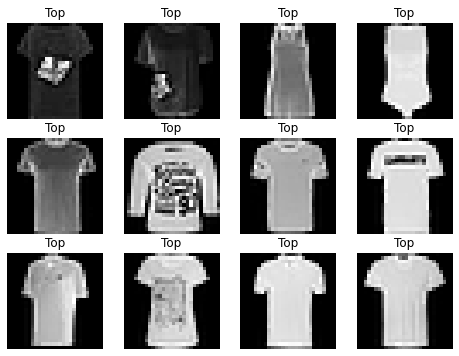

In [ ]:
show_images(x0, imsize=2.0, titles=itemgetter(*y0)(names))

In [ ]:
#show_images(learn.aftr_xb0, imsize=2.0)

In [ ]:
ap1, at = learn.capture_preds()

accuracy,loss,epoch,train
0.939,0.179,0,eval


predict: self.batch[0].shape=torch.Size([384, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([384])
predict: self.batch[0].shape=torch.Size([384, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([384])
predict: self.batch[0].shape=torch.Size([384, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([384])
predict: self.batch[0].shape=torch.Size([384, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([384])
predict: self.batch[0].shape=torch.Size([384, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([384])
predict: self.batch[0].shape=torch.Size([384, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([384])
predict: self.batch[0].shape=torch.Size([384, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([384])
predict: self.batch[0].shape=torch.Size([384, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([384])
predict: self.batch[0].shape=torch.Size([384, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([384])
predict: self.batch[0].shape=torch.Size([384, 1, 28, 28

In [ ]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])

accuracy,loss,epoch,train
0.940,0.174,0,eval


predict: self.batch[0].shape=torch.Size([384, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([384])
predict: self.batch[0].shape=torch.Size([384, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([384])
predict: self.batch[0].shape=torch.Size([384, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([384])
predict: self.batch[0].shape=torch.Size([384, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([384])
predict: self.batch[0].shape=torch.Size([384, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([384])
predict: self.batch[0].shape=torch.Size([384, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([384])
predict: self.batch[0].shape=torch.Size([384, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([384])
predict: self.batch[0].shape=torch.Size([384, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([384])
predict: self.batch[0].shape=torch.Size([384, 1, 28, 28])
predict: self.batch[1].shape=torch.Size([384])
predict: self.batch[0].shape=torch.Size([384, 1, 28, 28

In [ ]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
round((ap==at).float().mean().item(), 3)

0.94